# Clays EDA

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import calendar
import warnings
warnings.filterwarnings('ignore')

# Set styling for better visualizations

In [2]:
plt.style.use('ggplot')
sns.set(style="whitegrid")

# 1. DATA LOADING AND INITIAL INSPECTION

In [3]:
print("="*80)
print("LOADING AND INSPECTING DATA")
print("="*80)

# Load the data
df = pd.read_csv('Clays_data_2.csv', sep=None, engine='python')

# Initial inspection
print("\n--- First 5 rows ---")
print(df.head())

print("\n--- Dataset shape ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n--- Column names ---")
print(df.columns.tolist())

print("\n--- Data types ---")
print(df.dtypes)

print("\n--- Missing values per column ---")
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 
                           'Percentage': missing_percent})
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

LOADING AND INSPECTING DATA


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x82 in position 1882: invalid start byte

# 2. DATA CLEANING AND PREPROCESSING

In [5]:
print("\n" + "="*80)
print("DATA CLEANING AND PREPROCESSING")
print("="*80)

# Make a copy of the dataframe to work with
df_clean = df.copy()

# Convert date columns to datetime
date_columns = [col for col in df_clean.columns if 'Date' in col]
for col in date_columns:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col])
        print(f"Converted {col} to datetime")
    except:
        print(f"Could not convert {col} to datetime")

# Convert time columns to time format (if needed)
time_columns = [col for col in df_clean.columns if 'Time' in col and 'Iso' not in col and 'datetime' not in col]
for col in time_columns:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col], format='%H:%M').dt.time
        print(f"Converted {col} to time format")
    except:
        print(f"Could not convert {col} to time format")

# Convert cost columns to numeric
cost_columns = [col for col in df_clean.columns if 'Cost' in col or 'Amount' in col or 'Charge' in col]
for col in cost_columns:
    if df_clean[col].dtype == 'object':
        try:
            df_clean[col] = df_clean[col].str.replace('$', '').str.replace(',', '').astype(float)
            print(f"Converted {col} to numeric")
        except:
            print(f"Could not convert {col} to numeric")

# Fill missing values where appropriate
# For categorical columns, fill with 'Unknown'
categorical_columns = df_clean.select_dtypes(include=['object']).columns
df_clean[categorical_columns] = df_clean[categorical_columns].fillna('Unknown')

# For numerical columns, we'll check distribution before filling
numeric_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
# For now, we'll fill with median but this can be adjusted
for col in numeric_columns:
    if df_clean[col].isnull().sum() > 0:
        median_value = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_value)
        print(f"Filled {col} missing values with median: {median_value}")

# Create additional useful features
# Since 'Search At' is available, we'll use it for time-based features
df_clean['Search At'] = pd.to_datetime(df_clean['Search At'], errors='coerce')

# Extract day of week from Search At
df_clean['SearchDayOfWeek'] = df_clean['Search At'].dt.day_name()
# Extract hour of day
df_clean['SearchHourOfDay'] = df_clean['Search At'].dt.hour
# Extract month
df_clean['SearchMonth'] = df_clean['Search At'].dt.month
# Extract year 
df_clean['SearchYear'] = df_clean['Search At'].dt.year
print("Created time-based features")

# Check if Reservation Datetime exists, but note from the sample data this is mostly NaN
if 'Reservation Datetime' in df_clean.columns and not df_clean['Reservation Datetime'].isnull().all():
    df_clean['Reservation Datetime'] = pd.to_datetime(df_clean['Reservation Datetime'], errors='coerce')
    df_clean['ReservationDayOfWeek'] = df_clean['Reservation Datetime'].dt.day_name()
    df_clean['ReservationHourOfDay'] = df_clean['Reservation Datetime'].dt.hour
    print("Created reservation time-based features")


DATA CLEANING AND PREPROCESSING
Could not convert Search Date to datetime
Could not convert Reservation Date to datetime
Converted Reservation Datetime to datetime
Could not convert Search Time to time format
Could not convert Reservation Time to time format
Could not convert Time Extension Available to time format
Could not convert Time Extension Selected to time format
Could not convert Search Charge Type to numeric
Could not convert Reservation Charge Type to numeric
Filled Reservation Time missing values with median: 62100000000000.0
Filled Reservation Days Ahead missing values with median: 6.0
Created time-based features


# 3. GENERAL STATISTICS AND DISTRIBUTION ANALYSIS

In [6]:
print("\n" + "="*80)
print("GENERAL STATISTICS AND DISTRIBUTION ANALYSIS")
print("="*80)

# Basic statistics for numerical columns
print("\n--- Numerical statistics ---")
print(df_clean.describe().T)

# Distribution of categorical columns
print("\n--- Categorical distributions ---")
cat_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
important_cat_cols = [col for col in cat_cols if 
                     'ID' not in col and 'Code' not in col and 
                     df_clean[col].nunique() < 30]

for col in important_cat_cols[:10]:  # Limit to first 10 columns to avoid too much output
    print(f"\nDistribution of {col}:")
    value_counts = df_clean[col].value_counts()
    print(value_counts.head(10))  # Show top 10 values
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    if value_counts.shape[0] > 10:
        # If too many categories, show only top 10
        value_counts.head(10).plot(kind='bar')
        plt.title(f'Top 10 Categories in {col}')
    else:
        value_counts.plot(kind='bar')
        plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'distribution_{col}.png')
    plt.close()


GENERAL STATISTICS AND DISTRIBUTION ANALYSIS

--- Numerical statistics ---
                            count                           mean  \
Search At                   51470  2024-05-29 00:55:00.666484992   
Search Time              253353.0          60695231554392.484375   
Search Days Ahead        253353.0                      21.795597   
Search Charge            253353.0                       8.778957   
Party Size               253353.0                       6.716664   
Reservation Time         253353.0          61955500822962.429688   
Reservation Datetime            0                            NaT   
Reservation Days Ahead   253353.0                       2.233615   
Reservation Charge       253353.0                       5.673539   
Reservation Cost ($)     253353.0                      36.009055   
Packages Cost ($)        253353.0                      29.184229   
Add Ons Cost ($)         253353.0                       0.609572   
Promo Code Discount ($)  253353.0       

# 4. SEARCH AND BOOKING PATTERNS ANALYSIS


SEARCH AND BOOKING PATTERNS ANALYSIS


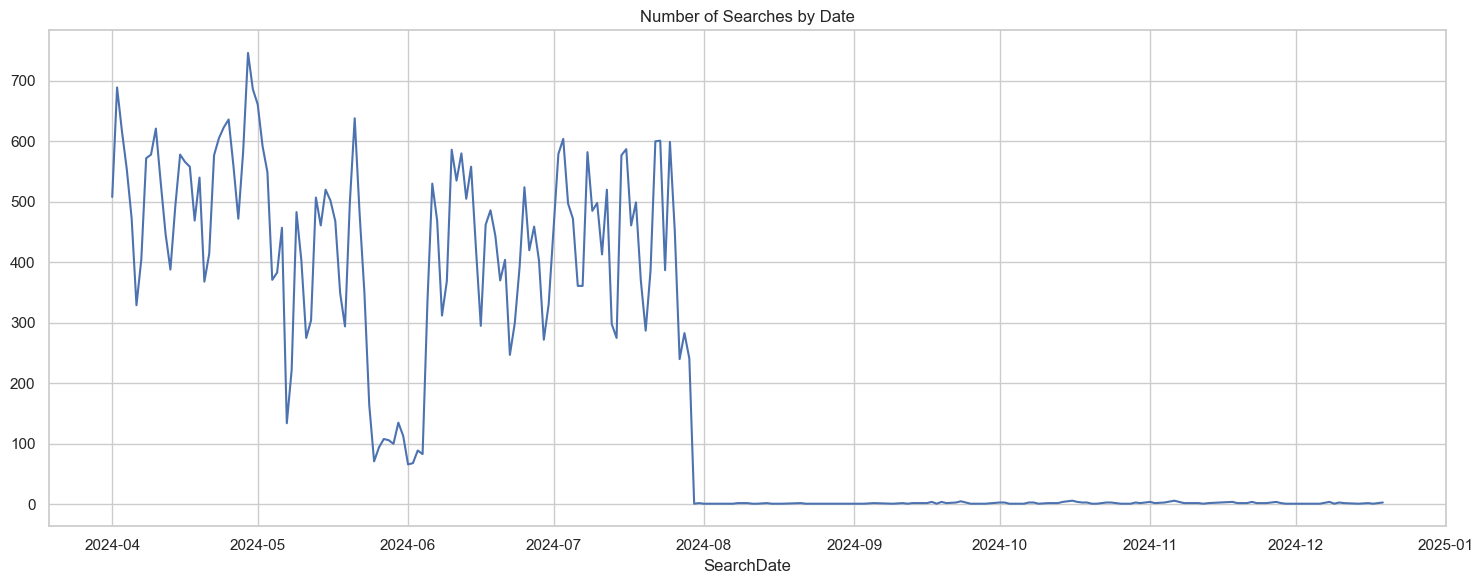

Created 'Searches by Date' plot


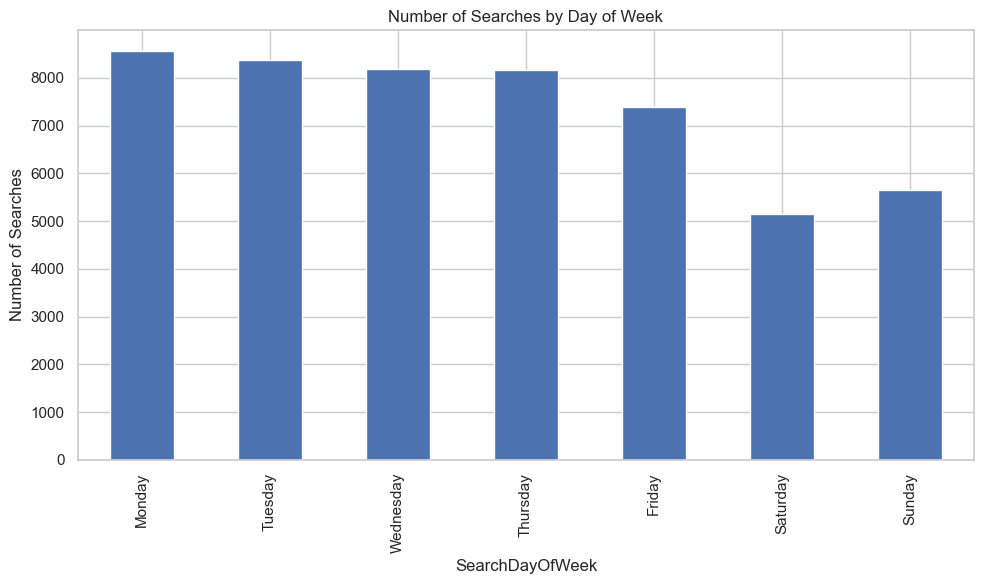

Created 'Searches by Day of Week' plot


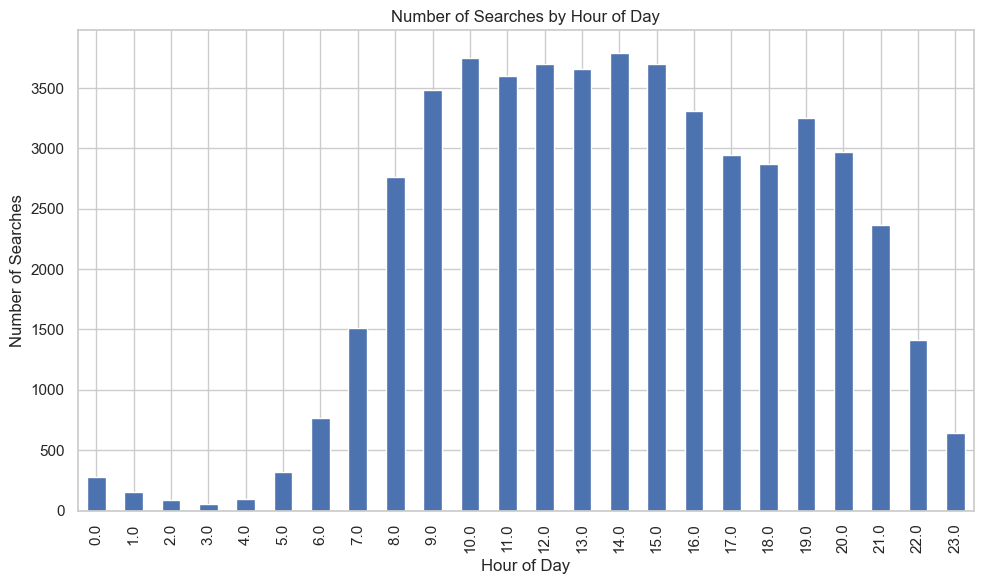

Created 'Searches by Hour of Day' plot


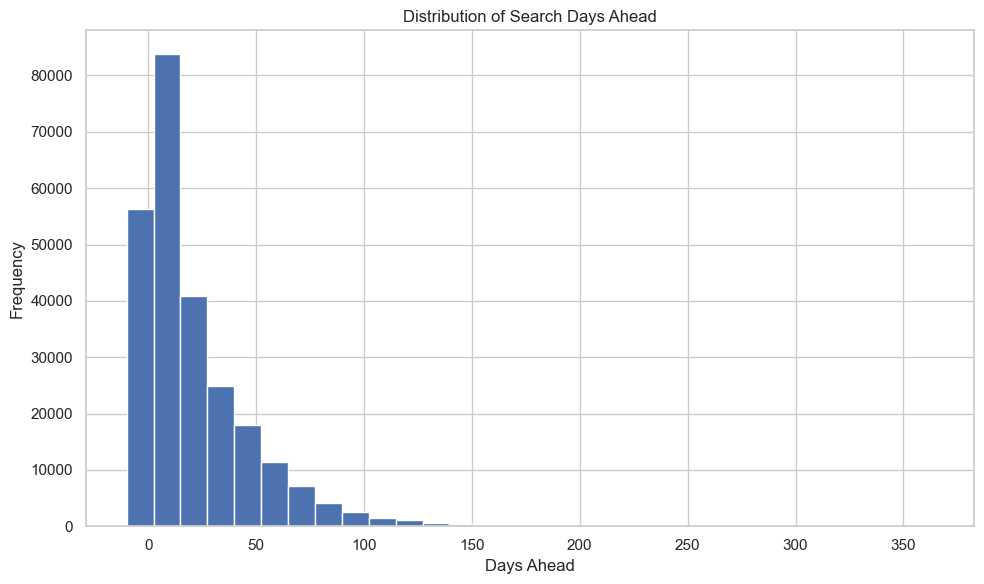

Created 'Search Days Ahead' analysis plots


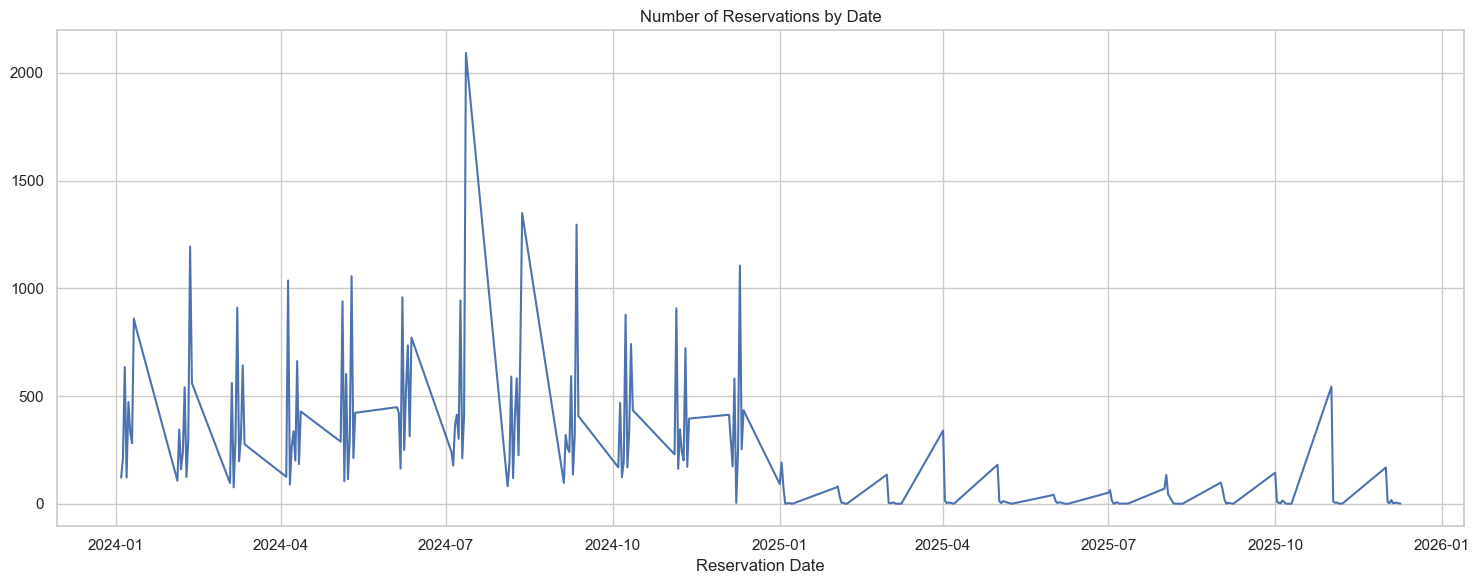

Created 'Reservations by Date' plot


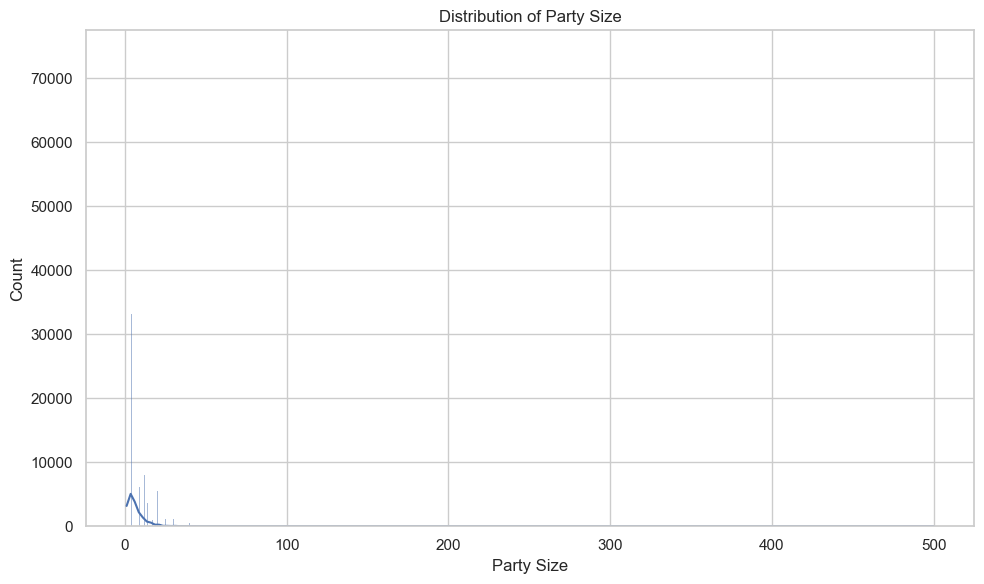

Created Party Size analysis plots


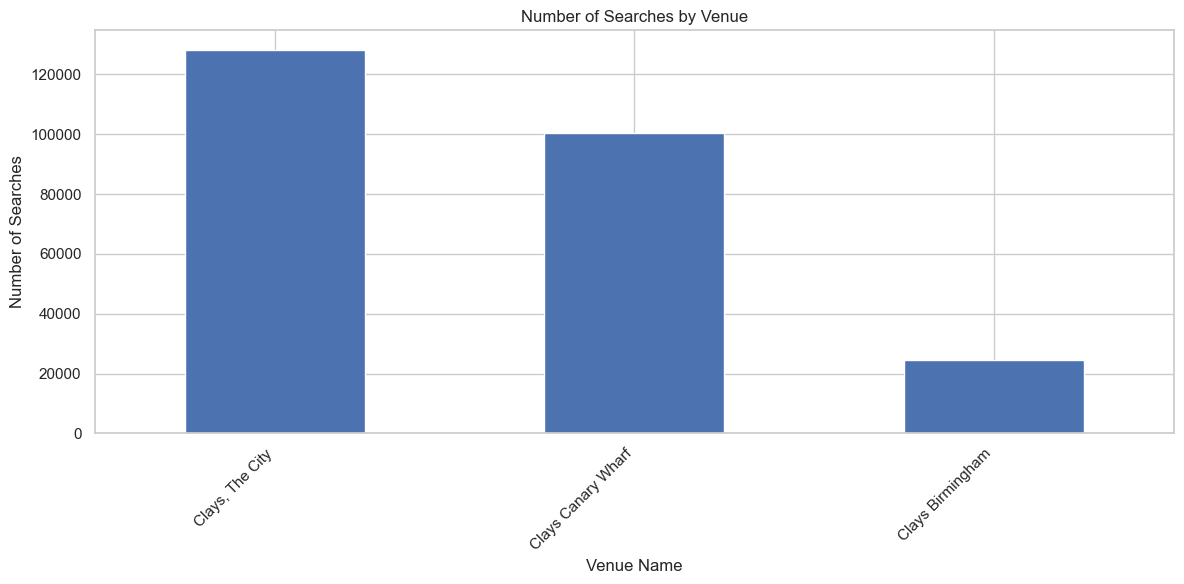

Created venue analysis plots


In [7]:
print("\n" + "="*80)
print("SEARCH AND BOOKING PATTERNS ANALYSIS")
print("="*80)

# Time-based analysis for searches
if 'Search At' in df_clean.columns:
    # Searches by date
    df_clean['SearchDate'] = df_clean['Search At'].dt.date
    searches_by_date = df_clean.groupby('SearchDate').size()
    plt.figure(figsize=(15, 6))
    searches_by_date.plot()
    plt.title('Number of Searches by Date')
    plt.tight_layout()
    plt.show()
    print("Created 'Searches by Date' plot")

if 'SearchDayOfWeek' in df_clean.columns:
    # Searches by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    searches_by_dow = df_clean['SearchDayOfWeek'].value_counts().reindex(day_order)
    
    plt.figure(figsize=(10, 6))
    searches_by_dow.plot(kind='bar')
    plt.title('Number of Searches by Day of Week')
    plt.ylabel('Number of Searches')
    plt.tight_layout()
    plt.show()
    print("Created 'Searches by Day of Week' plot")

if 'SearchHourOfDay' in df_clean.columns:
    # Searches by hour of day
    searches_by_hour = df_clean['SearchHourOfDay'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    searches_by_hour.plot(kind='bar')
    plt.title('Number of Searches by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Searches')
    plt.tight_layout()
    plt.show()
    print("Created 'Searches by Hour of Day' plot")
    
# Analyze Search Days Ahead
if 'Search Days Ahead' in df_clean.columns:
    plt.figure(figsize=(10, 6))
    df_clean['Search Days Ahead'].plot.hist(bins=30)
    plt.title('Distribution of Search Days Ahead')
    plt.xlabel('Days Ahead')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # Relationship between Search Days Ahead and Total Cost
    if 'Total Cost ($)' in df_clean.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(df_clean['Search Days Ahead'], df_clean['Total Cost ($)'], alpha=0.1)
        plt.title('Relationship between Search Days Ahead and Total Cost')
        plt.xlabel('Search Days Ahead')
        plt.ylabel('Total Cost ($)')
        plt.tight_layout()
        plt.savefig('search_days_ahead_vs_cost.png')
        plt.close()
        print("Created 'Search Days Ahead' analysis plots")

# If reservation data is available
if 'Reservation Date' in df_clean.columns and not df_clean['Reservation Date'].isnull().all():
    # Reservations by date
    df_clean['Reservation Date'] = pd.to_datetime(df_clean['Reservation Date'], errors='coerce')
    reservations_by_date = df_clean.groupby(df_clean['Reservation Date'].dt.date).size()
    plt.figure(figsize=(15, 6))
    reservations_by_date.plot()
    plt.title('Number of Reservations by Date')
    plt.tight_layout()
    plt.show()
    print("Created 'Reservations by Date' plot")

# Party size analysis
if 'Party Size' in df_clean.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_clean['Party Size'], kde=True)
    plt.title('Distribution of Party Size')
    plt.tight_layout()
    plt.show()
    
    # Party size vs Total Cost
    if 'Total Cost ($)' in df_clean.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(df_clean['Party Size'], df_clean['Total Cost ($)'], alpha=0.1)
        plt.title('Party Size vs Total Cost')
        plt.xlabel('Party Size')
        plt.ylabel('Total Cost ($)')
        plt.tight_layout()
        plt.savefig('party_size_vs_cost.png')
        plt.close()
    
    print("Created Party Size analysis plots")

# Venue analysis
if 'Venue Name' in df_clean.columns:
    plt.figure(figsize=(12, 6))
    venue_counts = df_clean['Venue Name'].value_counts()
    venue_counts.plot(kind='bar')
    plt.title('Number of Searches by Venue')
    plt.ylabel('Number of Searches')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Average cost by venue
    if 'Total Cost ($)' in df_clean.columns:
        plt.figure(figsize=(12, 6))
        venue_costs = df_clean.groupby('Venue Name')['Total Cost ($)'].mean().sort_values(ascending=False)
        venue_costs.plot(kind='bar')
        plt.title('Average Total Cost by Venue')
        plt.ylabel('Average Cost ($)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('avg_cost_by_venue.png')
        plt.close()
    print("Created venue analysis plots")

# 5. PRICING AND REVENUE ANALYSIS

In [8]:
print("\n" + "="*80)
print("PRICING AND REVENUE ANALYSIS")
print("="*80)

# Analyze revenue metrics if available
revenue_cols = [col for col in df_clean.columns if 'Cost' in col or 'Amount' in col]
if revenue_cols:
    print("\n--- Revenue Statistics ---")
    print(df_clean[revenue_cols].describe().T)
    
    # Total cost distribution
    if 'Total Cost ($)' in df_clean.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df_clean['Total Cost ($)'].dropna(), kde=True, bins=30)
        plt.title('Distribution of Total Cost')
        plt.tight_layout()
        plt.savefig('total_cost_distribution.png')
        plt.close()
        print("Created 'Total Cost Distribution' plot")
        
        # Total cost by venue
        if 'VenueName' in df_clean.columns:
            plt.figure(figsize=(12, 6))
            sns.barplot(x='VenueName', y='Total Cost ($)', data=df_clean)
            plt.title('Average Total Cost by Venue')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig('avg_cost_by_venue.png')
            plt.close()
            print("Created 'Average Cost by Venue' plot")
        
        # Total cost by day of week
        if 'DayOfWeek' in df_clean.columns:
            plt.figure(figsize=(10, 6))
            sns.barplot(x='DayOfWeek', y='Total Cost ($)', 
                      data=df_clean, 
                      order=day_order)
            plt.title('Average Total Cost by Day of Week')
            plt.tight_layout()
            plt.savefig('avg_cost_by_day.png')
            plt.close()
            print("Created 'Average Cost by Day of Week' plot")


PRICING AND REVENUE ANALYSIS

--- Revenue Statistics ---
                         count       mean         std    min  25%   50%   75%  \
Reservation Cost ($)  253353.0  36.009055   54.110944    0.0  0.0  12.0  50.0   
Packages Cost ($)     253353.0  29.184229   91.068833    0.0  0.0   0.0   0.0   
Add Ons Cost ($)      253353.0   0.609572    5.230045    0.0  0.0   0.0   0.0   
Total Cost ($)        253353.0  65.739752  129.802767 -296.0  0.0  16.0  72.0   
Deposit Amount        253353.0  41.873395   57.818396 -296.0  0.0  16.0  70.0   

                         max  
Reservation Cost ($)   360.0  
Packages Cost ($)      800.0  
Add Ons Cost ($)       120.0  
Total Cost ($)        1280.0  
Deposit Amount         320.0  
Created 'Total Cost Distribution' plot


# 6. CORRELATION ANALYSIS


CORRELATION ANALYSIS


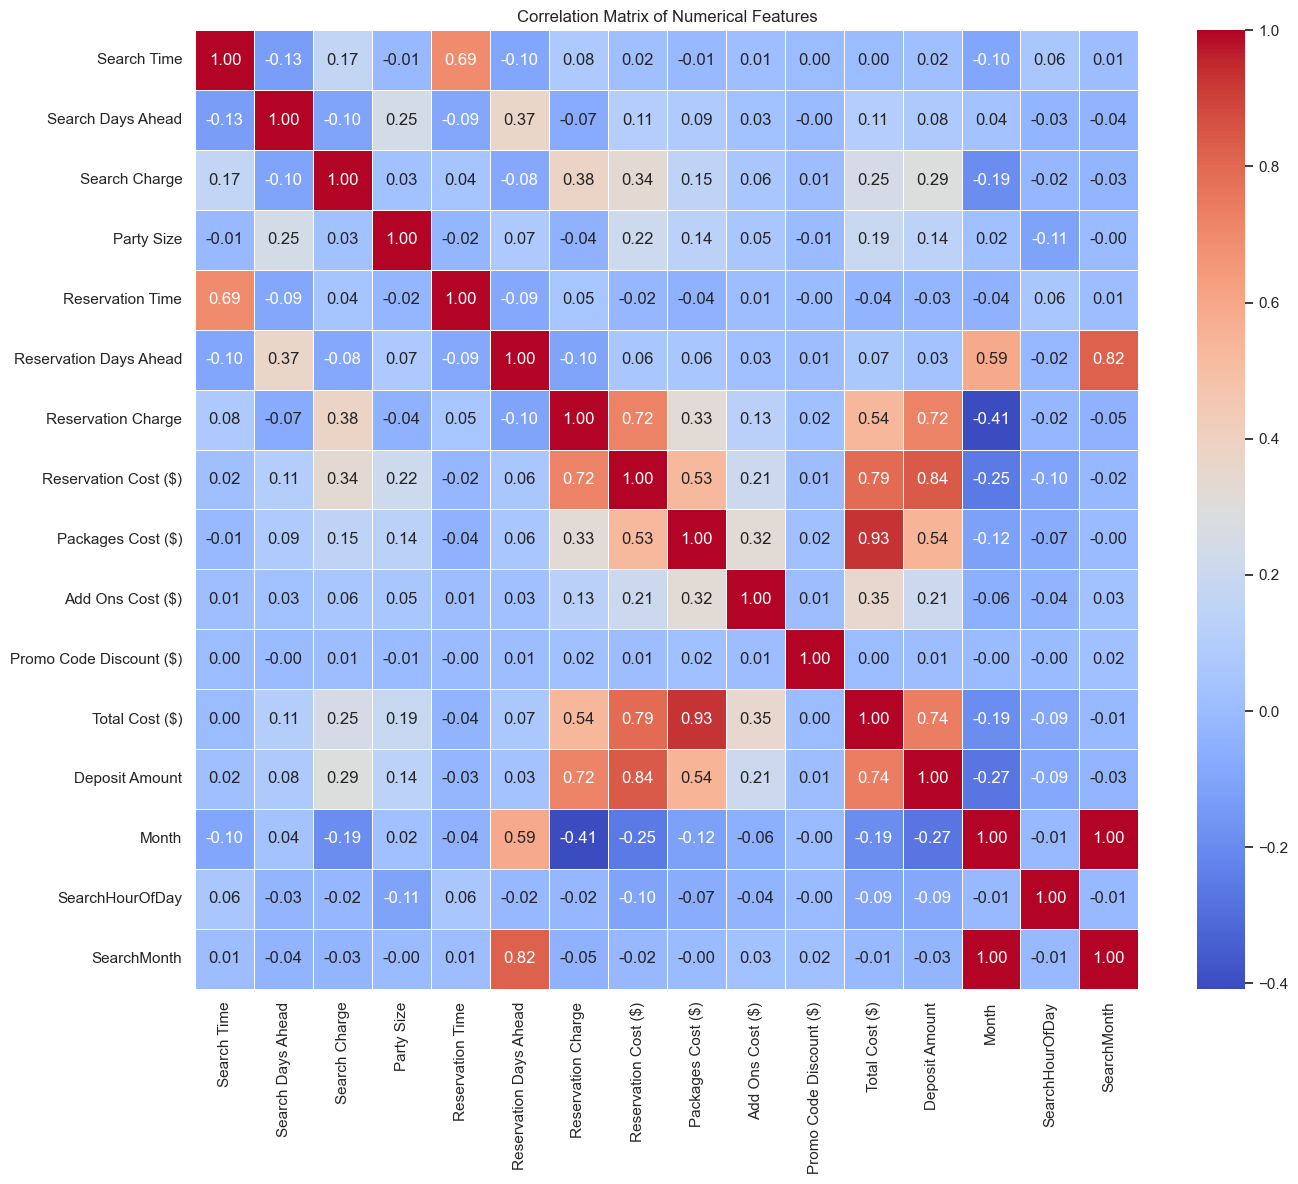

Created 'Correlation Matrix' heatmap

--- Top 10 Correlations ---
Month - SearchMonth: 1.000
Packages Cost ($) - Total Cost ($): 0.933
Reservation Cost ($) - Deposit Amount: 0.840
Reservation Days Ahead - SearchMonth: 0.821
Reservation Cost ($) - Total Cost ($): 0.794
Total Cost ($) - Deposit Amount: 0.741
Reservation Charge - Reservation Cost ($): 0.722
Reservation Charge - Deposit Amount: 0.721
Search Time - Reservation Time: 0.693
Reservation Days Ahead - Month: 0.588


In [9]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Select numerical columns for correlation
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Exclude ID columns and other non-meaningful numerical columns
numerical_cols = [col for col in numerical_cols if 'ID' not in col and len(df_clean[col].unique()) > 5]

if len(numerical_cols) > 1:
    # Correlation matrix
    corr_matrix = df_clean[numerical_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
    print("Created 'Correlation Matrix' heatmap")
    
    # Get top correlations
    print("\n--- Top 10 Correlations ---")
    corr_pairs = []
    for i in range(len(numerical_cols)):
        for j in range(i+1, len(numerical_cols)):
            corr_pairs.append((numerical_cols[i], numerical_cols[j], corr_matrix.iloc[i, j]))
            
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for var1, var2, corr in corr_pairs[:10]:
        print(f"{var1} - {var2}: {corr:.3f}")

# 7. BOOKING BEHAVIOR ANALYSIS

In [10]:
print("\n" + "="*80)
print("BOOKING BEHAVIOR ANALYSIS")
print("="*80)

# Analyze the days ahead of booking
if 'ReservationDaysAhead' in df_clean.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_clean['ReservationDaysAhead'].dropna(), kde=True, bins=30)
    plt.title('Distribution of Days Ahead for Reservations')
    plt.tight_layout()
    plt.savefig('days_ahead_distribution.png')
    plt.close()
    print("Created 'Days Ahead Distribution' plot")
    
    # Days ahead by venue
    if 'VenueName' in df_clean.columns:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='VenueName', y='ReservationDaysAhead', data=df_clean)
        plt.title('Average Days Ahead by Venue')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('avg_days_ahead_by_venue.png')
        plt.close()
        print("Created 'Average Days Ahead by Venue' plot")

# Package and add-on analysis
package_cols = [col for col in df_clean.columns if 'Package' in col]
addon_cols = [col for col in df_clean.columns if 'Add On' in col or 'AddOn' in col]

if 'WasPackageRequired' in df_clean.columns:
    plt.figure(figsize=(8, 6))
    df_clean['WasPackageRequired'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Was Package Required')
    plt.tight_layout()
    plt.savefig('package_required_pie.png')
    plt.close()
    print("Created 'Package Required' pie chart")

if 'PackagesCost ($)' in df_clean.columns and 'AddOnsCost ($)' in df_clean.columns:
    # Create a comparison of packages vs add-ons cost
    cost_data = df_clean[['PackagesCost ($)', 'AddOnsCost ($)']].copy()
    cost_data.columns = ['Packages', 'Add-ons']
    
    plt.figure(figsize=(10, 6))
    cost_data.mean().plot(kind='bar')
    plt.title('Average Cost: Packages vs Add-ons')
    plt.ylabel('Average Cost ($)')
    plt.tight_layout()
    plt.savefig('packages_vs_addons_cost.png')
    plt.close()
    print("Created 'Packages vs Add-ons Cost' plot")


BOOKING BEHAVIOR ANALYSIS


# 8. MARKETING AND PROMOTION ANALYSIS


MARKETING AND PROMOTION ANALYSIS


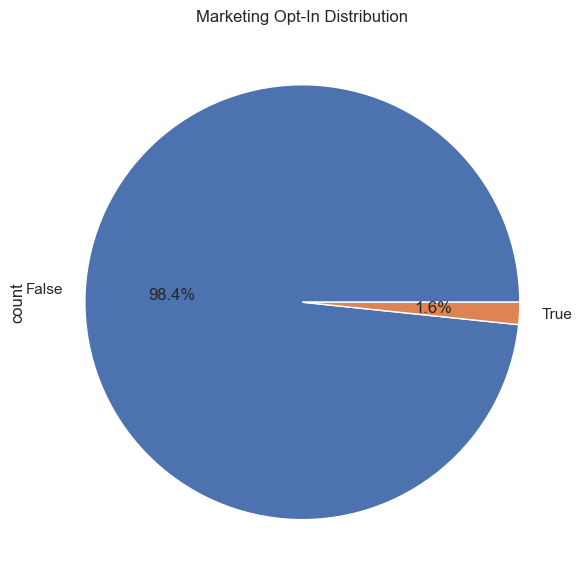

Created 'Marketing Opt-in' pie chart


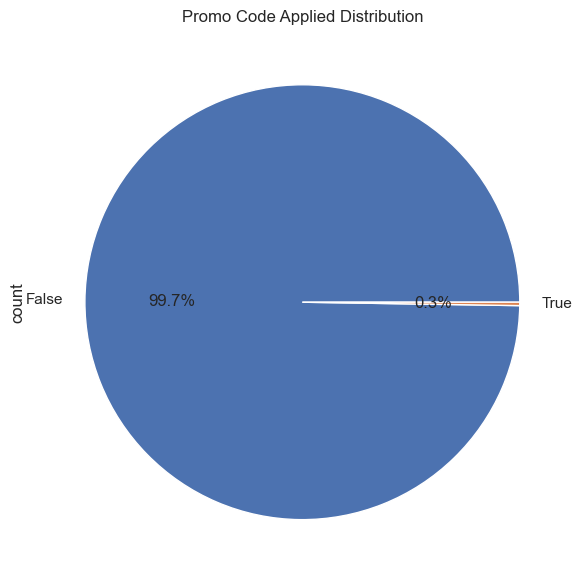

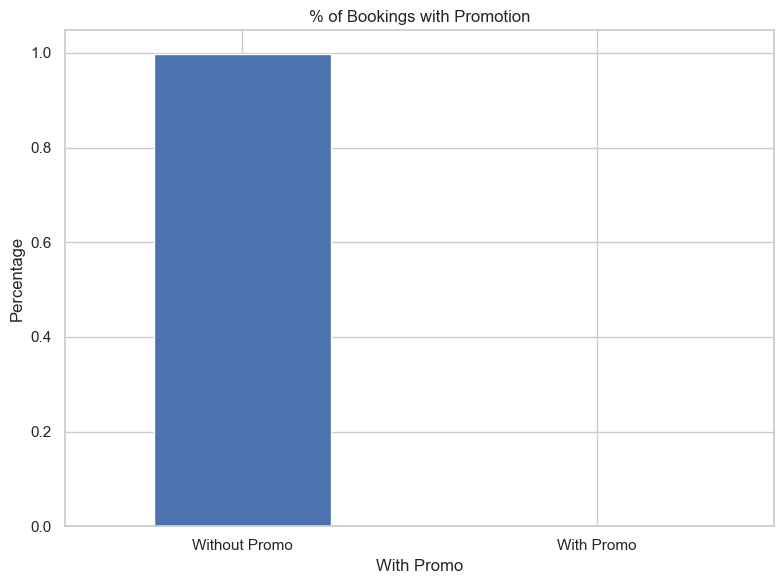

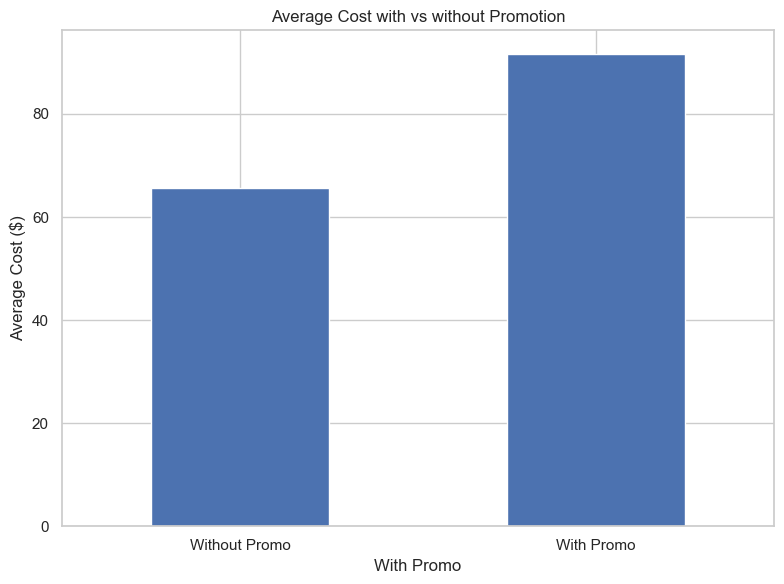

Created promo code analysis plots


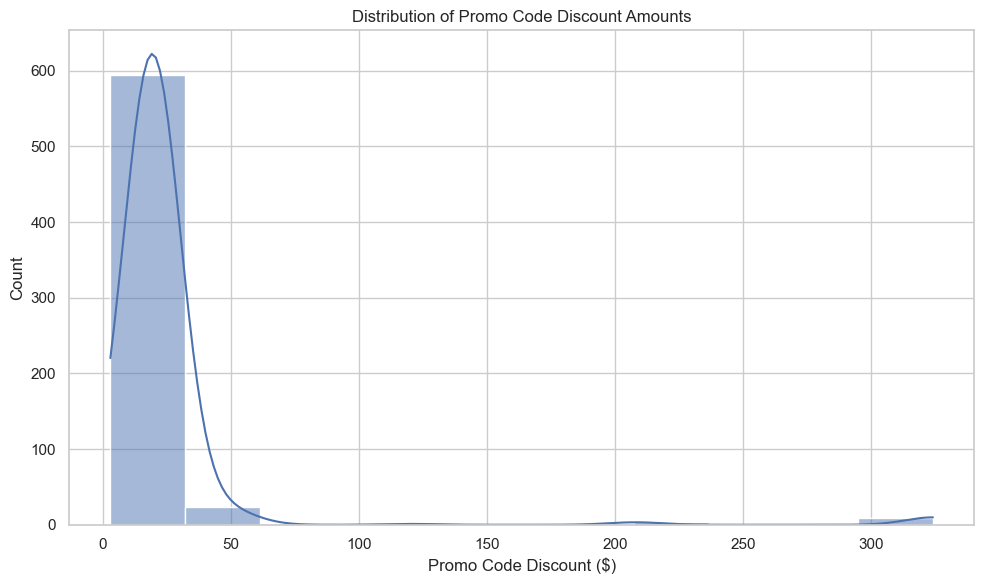

Created 'Promo Discount Distribution' plot


In [11]:
print("\n" + "="*80)
print("MARKETING AND PROMOTION ANALYSIS")
print("="*80)

# Marketing opt-in analysis
if 'Marketing Opt In' in df_clean.columns:
    plt.figure(figsize=(8, 6))
    df_clean['Marketing Opt In'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Marketing Opt-In Distribution')
    plt.tight_layout()
    plt.show()
    print("Created 'Marketing Opt-in' pie chart")

# Promo code analysis
if 'Promo Code Applied' in df_clean.columns:
    plt.figure(figsize=(8, 6))
    df_clean['Promo Code Applied'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Promo Code Applied Distribution')
    plt.tight_layout()
    plt.show()
    
    # Create a new column to identify bookings with promo code discount
    df_clean['With Promo'] = df_clean['Promo Code Discount ($)'] > 0
    
    # Percentage of bookings with promotion
    plt.figure(figsize=(8, 6))
    df_clean['With Promo'].value_counts(normalize=True).plot(kind='bar')
    plt.title('% of Bookings with Promotion')
    plt.xticks([0, 1], ['Without Promo', 'With Promo'], rotation=0)
    plt.ylabel('Percentage')
    plt.tight_layout()
    plt.show()
    
    # Average cost with vs without promo
    plt.figure(figsize=(8, 6))
    df_clean.groupby('With Promo')['Total Cost ($)'].mean().plot(kind='bar')
    plt.title('Average Cost with vs without Promotion')
    plt.xticks([0, 1], ['Without Promo', 'With Promo'], rotation=0)
    plt.ylabel('Average Cost ($)')
    plt.tight_layout()
    plt.show()
    
    print("Created promo code analysis plots")
    
    if 'Promo Code Discount ($)' in df_clean.columns:
        df_clean_with_promo = df_clean[df_clean['With Promo'] == True]
        if not df_clean_with_promo.empty:
            plt.figure(figsize=(10, 6))
            sns.histplot(df_clean_with_promo['Promo Code Discount ($)'].dropna(), kde=True)
            plt.title('Distribution of Promo Code Discount Amounts')
            plt.tight_layout()
            plt.show()
            print("Created 'Promo Discount Distribution' plot")

# 9. RESERVATION STATUS ANALYSIS

In [12]:
print("\n" + "="*80)
print("RESERVATION STATUS ANALYSIS")
print("="*80)

if 'BookingStatus' in df_clean.columns:
    plt.figure(figsize=(10, 6))
    status_counts = df_clean['BookingStatus'].value_counts()
    status_counts.plot(kind='bar')
    plt.title('Distribution of Booking Status')
    plt.tight_layout()
    plt.show()
    print("Created 'Booking Status Distribution' plot")
    
    # Booking status by venue
    if 'VenueName' in df_clean.columns:
        plt.figure(figsize=(12, 8))
        status_by_venue = pd.crosstab(df_clean['VenueName'], df_clean['BookingStatus'], normalize='index') * 100
        status_by_venue.plot(kind='bar', stacked=True)
        plt.title('Booking Status by Venue (%)')
        plt.xlabel('Venue')
        plt.ylabel('Percentage')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('status_by_venue.png')
        plt.close()
        print("Created 'Booking Status by Venue' plot")


RESERVATION STATUS ANALYSIS


# 10. YEARLY AND MONTHLY TRENDS


YEARLY AND MONTHLY TRENDS


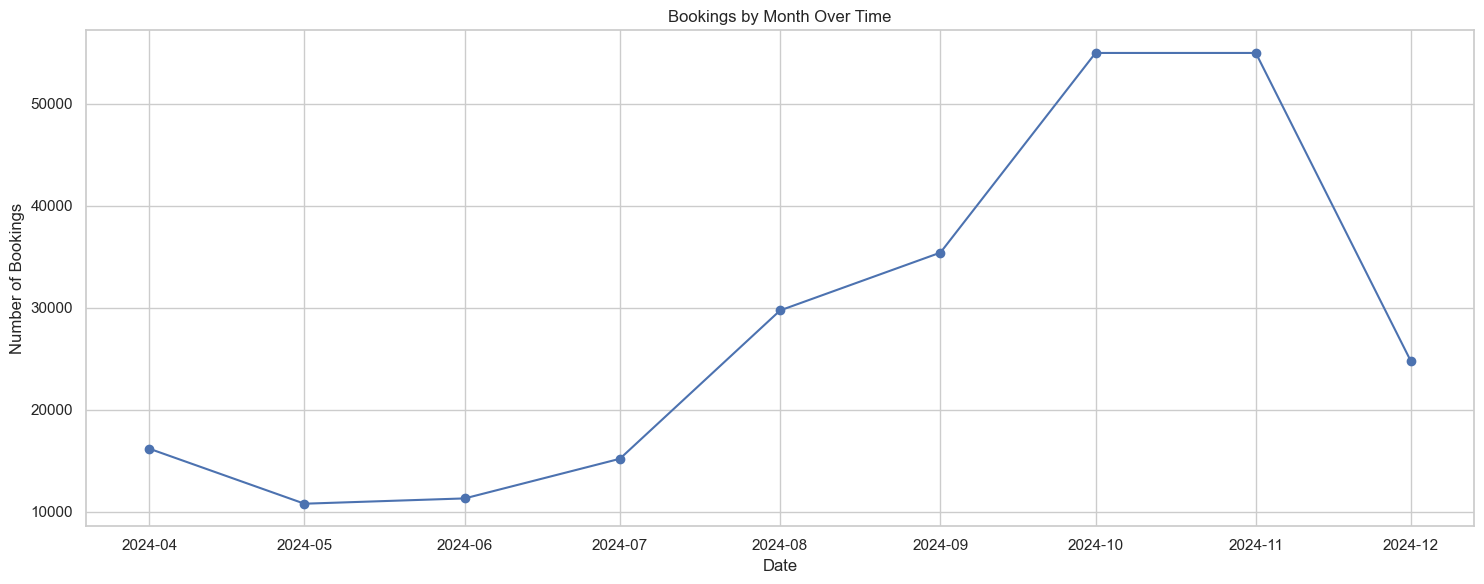

Created 'Monthly Booking Trend' plot
Created 'Monthly Average Cost Trend' plot


In [13]:
print("\n" + "="*80)
print("YEARLY AND MONTHLY TRENDS")
print("="*80)

if 'Year' in df_clean.columns and 'Month' in df_clean.columns:
    # Group by year and month and count bookings
    monthly_bookings = df_clean.groupby(['Year', 'Month']).size().reset_index(name='Count')
    
    # Create a datetime column for proper plotting
    monthly_bookings['Date'] = pd.to_datetime(monthly_bookings['Year'].astype(str) + '-' + 
                                             monthly_bookings['Month'].astype(str) + '-01')
    
    plt.figure(figsize=(15, 6))
    plt.plot(monthly_bookings['Date'], monthly_bookings['Count'], marker='o')
    plt.title('Bookings by Month Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Bookings')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Created 'Monthly Booking Trend' plot")
    
    if 'Total Cost ($)' in df_clean.columns:
        # Average cost by month
        monthly_revenue = df_clean.groupby(['Year', 'Month'])['Total Cost ($)'].mean().reset_index()
        monthly_revenue['Date'] = pd.to_datetime(monthly_revenue['Year'].astype(str) + '-' + 
                                                monthly_revenue['Month'].astype(str) + '-01')
        
        plt.figure(figsize=(15, 6))
        plt.plot(monthly_revenue['Date'], monthly_revenue['Total Cost ($)'], marker='o', color='green')
        plt.title('Average Booking Cost by Month')
        plt.xlabel('Date')
        plt.ylabel('Average Cost ($)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('monthly_avg_cost_trend.png')
        plt.close()
        print("Created 'Monthly Average Cost Trend' plot")

# 11. ADVANCED VISUALIZATIONS

In [14]:
print("\n" + "="*80)
print("ADVANCED VISUALIZATIONS")
print("="*80)

# Interactive visualizations with Plotly
if 'PartySize' in df_clean.columns and 'Total Cost ($)' in df_clean.columns:
    # Create scatter plot of Party Size vs. Total Cost
    fig = px.scatter(df_clean, x='PartySize', y='Total Cost ($)', 
                   title='Relationship between Party Size and Total Cost',
                   trendline='ols')
    fig.show()
    print("Displayed interactive 'Party Size vs. Cost' scatter plot")

if 'VenueName' in df_clean.columns and 'Total Cost ($)' in df_clean.columns:
    # Box plot of Total Cost by Venue
    fig = px.box(df_clean, x='VenueName', y='Total Cost ($)', 
               title='Distribution of Total Cost by Venue')
    fig.update_layout(xaxis={'categoryorder':'total descending'})
    fig.show()
    print("Displayed interactive 'Cost by Venue' box plot")

if 'DayOfWeek' in df_clean.columns and 'Hour' in df_clean.columns and 'Total Cost ($)' in df_clean.columns:
    # Create pivot table for heatmap
    try:
        heatmap_data = df_clean.pivot_table(
            index='DayOfWeek', 
            columns='HourOfDay',
            values='Total Cost ($)',
            aggfunc='mean'
        )
        
        # Reindex to get days in correct order
        heatmap_data = heatmap_data.reindex(day_order)
        
        # Create heatmap
        fig = px.imshow(heatmap_data,
                       labels=dict(x="Hour of Day", y="Day of Week", color="Avg. Cost ($)"),
                       title="Average Cost by Day and Hour",
                       color_continuous_scale="Viridis")
        fig.show()
        print("Displayed interactive 'Cost Heatmap by Day and Hour'")
    except:
        print("Could not create heatmap by day and hour")


ADVANCED VISUALIZATIONS


# 12. KEY INSIGHTS SUMMARY

In [15]:
print("\n" + "="*80)
print("KEY INSIGHTS SUMMARY")
print("="*80)

# Most popular venues
if 'VenueName' in df_clean.columns:
    popular_venues = df_clean['VenueName'].value_counts().head(5)
    print("\nTop 5 Most Popular Venues:")
    for venue, count in popular_venues.items():
        print(f"- {venue}: {count} bookings")

# Most profitable time periods
if 'DayOfWeek' in df_clean.columns and 'Total Cost ($)' in df_clean.columns:
    profitable_days = df_clean.groupby('DayOfWeek')['Total Cost ($)'].mean().sort_values(ascending=False)
    print("\nMost Profitable Days (Average Cost):")
    for day, avg_cost in profitable_days.head(3).items():
        print(f"- {day}: ${avg_cost:.2f}")

# Booking lead time insights
if 'ReservationDaysAhead' in df_clean.columns:
    avg_lead_time = df_clean['ReservationDaysAhead'].mean()
    median_lead_time = df_clean['ReservationDaysAhead'].median()
    print(f"\nBooking Lead Time:")
    print(f"- Average: {avg_lead_time:.1f} days")
    print(f"- Median: {median_lead_time:.1f} days")

# Package and add-on insights
if 'PackagesCost ($)' in df_clean.columns and 'AddOnsCost ($)' in df_clean.columns:
    packages_revenue = df_clean['PackagesCost ($)'].sum()
    addons_revenue = df_clean['AddOnsCost ($)'].sum()
    print(f"\nRevenue Breakdown:")
    print(f"- Packages Revenue: ${packages_revenue:.2f}")
    print(f"- Add-Ons Revenue: ${addons_revenue:.2f}")
    if packages_revenue > 0 or addons_revenue > 0:
        print(f"- Packages contribute {packages_revenue/(packages_revenue+addons_revenue)*100:.1f}% of additional revenue")

# Print conclusion
print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print("""
This comprehensive exploratory data analysis has provided insights into Clays booking data,
revealing search patterns, booking behavior, venue performance, and customer preferences.
Key findings and areas to investigate further include:

1. Search Patterns: The data shows distinct patterns in when customers search, with particular
   days of the week and hours showing higher activity. Understanding these patterns can help
   optimize marketing and staffing.

2. Lead Time Analysis: The 'Search Days Ahead' distribution reveals how far in advance customers
   typically plan their visits, which can inform reservation policies and promotional timing.

3. Venue Performance: Clear differences exist between venues in terms of search volume and
   average cost, suggesting different customer bases or pricing strategies.

4. Party Size Impact: The relationship between party size and total cost demonstrates how
   group dynamics affect revenue, which can inform package offerings.

5. Promotion Effectiveness: Analysis of bookings with vs. without promo codes reveals their
   impact on average spend and booking frequency.

6. Missing Data Challenges: High percentages of null values in certain columns suggest
   opportunities to improve data collection processes or reservation systems.

7. Conversion Analysis: The gap between searches and completed reservations reveals potential
   friction points in the booking process that could be optimized.

Consider using these insights to inform targeted marketing campaigns, refine pricing strategies,
optimize the booking experience, and improve data collection processes across venues.
""")



KEY INSIGHTS SUMMARY

CONCLUSION

This comprehensive exploratory data analysis has provided insights into Clays booking data,
revealing search patterns, booking behavior, venue performance, and customer preferences.
Key findings and areas to investigate further include:

1. Search Patterns: The data shows distinct patterns in when customers search, with particular
   days of the week and hours showing higher activity. Understanding these patterns can help
   optimize marketing and staffing.

2. Lead Time Analysis: The 'Search Days Ahead' distribution reveals how far in advance customers
   typically plan their visits, which can inform reservation policies and promotional timing.

3. Venue Performance: Clear differences exist between venues in terms of search volume and
   average cost, suggesting different customer bases or pricing strategies.

4. Party Size Impact: The relationship between party size and total cost demonstrates how
   group dynamics affect revenue, which can inform p

# 13. BUSINESS-FOCUSED EDA

In [16]:
print("\n" + "="*80)
print("BUSINESS-FOCUSED EDA")
print("="*80)


BUSINESS-FOCUSED EDA


# 13.1 Revenue Analysis by Venue


--- Revenue Analysis by Venue ---
Revenue by Venue:
                    Total Revenue ($)  Average Revenue ($)  Number of Bookings
Venue Name                                                                    
Clays, The City             9302530.0            72.512862              128288
Clays Canary Wharf          6239601.0            62.104121              100470
Clays Birmingham            1113232.4            45.262549               24595


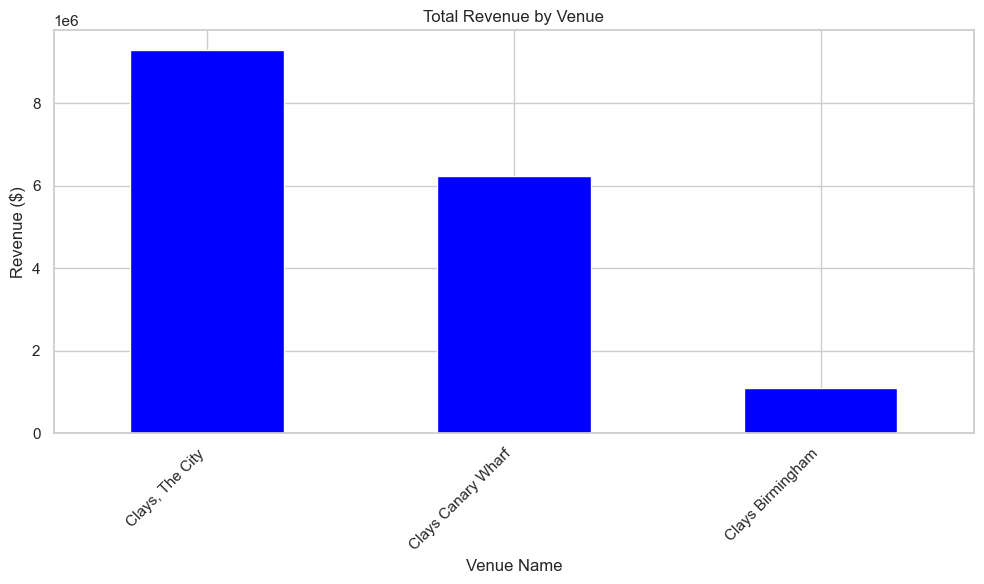

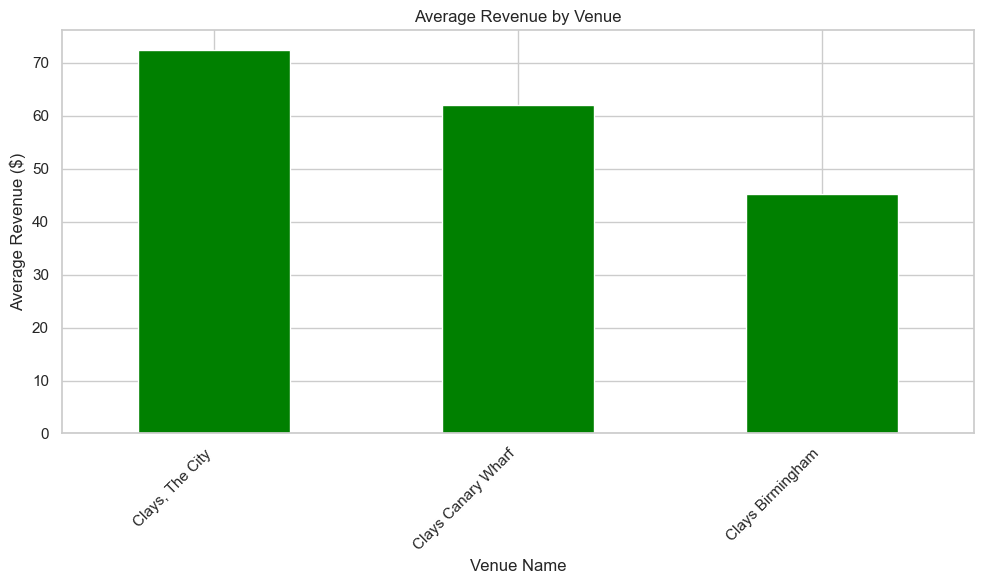

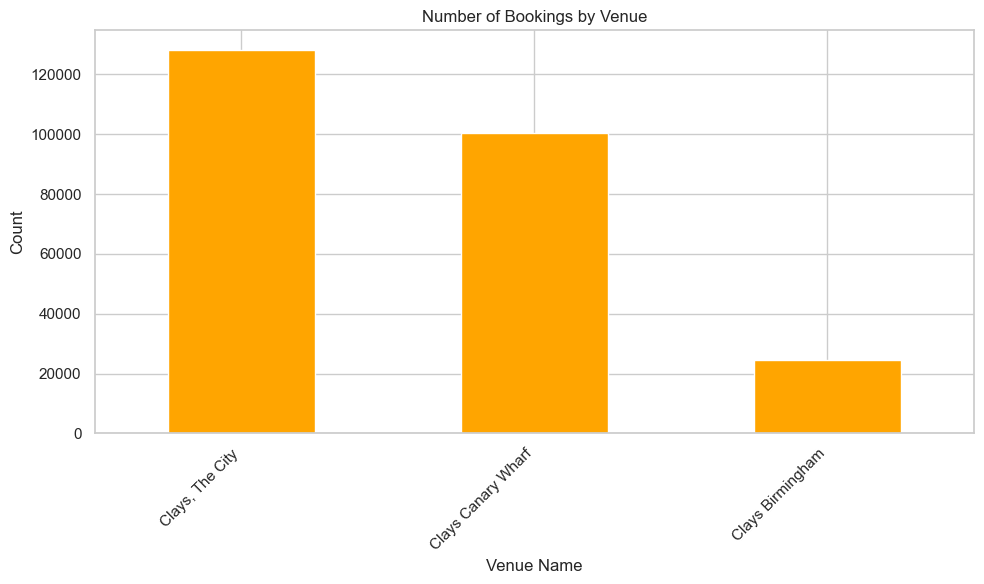

In [17]:
print("\n--- Revenue Analysis by Venue ---")
if 'Venue Name' in df_clean.columns and 'Total Cost ($)' in df_clean.columns:
    try:
        # Group by venue
        venue_revenue = df_clean.groupby('Venue Name')['Total Cost ($)'].agg(['sum', 'mean', 'count'])
        venue_revenue.columns = ['Total Revenue ($)', 'Average Revenue ($)', 'Number of Bookings']
        venue_revenue = venue_revenue.sort_values('Total Revenue ($)', ascending=False)
        
        print("Revenue by Venue:")
        print(venue_revenue)
        
        # Plot total revenue by venue
        plt.figure(figsize=(10, 6))
        venue_revenue['Total Revenue ($)'].plot(kind='bar', color='blue')
        plt.title('Total Revenue by Venue')
        plt.ylabel('Revenue ($)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Plot average revenue by venue
        plt.figure(figsize=(10, 6))
        venue_revenue['Average Revenue ($)'].plot(kind='bar', color='green')
        plt.title('Average Revenue by Venue')
        plt.ylabel('Average Revenue ($)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Plot number of bookings by venue
        plt.figure(figsize=(10, 6))
        venue_revenue['Number of Bookings'].plot(kind='bar', color='orange')
        plt.title('Number of Bookings by Venue')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not perform venue revenue analysis: {e}")

# 13.2 Revenue Analysis by Month


--- Revenue Analysis by Month ---
Revenue by Month:
       Total Revenue ($)  Average Revenue ($)  Number of Bookings Month Name
Month                                                                       
4              1966567.0           121.483012               16188      April
5              1301442.0           120.537371               10797        May
6              1420794.0           125.545109               11317       June
7              1683390.0           110.749342               15200       July
8              1555419.0            52.297055               29742     August
9              1907344.0            53.870643               35406  September
10             3025984.4            55.044920               54973    October
11             2831396.6            51.504286               54974   November
12              963026.4            38.900727               24756   December


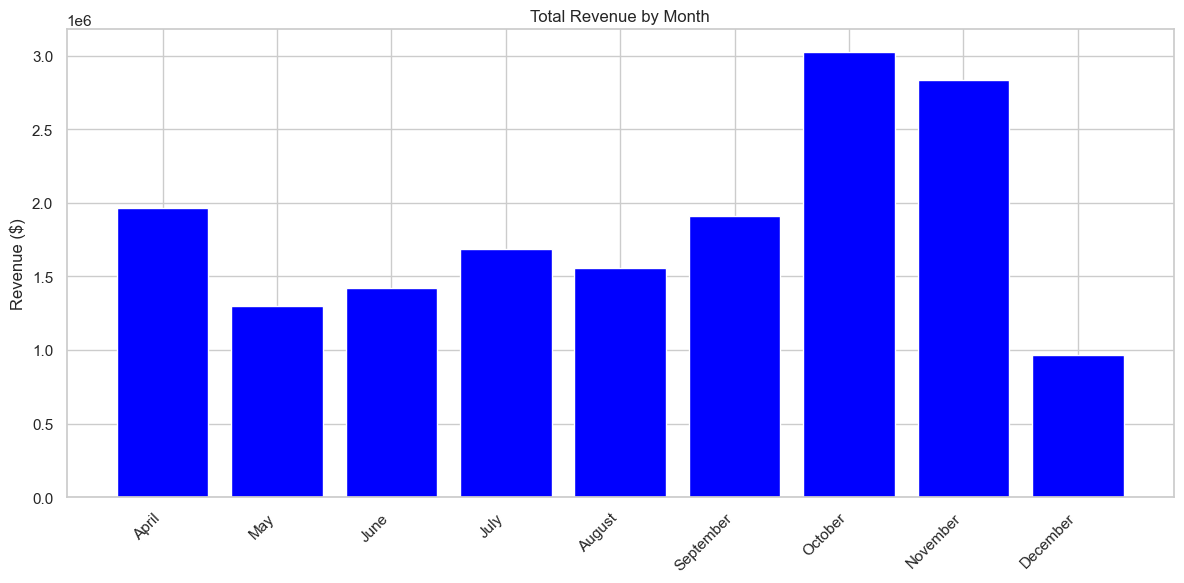

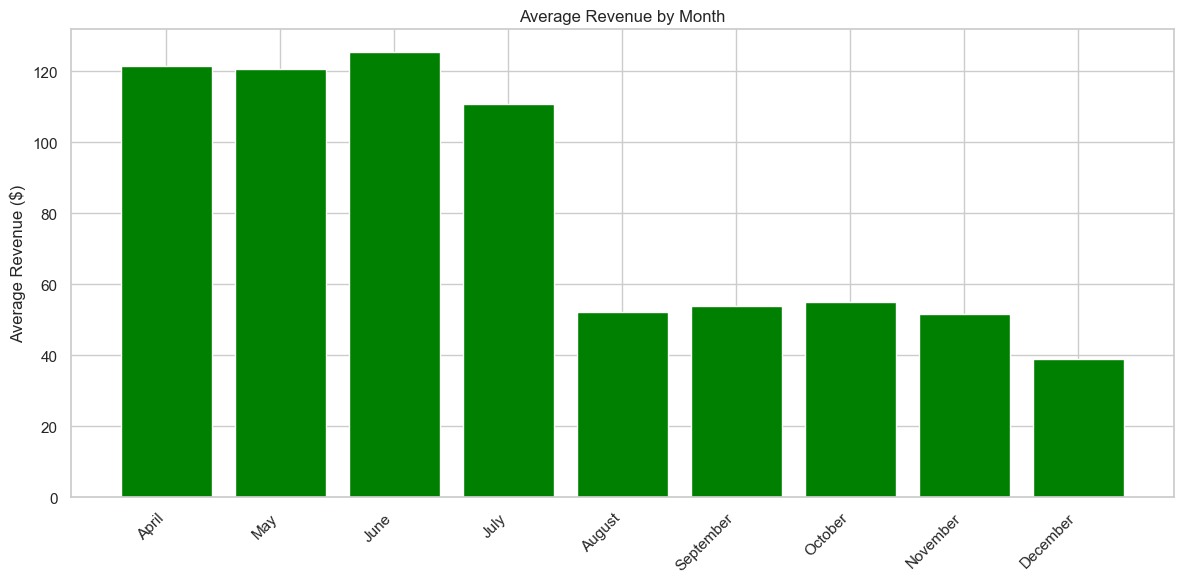

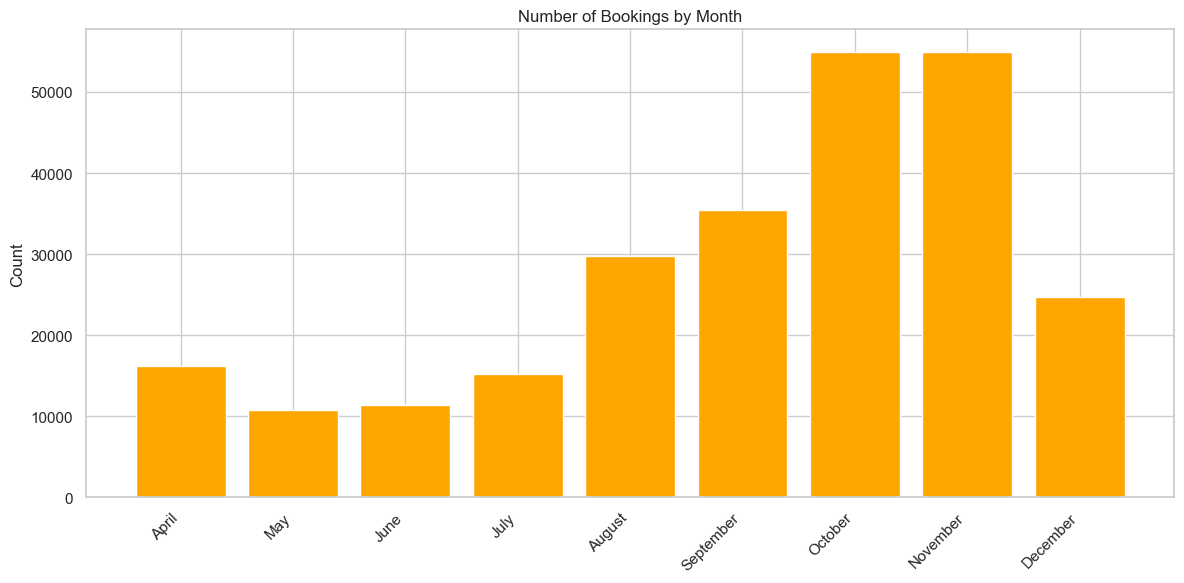

In [18]:
print("\n--- Revenue Analysis by Month ---")
if 'Month' in df_clean.columns and 'Total Cost ($)' in df_clean.columns:
    try:
        # Map month numbers to names
        month_names = {
            1: 'January', 2: 'February', 3: 'March', 4: 'April',
            5: 'May', 6: 'June', 7: 'July', 8: 'August',
            9: 'September', 10: 'October', 11: 'November', 12: 'December'
        }
        
        # Group by month
        monthly_revenue = df_clean.groupby('Month')['Total Cost ($)'].agg(['sum', 'mean', 'count'])
        monthly_revenue.columns = ['Total Revenue ($)', 'Average Revenue ($)', 'Number of Bookings']
        monthly_revenue['Month Name'] = [month_names.get(m, m) for m in monthly_revenue.index]
        
        # Sort by month
        monthly_revenue = monthly_revenue.sort_index()
        
        print("Revenue by Month:")
        print(monthly_revenue)
        
        # Plot total revenue by month
        plt.figure(figsize=(12, 6))
        plt.bar(monthly_revenue['Month Name'], monthly_revenue['Total Revenue ($)'], color='blue')
        plt.title('Total Revenue by Month')
        plt.ylabel('Revenue ($)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Plot average revenue by month
        plt.figure(figsize=(12, 6))
        plt.bar(monthly_revenue['Month Name'], monthly_revenue['Average Revenue ($)'], color='green')
        plt.title('Average Revenue by Month')
        plt.ylabel('Average Revenue ($)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Plot number of bookings by month
        plt.figure(figsize=(12, 6))
        plt.bar(monthly_revenue['Month Name'], monthly_revenue['Number of Bookings'], color='orange')
        plt.title('Number of Bookings by Month')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not perform monthly revenue analysis: {e}")

# 13.3 Revenue Analysis by Party Size


--- Revenue Analysis by Party Size ---
Revenue by Party Size:
            Total Revenue ($)  Average Revenue ($)  Number of Bookings  \
Party Size                                                               
1                      7084.0             6.547135                1082   
2                   1409538.0            19.105385               73777   
3                    340051.0            23.434016               14511   
4                   1056072.6            31.780698               33230   
5                    601488.0            39.566373               15202   
...                       ...                  ...                 ...   
350                       0.0             0.000000                   2   
400                       0.0             0.000000                   1   
444                       0.0             0.000000                   1   
450                       0.0             0.000000                   2   
500                       0.0             0.00000

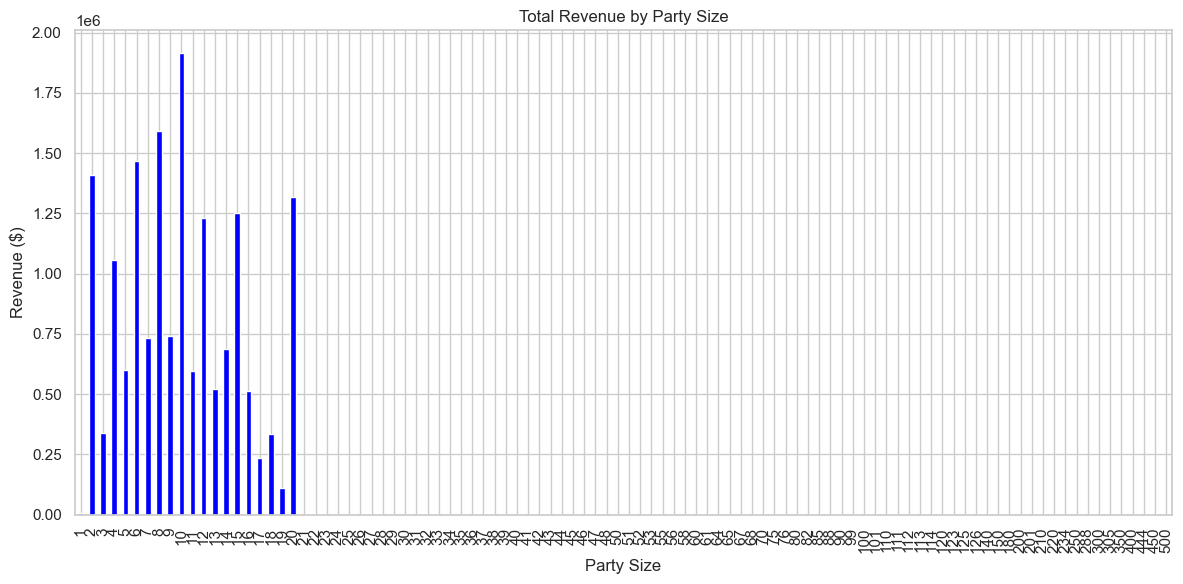

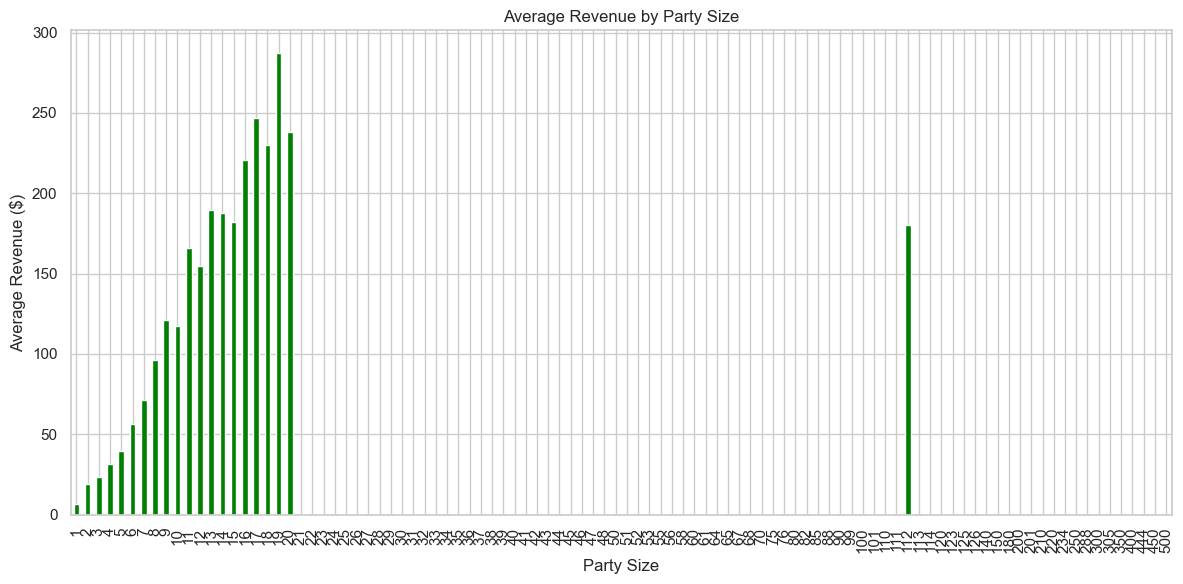

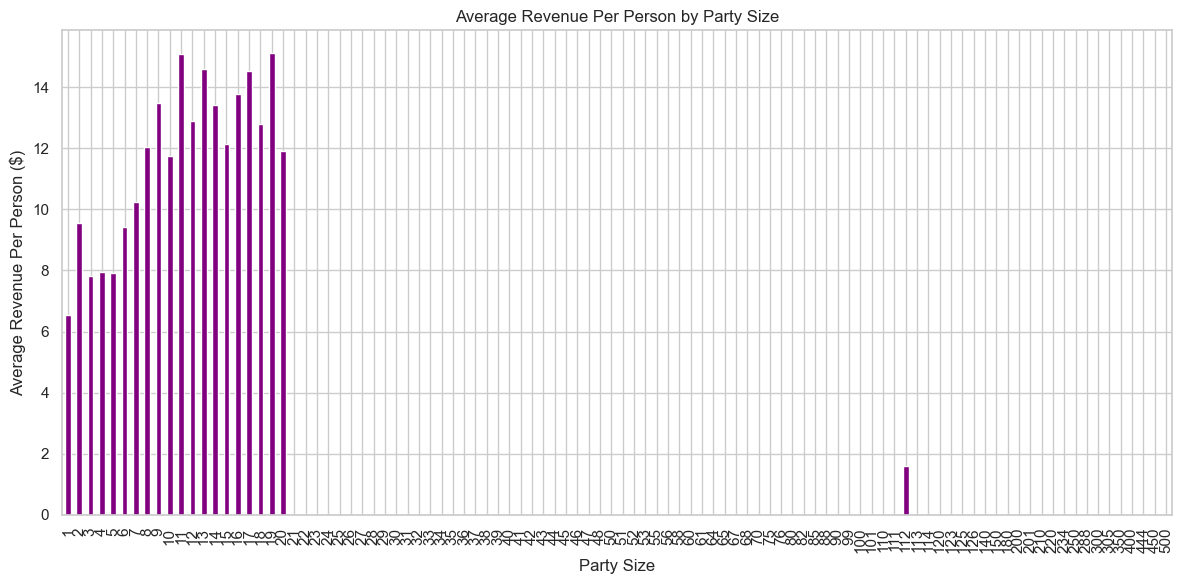

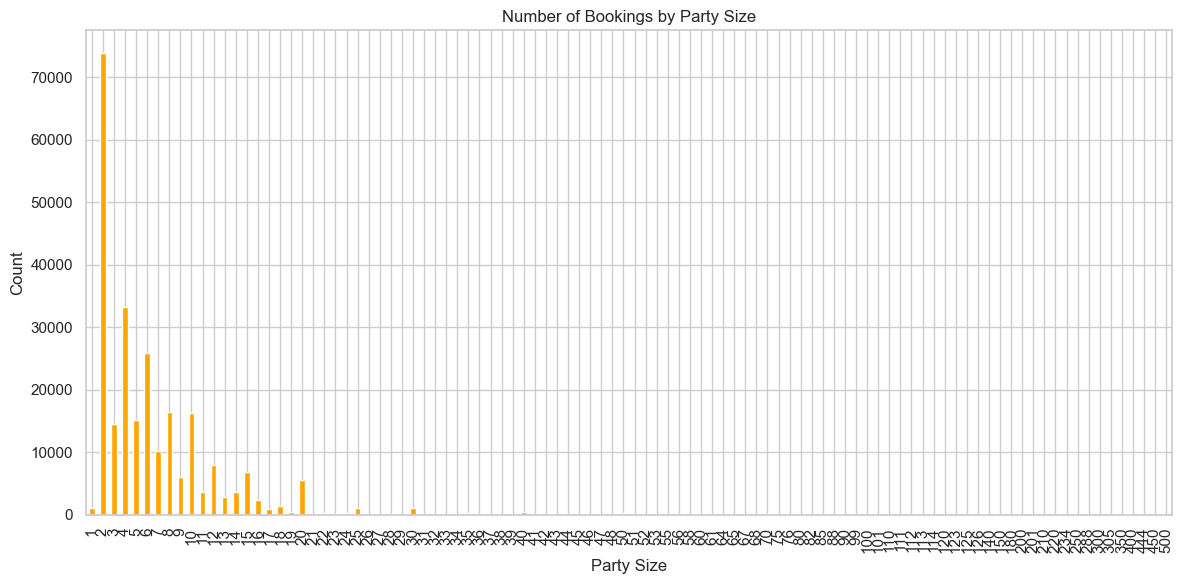

In [19]:
print("\n--- Revenue Analysis by Party Size ---")
if 'Party Size' in df_clean.columns and 'Total Cost ($)' in df_clean.columns:
    try:
        # Group by party size
        party_size_revenue = df_clean.groupby('Party Size')['Total Cost ($)'].agg(['sum', 'mean', 'count'])
        party_size_revenue.columns = ['Total Revenue ($)', 'Average Revenue ($)', 'Number of Bookings']
        
        # Calculate revenue per person
        party_size_revenue['Average Revenue Per Person ($)'] = party_size_revenue['Average Revenue ($)'] / party_size_revenue.index
        
        # Sort by party size
        party_size_revenue = party_size_revenue.sort_index()
        
        print("Revenue by Party Size:")
        print(party_size_revenue)
        
        # Plot total revenue by party size
        plt.figure(figsize=(12, 6))
        party_size_revenue['Total Revenue ($)'].plot(kind='bar', color='blue')
        plt.title('Total Revenue by Party Size')
        plt.xlabel('Party Size')
        plt.ylabel('Revenue ($)')
        plt.tight_layout()
        plt.show()
        
        # Plot average revenue by party size
        plt.figure(figsize=(12, 6))
        party_size_revenue['Average Revenue ($)'].plot(kind='bar', color='green')
        plt.title('Average Revenue by Party Size')
        plt.xlabel('Party Size')
        plt.ylabel('Average Revenue ($)')
        plt.tight_layout()
        plt.show()
        
        # Plot average revenue per person by party size
        plt.figure(figsize=(12, 6))
        party_size_revenue['Average Revenue Per Person ($)'].plot(kind='bar', color='purple')
        plt.title('Average Revenue Per Person by Party Size')
        plt.xlabel('Party Size')
        plt.ylabel('Average Revenue Per Person ($)')
        plt.tight_layout()
        plt.show()
        
        # Plot number of bookings by party size
        plt.figure(figsize=(12, 6))
        party_size_revenue['Number of Bookings'].plot(kind='bar', color='orange')
        plt.title('Number of Bookings by Party Size')
        plt.xlabel('Party Size')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not perform party size revenue analysis: {e}")

# 13.4 Revenue Analysis by Booking Lead Time


--- Revenue Analysis by Booking Lead Time ---
Revenue by Booking Lead Time:
                    Total Revenue ($)  Average Revenue ($)  Number of Bookings
Lead Time Category                                                            
Same day                     442283.0            18.632641               23737
1-7 days                    3468609.4            43.187566               80315
8-14 days                   2933116.0            81.523000               35979
15-30 days                  4403545.0            90.581828               48614
31-60 days                  3741814.0            86.374137               43321
61-90 days                  1080423.0            74.352970               14531
90+ days                     584577.0            85.790578                6814


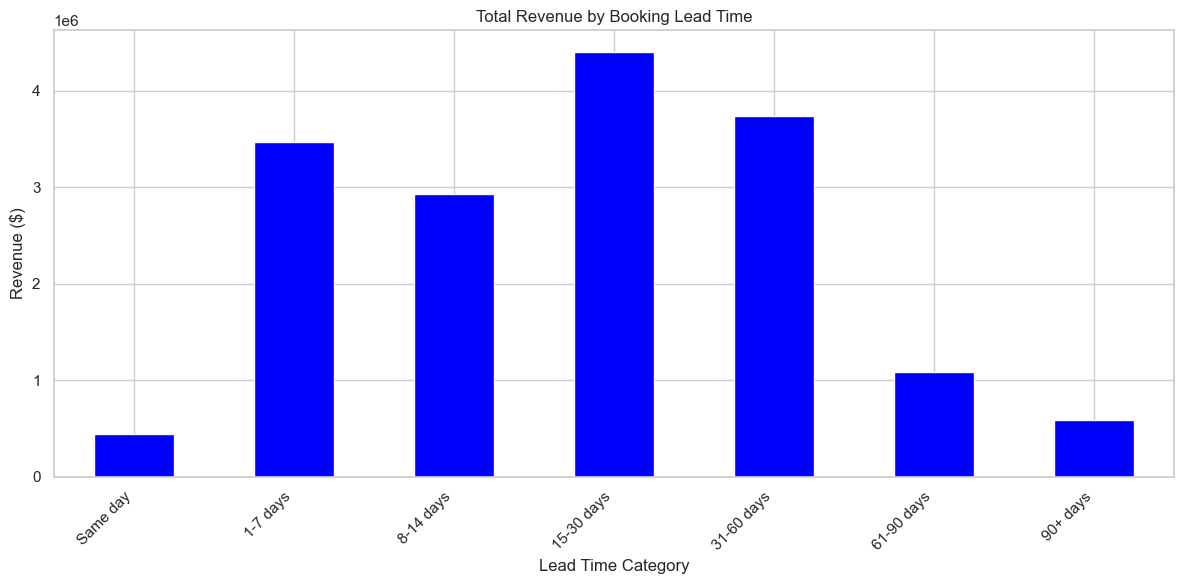

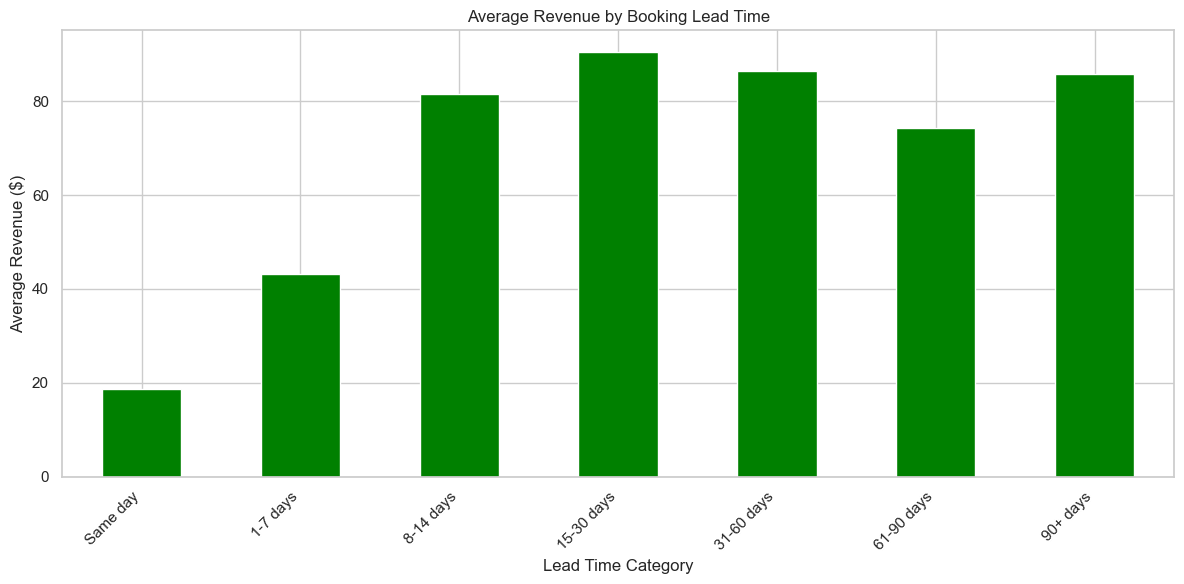

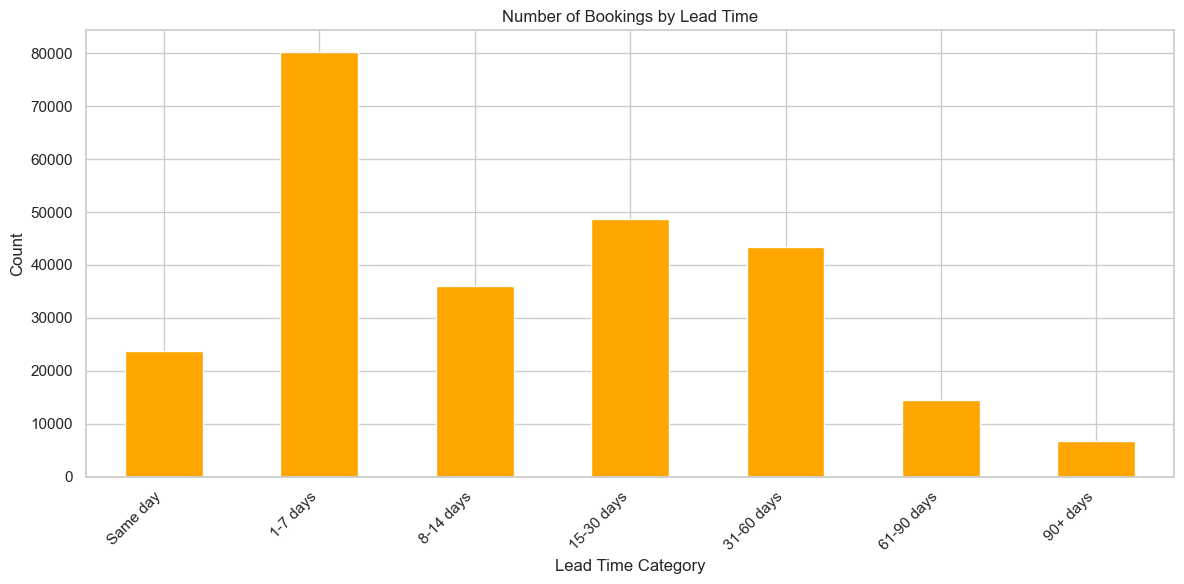

In [20]:
print("\n--- Revenue Analysis by Booking Lead Time ---")
if 'Search Days Ahead' in df_clean.columns and 'Total Cost ($)' in df_clean.columns:
    try:
        # Create lead time bins
        bins = [-1, 0, 7, 14, 30, 60, 90, 365]
        labels = ['Same day', '1-7 days', '8-14 days', '15-30 days', '31-60 days', '61-90 days', '90+ days']
        
        df_clean['Lead Time Category'] = pd.cut(df_clean['Search Days Ahead'], bins=bins, labels=labels)
        
        # Group by lead time category
        lead_time_revenue = df_clean.groupby('Lead Time Category')['Total Cost ($)'].agg(['sum', 'mean', 'count'])
        lead_time_revenue.columns = ['Total Revenue ($)', 'Average Revenue ($)', 'Number of Bookings']
        
        print("Revenue by Booking Lead Time:")
        print(lead_time_revenue)
        
        # Plot total revenue by lead time
        plt.figure(figsize=(12, 6))
        lead_time_revenue['Total Revenue ($)'].plot(kind='bar', color='blue')
        plt.title('Total Revenue by Booking Lead Time')
        plt.ylabel('Revenue ($)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Plot average revenue by lead time
        plt.figure(figsize=(12, 6))
        lead_time_revenue['Average Revenue ($)'].plot(kind='bar', color='green')
        plt.title('Average Revenue by Booking Lead Time')
        plt.ylabel('Average Revenue ($)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Plot number of bookings by lead time
        plt.figure(figsize=(12, 6))
        lead_time_revenue['Number of Bookings'].plot(kind='bar', color='orange')
        plt.title('Number of Bookings by Lead Time')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not perform lead time revenue analysis: {e}")

# 13.5 Analysis of Booking Status


--- Analysis of Booking Status ---
Booking Status Distribution:
Booking Status
Unknown                 116785
draft                   109024
reservation_success      20037
payment_inititalised      6684
payment_failure            769
reservation_failure         54
Name: count, dtype: int64

Reservation Success Rate: 7.91%


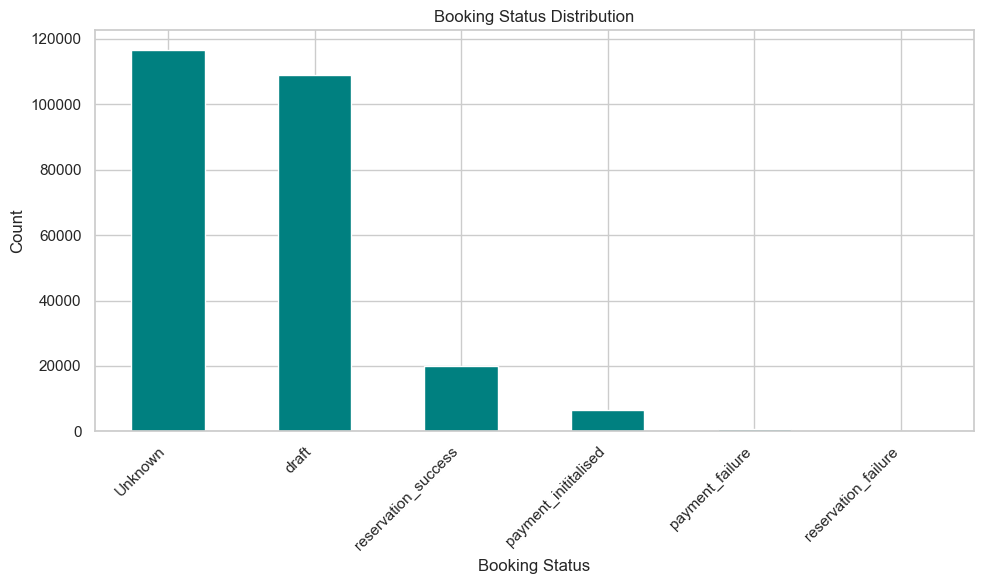


Reservation Success Rate by Venue:
                    Success Rate (%)
Clays Birmingham            6.647693
Clays Canary Wharf          8.126804
Clays, The City             7.979702


<Figure size 1000x600 with 0 Axes>

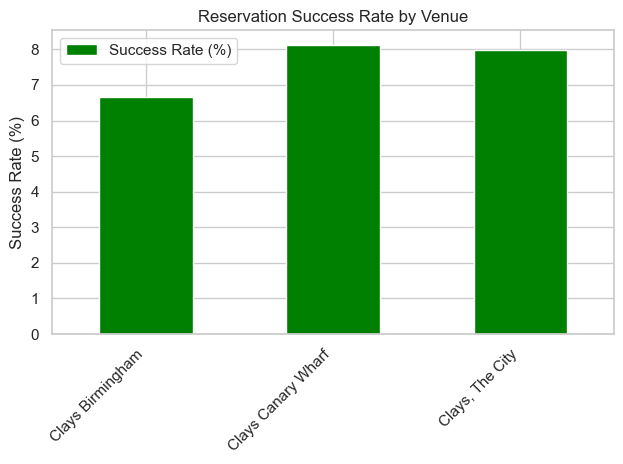

In [21]:
print("\n--- Analysis of Booking Status ---")
if 'Booking Status' in df_clean.columns:
    try:
        # Count by booking status
        booking_status_counts = df_clean['Booking Status'].value_counts()
        
        print("Booking Status Distribution:")
        print(booking_status_counts)
        
        # Calculate success rate
        total_bookings = booking_status_counts.sum()
        success_rate = booking_status_counts.get('reservation_success', 0) / total_bookings * 100
        
        print(f"\nReservation Success Rate: {success_rate:.2f}%")
        
        # Plot booking status distribution
        plt.figure(figsize=(10, 6))
        booking_status_counts.plot(kind='bar', color='teal')
        plt.title('Booking Status Distribution')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Analyze booking status by venue
        if 'Venue Name' in df_clean.columns:
            status_by_venue = pd.crosstab(df_clean['Venue Name'], df_clean['Booking Status'])
            
            # Calculate success rate by venue
            success_rate_by_venue = {}
            for venue in status_by_venue.index:
                total = status_by_venue.loc[venue].sum()
                success = status_by_venue.loc[venue].get('reservation_success', 0)
                success_rate_by_venue[venue] = (success / total) * 100
            
            success_rate_df = pd.DataFrame.from_dict(success_rate_by_venue, orient='index', columns=['Success Rate (%)'])
            
            print("\nReservation Success Rate by Venue:")
            print(success_rate_df)
            
            # Plot success rate by venue
            plt.figure(figsize=(10, 6))
            success_rate_df.plot(kind='bar', color='green')
            plt.title('Reservation Success Rate by Venue')
            plt.ylabel('Success Rate (%)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"Could not perform booking status analysis: {e}")

# 13.6 Packages and Add-ons Analysis


--- Packages and Add-ons Analysis ---
Total Packages Revenue: $7,393,912.00
Total Add-ons Revenue: $154,437.00
Percentage of Bookings with Packages: 17.81%
Percentage of Bookings with Add-ons: 2.37%


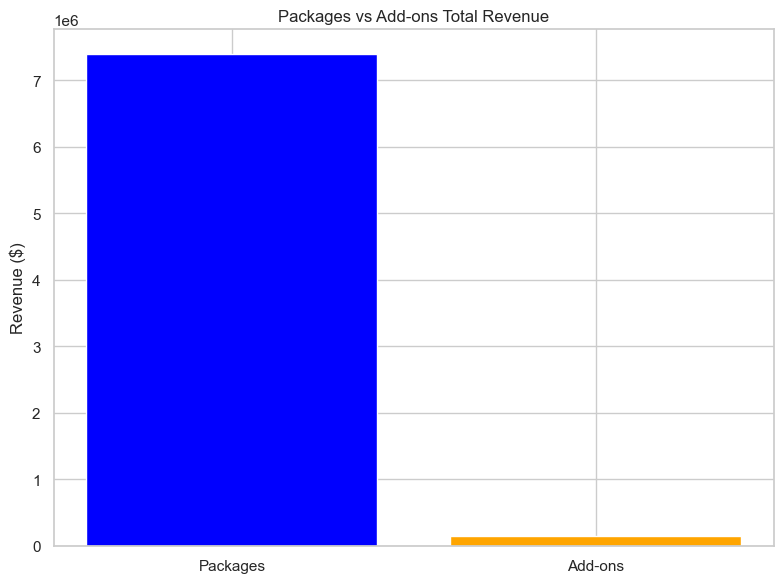

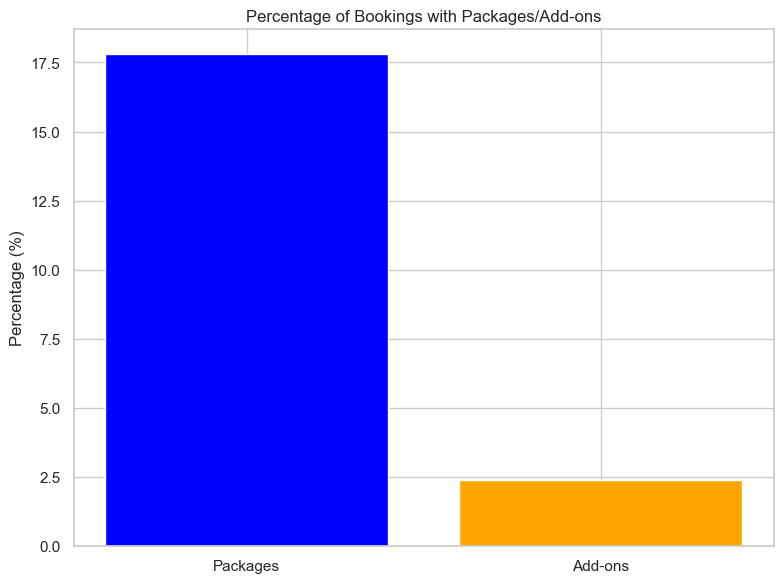


Packages Analysis by Venue:
                    Total Packages Revenue ($)  Average Package Cost ($)  \
Venue Name                                                                 
Clays Birmingham                        401032                 16.305428   
Clays Canary Wharf                     2727001                 27.142441   
Clays, The City                        4265879                 33.252362   

                    Bookings with Packages (%)  
Venue Name                                      
Clays Birmingham                     17.511689  
Clays Canary Wharf                   17.917786  
Clays, The City                      17.774850  


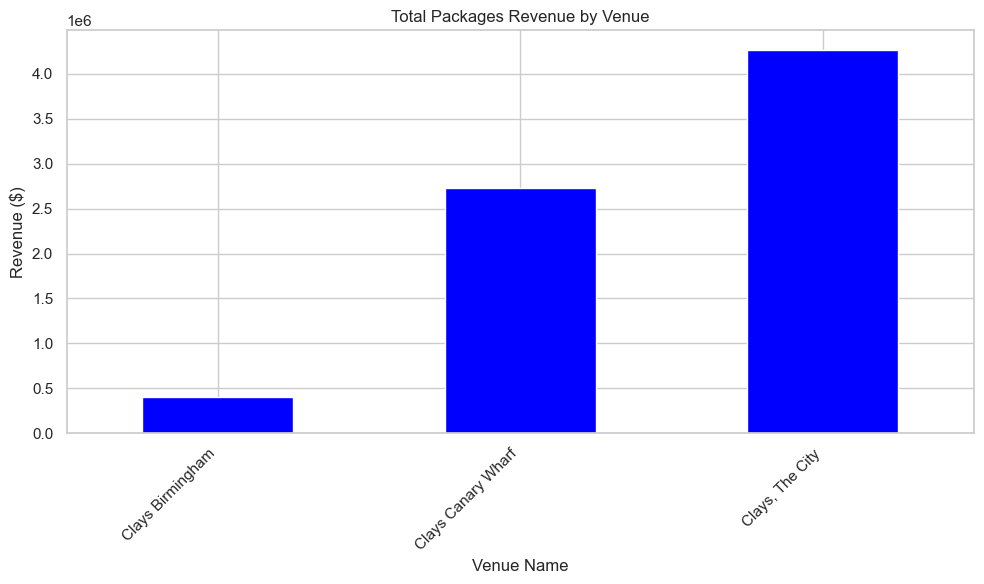

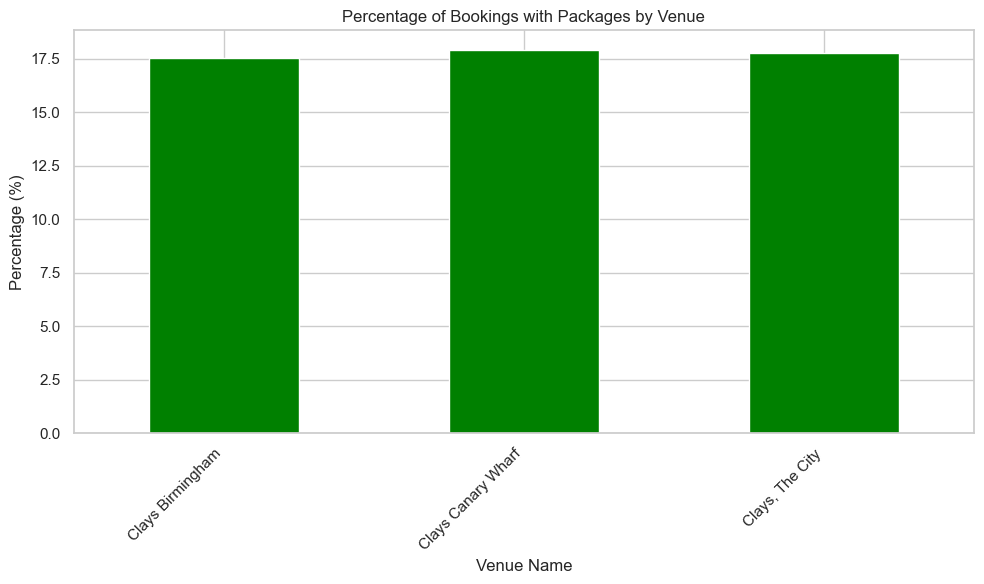

In [22]:
print("\n--- Packages and Add-ons Analysis ---")
if 'Packages Cost ($)' in df_clean.columns and 'Add Ons Cost ($)' in df_clean.columns:
    try:
        # Calculate packages and add-ons metrics
        packages_total = df_clean['Packages Cost ($)'].sum()
        addons_total = df_clean['Add Ons Cost ($)'].sum()
        
        # Calculate % of bookings with packages/add-ons
        packages_pct = (df_clean['Packages Cost ($)'] > 0).mean() * 100
        addons_pct = (df_clean['Add Ons Cost ($)'] > 0).mean() * 100
        
        print(f"Total Packages Revenue: ${packages_total:,.2f}")
        print(f"Total Add-ons Revenue: ${addons_total:,.2f}")
        print(f"Percentage of Bookings with Packages: {packages_pct:.2f}%")
        print(f"Percentage of Bookings with Add-ons: {addons_pct:.2f}%")
        
        # Plot packages vs add-ons total revenue
        plt.figure(figsize=(8, 6))
        plt.bar(['Packages', 'Add-ons'], [packages_total, addons_total], color=['blue', 'orange'])
        plt.title('Packages vs Add-ons Total Revenue')
        plt.ylabel('Revenue ($)')
        plt.tight_layout()
        plt.show()
        
        # Plot % of bookings with packages/add-ons
        plt.figure(figsize=(8, 6))
        plt.bar(['Packages', 'Add-ons'], [packages_pct, addons_pct], color=['blue', 'orange'])
        plt.title('Percentage of Bookings with Packages/Add-ons')
        plt.ylabel('Percentage (%)')
        plt.tight_layout()
        plt.show()
        
        # Analyze packages by venue if available
        if 'Venue Name' in df_clean.columns:
            packages_by_venue = df_clean.groupby('Venue Name')['Packages Cost ($)'].agg(['sum', 'mean'])
            packages_by_venue.columns = ['Total Packages Revenue ($)', 'Average Package Cost ($)']
            
            # Calculate % of bookings with packages by venue
            packages_pct_by_venue = df_clean.groupby('Venue Name').apply(
                lambda x: (x['Packages Cost ($)'] > 0).mean() * 100
            ).to_frame('Bookings with Packages (%)')
            
            packages_venue_df = pd.concat([packages_by_venue, packages_pct_by_venue], axis=1)
            
            print("\nPackages Analysis by Venue:")
            print(packages_venue_df)
            
            # Plot total packages revenue by venue
            plt.figure(figsize=(10, 6))
            packages_venue_df['Total Packages Revenue ($)'].plot(kind='bar', color='blue')
            plt.title('Total Packages Revenue by Venue')
            plt.ylabel('Revenue ($)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            
            # Plot % of bookings with packages by venue
            plt.figure(figsize=(10, 6))
            packages_venue_df['Bookings with Packages (%)'].plot(kind='bar', color='green')
            plt.title('Percentage of Bookings with Packages by Venue')
            plt.ylabel('Percentage (%)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"Could not perform packages and add-ons analysis: {e}")

# 13.7 Promo Code Effectiveness Analysis


--- Promo Code Effectiveness Analysis ---
Total Promo Discount: $15,987.60
Average Discount (when used): $25.34
Number of Bookings with Promo: 631
Percentage of Bookings with Promo: 0.25%

Revenue Comparison by Promo Usage:
           Average Revenue ($)   Count
Has Promo                             
False                65.675094  252722
True                 91.636133     631


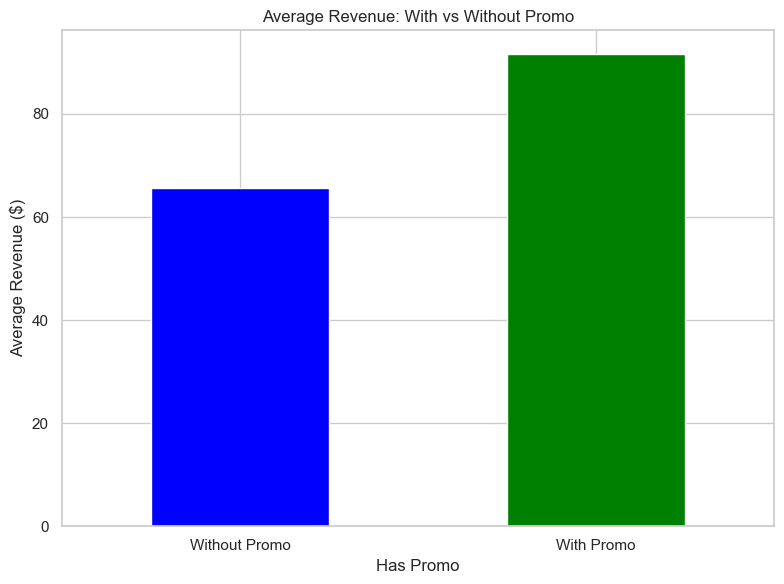

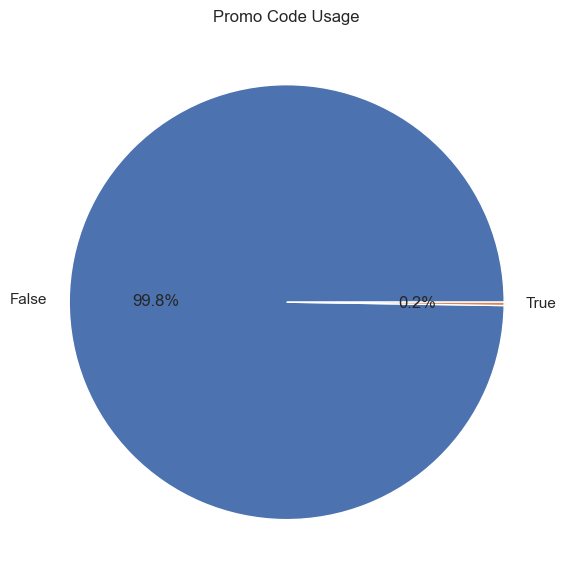


Promo Usage by Venue:
                    Bookings with Promo (%)
Venue Name                                 
Clays Birmingham                   0.207359
Clays Canary Wharf                 0.264756
Clays, The City                    0.244762


<Figure size 1000x600 with 0 Axes>

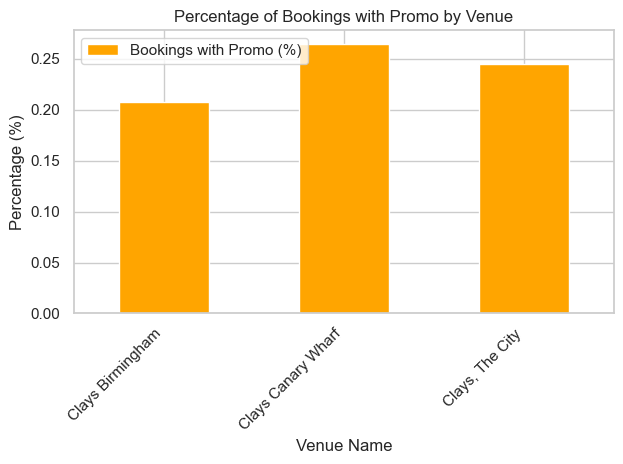

In [23]:
print("\n--- Promo Code Effectiveness Analysis ---")
if 'Promo Code Discount ($)' in df_clean.columns:
    try:
        # Calculate basic promo metrics
        total_discount = df_clean['Promo Code Discount ($)'].sum()
        avg_discount = df_clean[df_clean['Promo Code Discount ($)'] > 0]['Promo Code Discount ($)'].mean()
        promo_count = (df_clean['Promo Code Discount ($)'] > 0).sum()
        promo_pct = (df_clean['Promo Code Discount ($)'] > 0).mean() * 100
        
        print(f"Total Promo Discount: ${total_discount:,.2f}")
        print(f"Average Discount (when used): ${avg_discount:.2f}")
        print(f"Number of Bookings with Promo: {promo_count}")
        print(f"Percentage of Bookings with Promo: {promo_pct:.2f}%")
        
        # Create a column for promo usage
        df_clean['Has Promo'] = df_clean['Promo Code Discount ($)'] > 0
        
        # Compare revenue with and without promo
        promo_comparison = df_clean.groupby('Has Promo')['Total Cost ($)'].agg(['mean', 'count'])
        promo_comparison.columns = ['Average Revenue ($)', 'Count']
        
        print("\nRevenue Comparison by Promo Usage:")
        print(promo_comparison)
        
        # Plot average revenue with vs without promo
        plt.figure(figsize=(8, 6))
        promo_comparison['Average Revenue ($)'].plot(kind='bar', color=['blue', 'green'])
        plt.title('Average Revenue: With vs Without Promo')
        plt.ylabel('Average Revenue ($)')
        plt.xticks([0, 1], ['Without Promo', 'With Promo'], rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Plot promo usage distribution
        plt.figure(figsize=(8, 6))
        df_clean['Has Promo'].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title('Promo Code Usage')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
        
        # Analyze promo usage by venue if available
        if 'Venue Name' in df_clean.columns:
            promo_by_venue = df_clean.groupby('Venue Name').apply(
                lambda x: (x['Promo Code Discount ($)'] > 0).mean() * 100
            ).to_frame('Bookings with Promo (%)')
            
            print("\nPromo Usage by Venue:")
            print(promo_by_venue)
            
            # Plot % of bookings with promo by venue
            plt.figure(figsize=(10, 6))
            promo_by_venue.plot(kind='bar', color='orange')
            plt.title('Percentage of Bookings with Promo by Venue')
            plt.ylabel('Percentage (%)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"Could not perform promo code analysis: {e}")

# 13.8 Top Booking Days and Hours


--- Top Booking Days and Hours ---
Bookings by Day of Week:
Search Day
Monday       8569
Tuesday      8371
Wednesday    8178
Thursday     8161
Friday       7392
Saturday     5148
Sunday       5651
Name: count, dtype: int64

Bookings by Hour of Day:
Search Hour
0.0      280
1.0      151
2.0       89
3.0       53
4.0       93
5.0      322
6.0      763
7.0     1514
8.0     2765
9.0     3480
10.0    3752
11.0    3604
12.0    3702
13.0    3659
14.0    3789
15.0    3699
16.0    3308
17.0    2945
18.0    2869
19.0    3248
20.0    2971
21.0    2365
22.0    1409
23.0     640
Name: count, dtype: int64


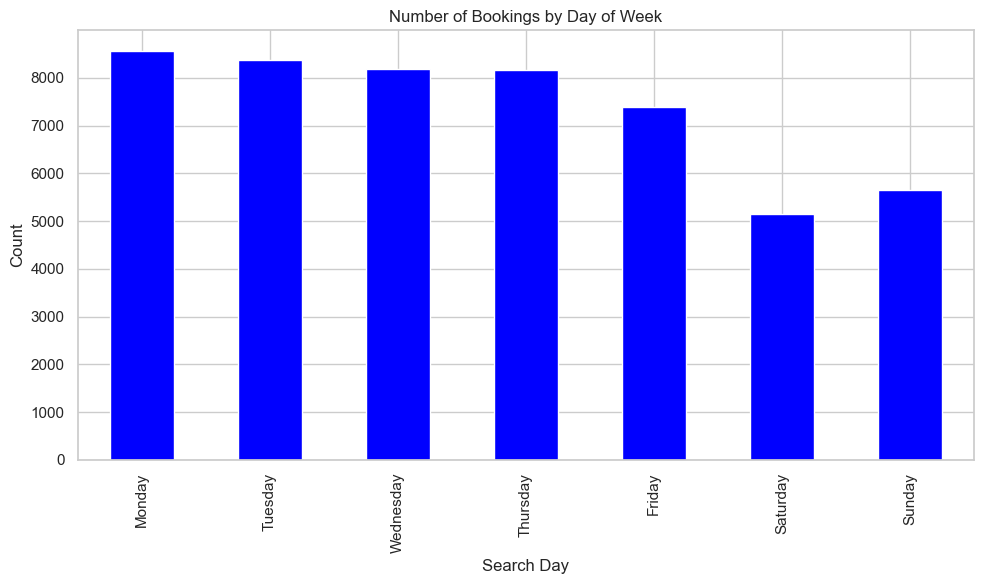

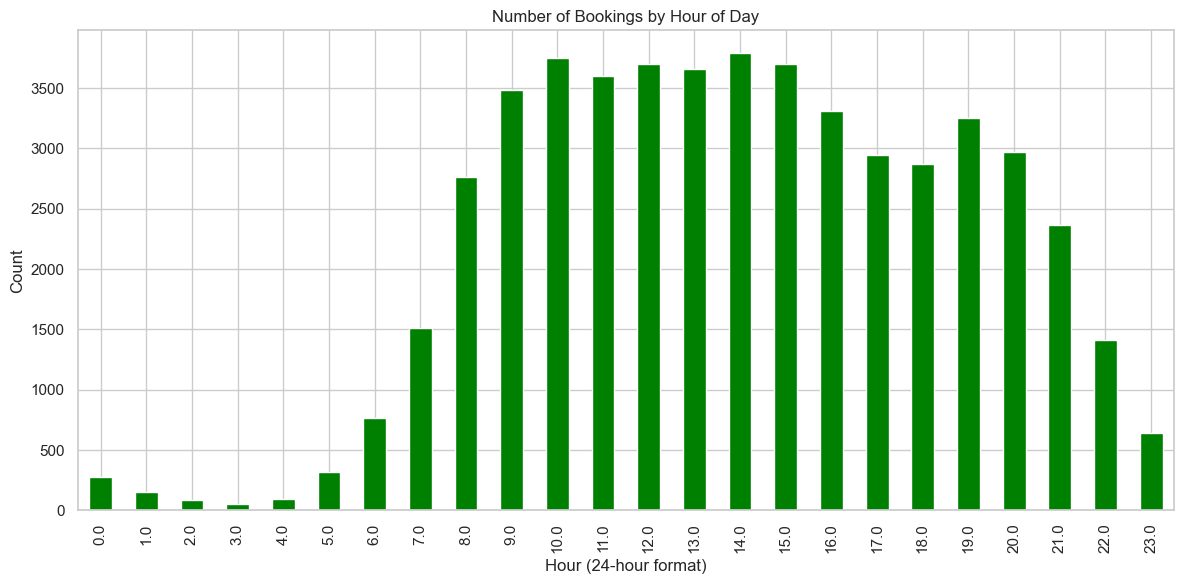

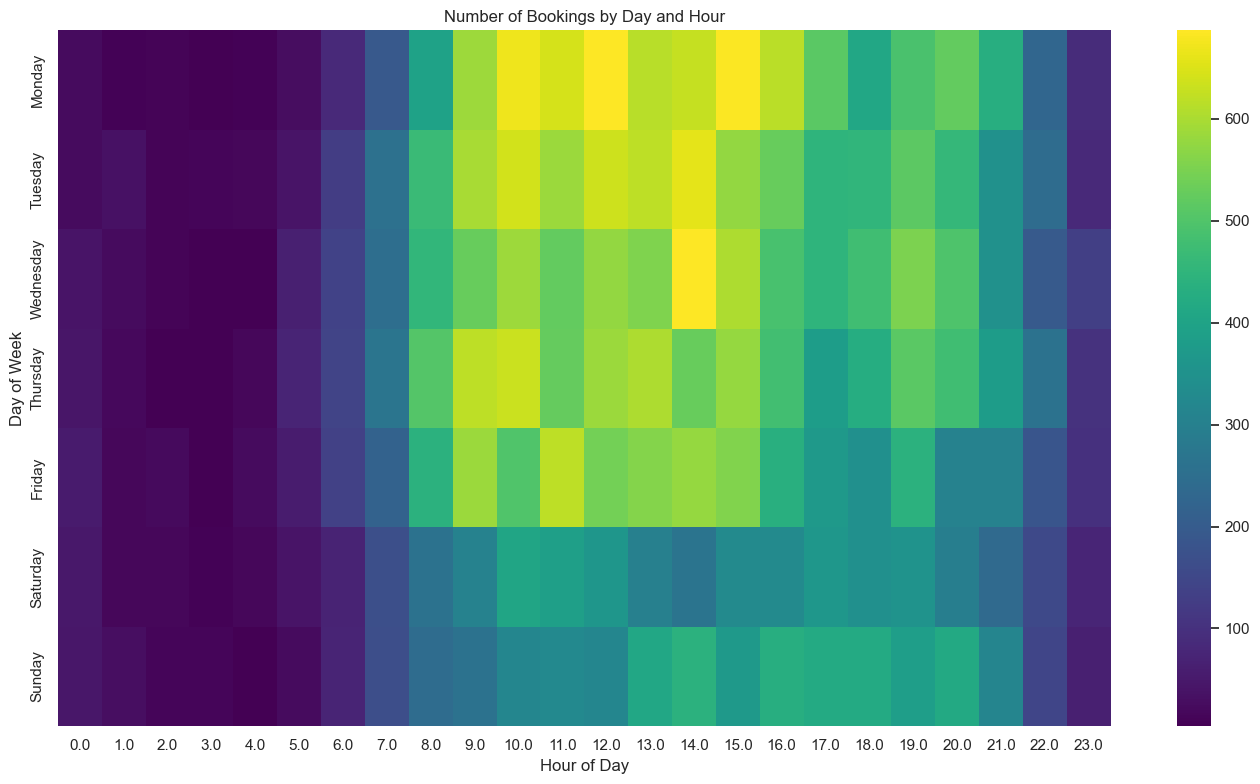


Top 5 Booking Hours:
Could not perform day/hour analysis: Unknown format code 'd' for object of type 'float'

Business-focused EDA complete! Key revenue metrics and patterns have been analyzed.


In [24]:
print("\n--- Top Booking Days and Hours ---")
if 'Search At' in df_clean.columns:
    try:
        # Extract day and hour
        df_clean['Search Day'] = df_clean['Search At'].dt.day_name()
        df_clean['Search Hour'] = df_clean['Search At'].dt.hour
        
        # Count bookings by day
        day_counts = df_clean['Search Day'].value_counts()
        
        # Reindex to get proper day order
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = day_counts.reindex(day_order)
        
        print("Bookings by Day of Week:")
        print(day_counts)
        
        # Count bookings by hour
        hour_counts = df_clean['Search Hour'].value_counts().sort_index()
        
        print("\nBookings by Hour of Day:")
        print(hour_counts)
        
        # Plot bookings by day
        plt.figure(figsize=(10, 6))
        day_counts.plot(kind='bar', color='blue')
        plt.title('Number of Bookings by Day of Week')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        
        # Plot bookings by hour
        plt.figure(figsize=(12, 6))
        hour_counts.plot(kind='bar', color='green')
        plt.title('Number of Bookings by Hour of Day')
        plt.xlabel('Hour (24-hour format)')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        
        # Create day-hour heatmap
        day_hour_counts = df_clean.groupby(['Search Day', 'Search Hour']).size().unstack(fill_value=0)
        
        # Reindex to get proper day order
        day_hour_counts = day_hour_counts.reindex(day_order)
        
        plt.figure(figsize=(14, 8))
        sns.heatmap(day_hour_counts, cmap='viridis', annot=False)
        plt.title('Number of Bookings by Day and Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Day of Week')
        plt.tight_layout()
        plt.show()
        
        # Find top 5 booking hours
        top_hours = hour_counts.nlargest(5)
        print("\nTop 5 Booking Hours:")
        for hour, count in top_hours.items():
            print(f"{hour:02d}:00 - {hour:02d}:59: {count} bookings")
        
        # Find top day-hour combinations
        day_hour_flat = day_hour_counts.stack().nlargest(5)
        print("\nTop 5 Day-Hour Combinations:")
        for (day, hour), count in day_hour_flat.items():
            print(f"{day} at {hour:02d}:00 - {hour:02d}:59: {count} bookings")
        
    except Exception as e:
        print(f"Could not perform day/hour analysis: {e}")

print("\nBusiness-focused EDA complete! Key revenue metrics and patterns have been analyzed.")

# 13.9 Pre‑model data sanity checks

In [25]:
# Make a copy for our analysis
df_clean = df.copy()

print("\n" + "="*80)
print("13.9. PRE-MODEL DATA SANITY CHECKS")
print("="*80)

# Convert date columns to datetime
print("\nConverting date columns to datetime...")
date_columns = [col for col in df_clean.columns if 'Date' in col or 'At' in col]
for col in date_columns:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        print(f"✓ Converted {col} to datetime")
    except Exception as e:
        print(f"✗ Could not convert {col}: {str(e)}")

# Check data types
print("\nData types check:")
print(df_clean.dtypes.value_counts())

# Check for duplicates
print("\nChecking for duplicates...")
duplicates = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    # Find and show example duplicates
    duplicate_rows = df_clean[df_clean.duplicated(keep=False)]
    print(f"\nExample duplicate rows:\n{duplicate_rows.head()}")
else:
    print("No duplicates found.")

# Check for near-duplicates (same booking ID but slightly different data)
if 'Booking ID' in df_clean.columns:
    print("\nChecking for near-duplicates (same Booking ID)...")
    booking_counts = df_clean['Booking ID'].value_counts()
    potential_near_duplicates = booking_counts[booking_counts > 1]
    
    if len(potential_near_duplicates) > 0:
        print(f"Found {len(potential_near_duplicates)} Booking IDs with multiple entries")
        print("Example of first potential near-duplicate:")
        example_id = potential_near_duplicates.index[0]
        print(df_clean[df_clean['Booking ID'] == example_id].head())
    else:
        print("No near-duplicates found based on Booking ID.")

# Check for target leakage
print("\nChecking for potential target leakage...")
if 'Booking Status' in df_clean.columns:
    # Ensure time features don't include information from after the booking decision
    timestamp_cols = [col for col in df_clean.columns if ('Time' in col or 'Date' in col or 'At' in col) 
                      and 'Search' not in col]
    
    print(f"Potential leakage columns to be careful with: {timestamp_cols}")
    print("Make sure these are only used if they represent data available at prediction time.")

# Check for valid values in key fields
print("\nValidating key fields:")

# Check Price Fields
price_fields = [col for col in df_clean.columns if 'Cost' in col or 'Price' in col or 'Amount' in col]
for col in price_fields:
    if col in df_clean.columns:
        min_val = df_clean[col].min()
        max_val = df_clean[col].max()
        neg_count = (df_clean[col] < 0).sum()
        print(f"{col}: Range [{min_val:.2f} to {max_val:.2f}], Negative values: {neg_count}")
        
        if neg_count > 0:
            print(f"  Warning: {neg_count} negative values in {col}")

# Create time-based features after validation
df_clean['SearchHour'] = df_clean['Search At'].dt.hour
df_clean['SearchDayOfWeek'] = df_clean['Search At'].dt.dayofweek
df_clean['SearchDayName'] = df_clean['Search At'].dt.day_name()
df_clean['SearchMonth'] = df_clean['Search At'].dt.month
df_clean['SearchMonthName'] = df_clean['Search At'].dt.month_name()
df_clean['SearchDate'] = df_clean['Search At'].dt.date
df_clean['SearchWeek'] = df_clean['Search At'].dt.isocalendar().week
df_clean['SearchQuarter'] = df_clean['Search At'].dt.quarter
df_clean['SearchYear'] = df_clean['Search At'].dt.year

# Identify successful bookings
if 'Booking Status' in df_clean.columns:
    df_clean['IsBooked'] = df_clean['Booking Status'] == 'reservation_success'
else:
    # If we don't have booking status, use a proxy - non-zero payment
    df_clean['IsBooked'] = df_clean['Total Cost ($)'] > 0

print("\nTime features created successfully.")

# Summarize missing values by column
print("\nMissing values summary:")
missing = df_clean.isnull().sum()
missing_pct = (missing / len(df_clean)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing Percent': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Percent', ascending=False).head(10))



13.9. PRE-MODEL DATA SANITY CHECKS

Converting date columns to datetime...
✓ Converted Search At to datetime
✓ Converted Search Date to datetime
✓ Converted Reservation Date to datetime
✓ Converted Reservation Datetime to datetime
✓ Converted Personal Info Completed At to datetime

Data types check:
object            23
int64              9
bool               8
float64            6
datetime64[ns]     5
Name: count, dtype: int64

Checking for duplicates...
Number of duplicate rows: 0
No duplicates found.

Checking for near-duplicates (same Booking ID)...
Found 12 Booking IDs with multiple entries
Example of first potential near-duplicate:
                Context ID  Booking ID      Session ID Search At Search Date  \
61356   202410021333VXH7JV  2.0241E+17     31.24.4.101       NaT  2024-09-10   
129895  202410081228P48VR6  2.0241E+17     85.119.97.1       NaT         NaT   
133941  202410091336WQRNH2  2.0241E+17  81.128.224.150       NaT         NaT   
134428  202410091805P9S4K9  2.024

# 14. Segment supply vs demand (time‑series trends & seasonality)


14. SEGMENT SUPPLY VS DEMAND (TIME-SERIES TRENDS & SEASONALITY)

14.1 Weekly/Monthly/Quarterly Trends
--------------------------------------------------
Date range: 2024-04-01 to 2024-12-19


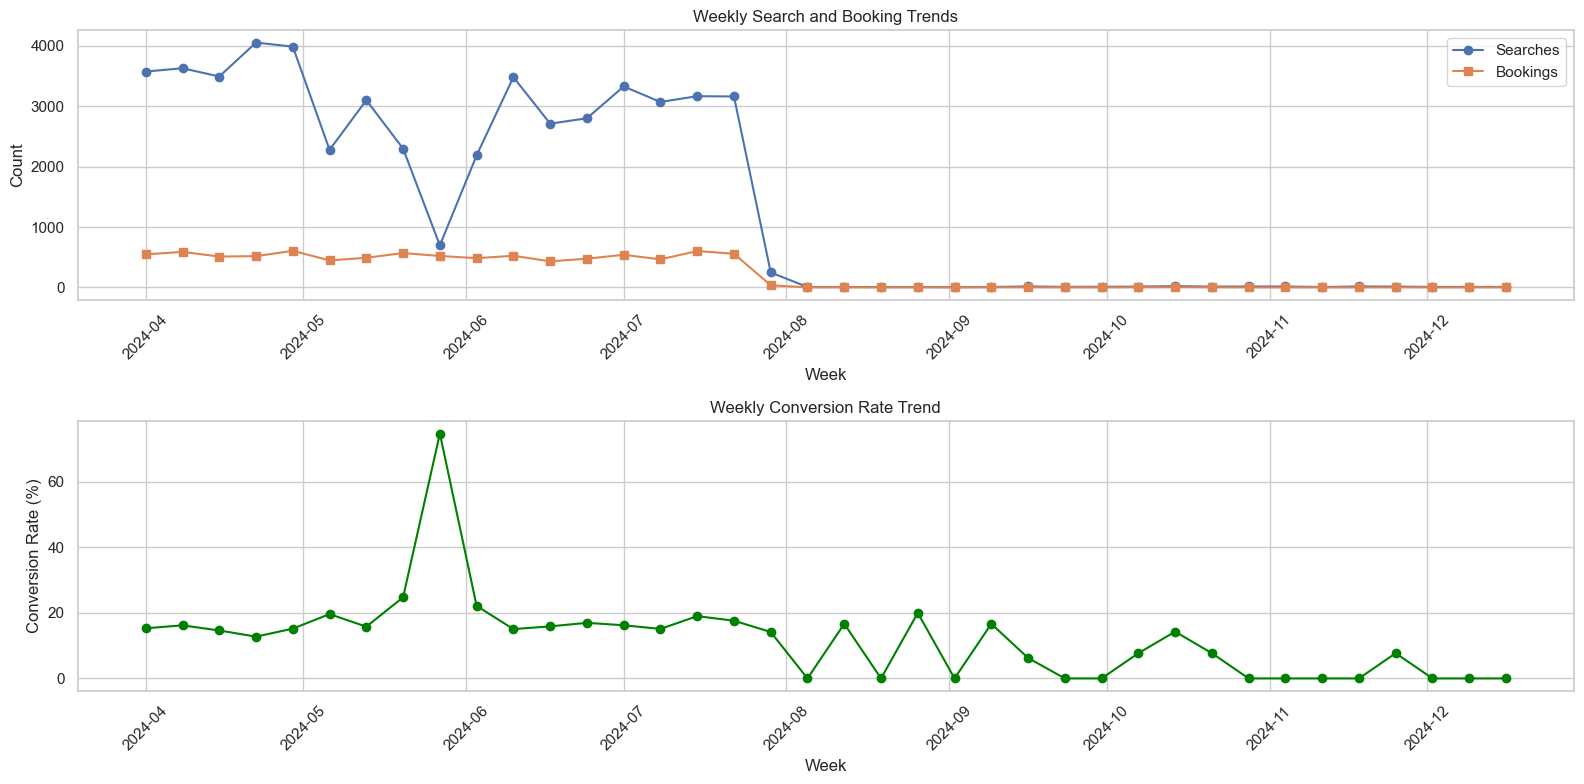

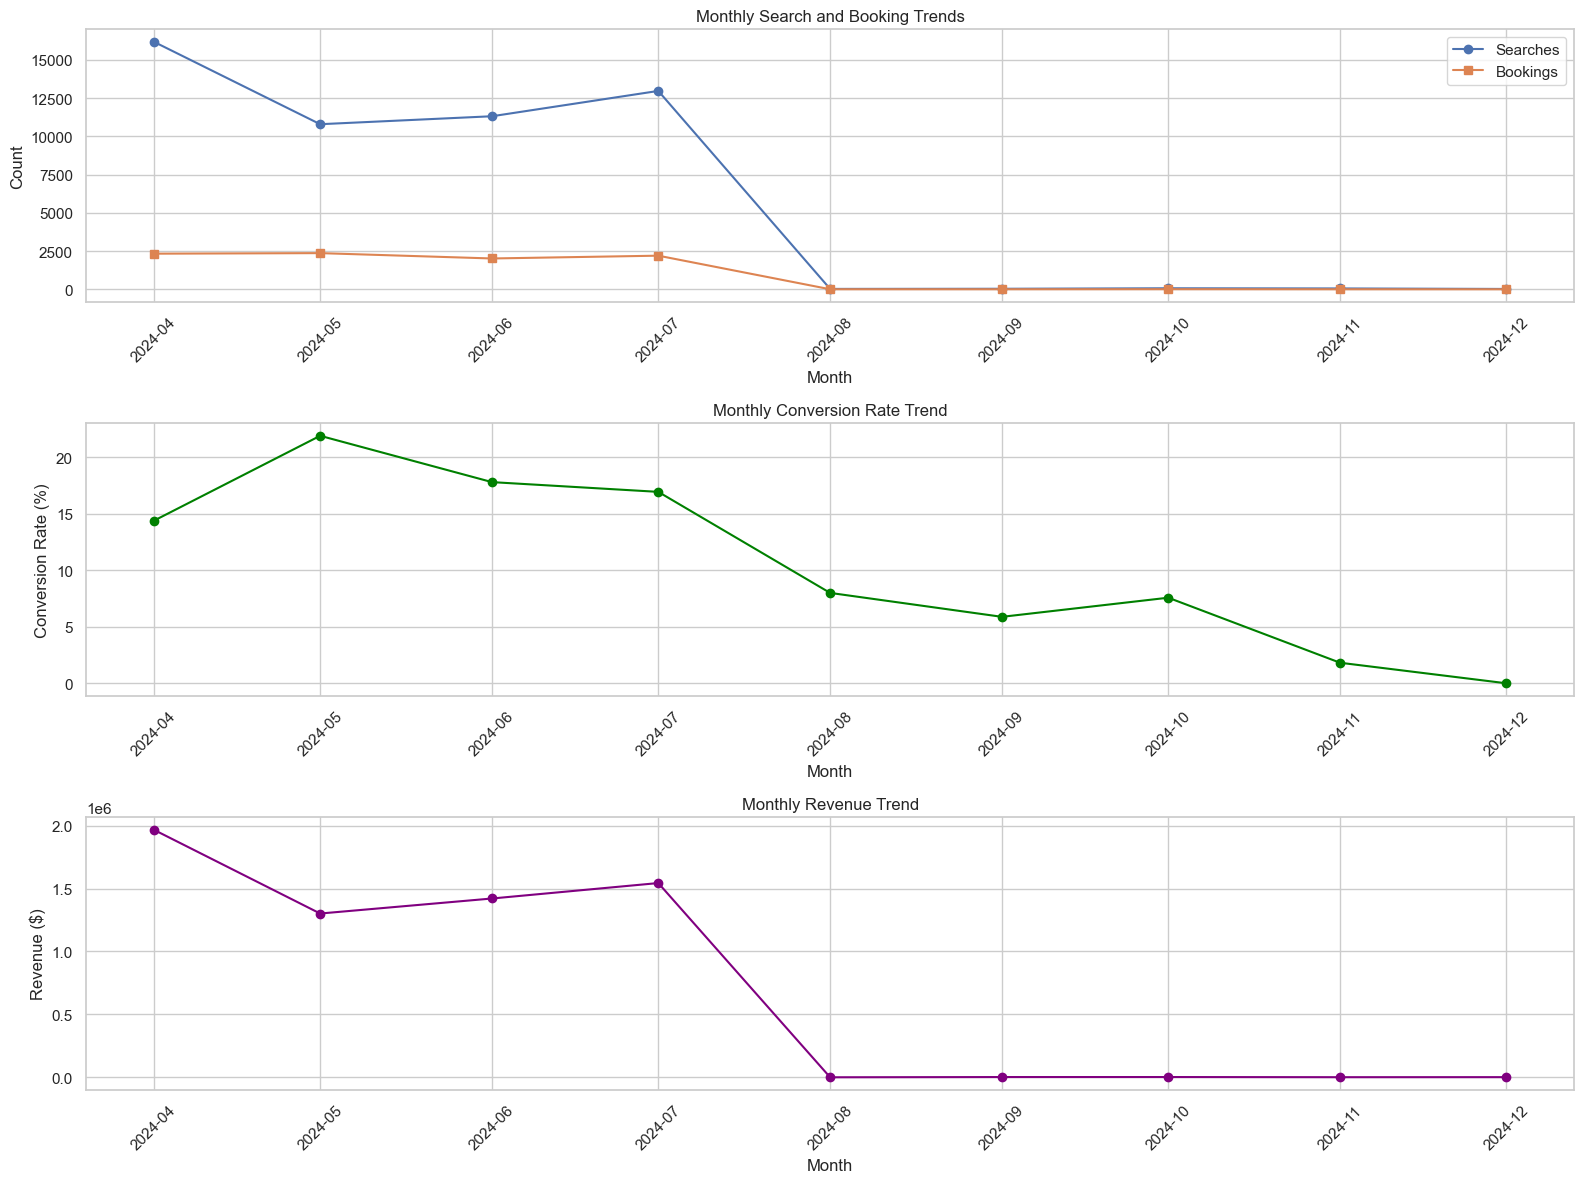

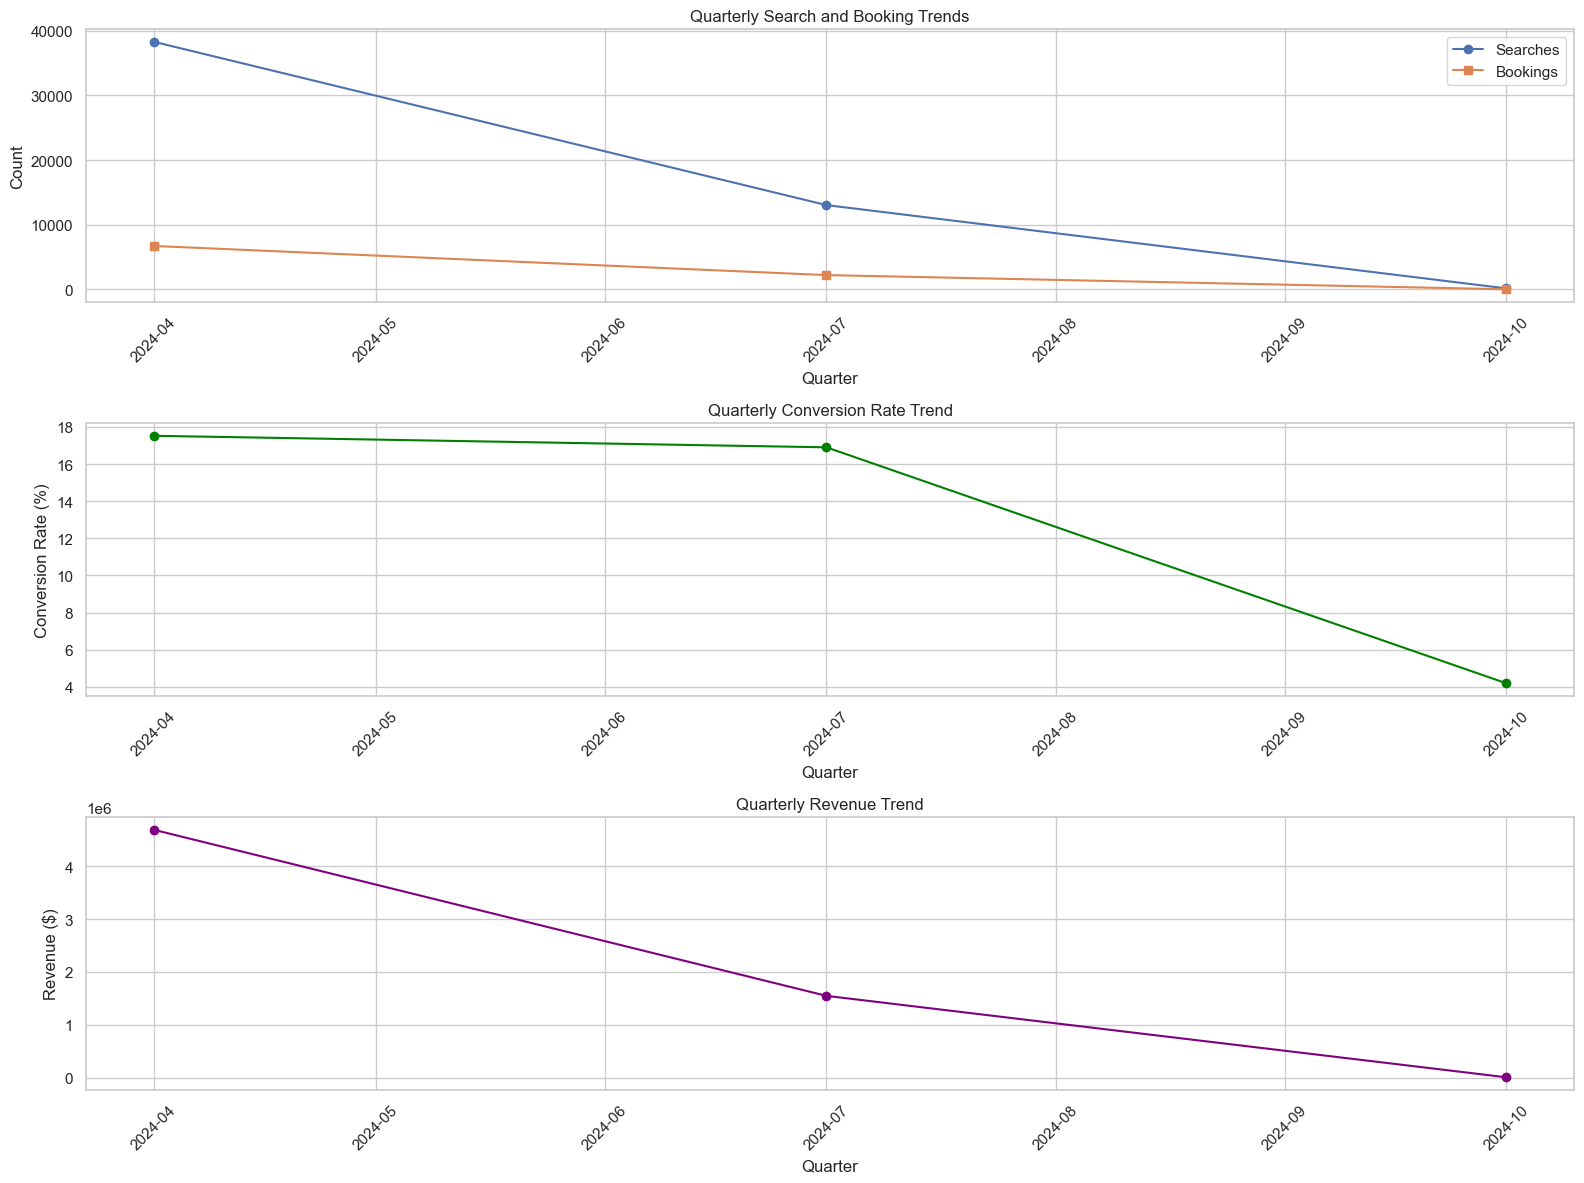


14.2 Hour of Day Analysis
--------------------------------------------------


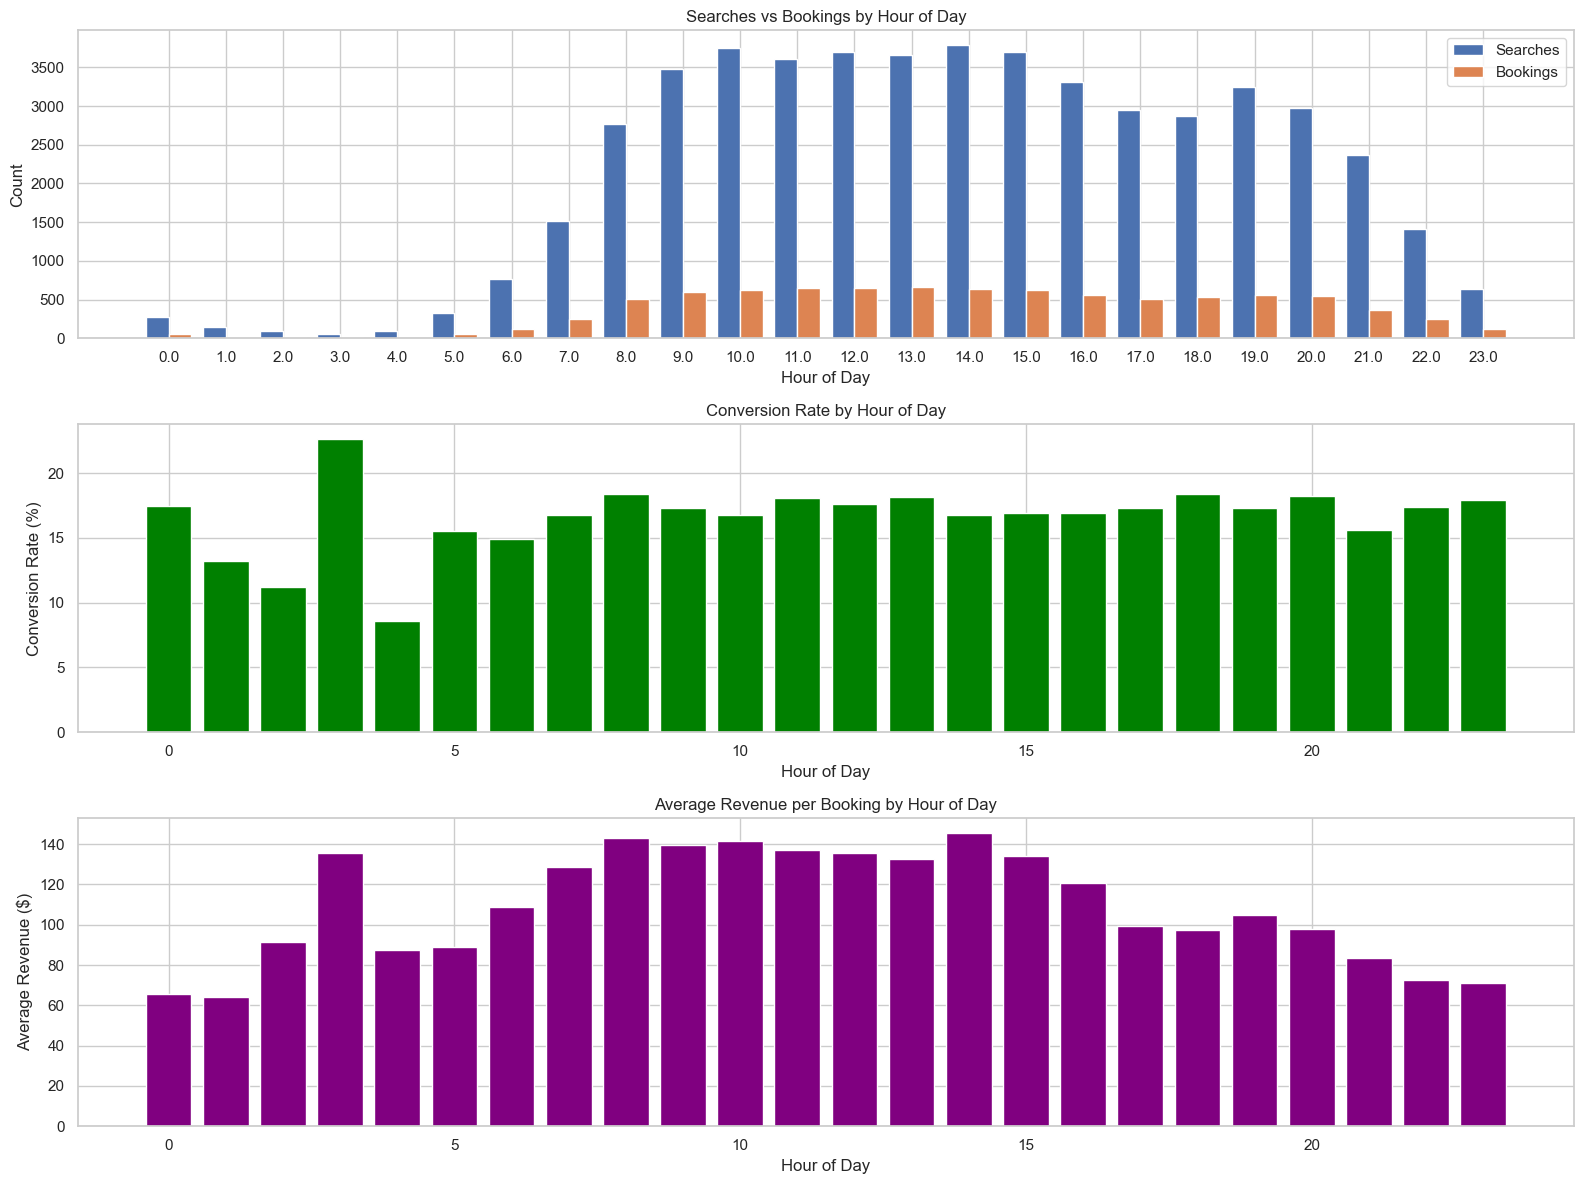


14.3 Day of Week Analysis
--------------------------------------------------


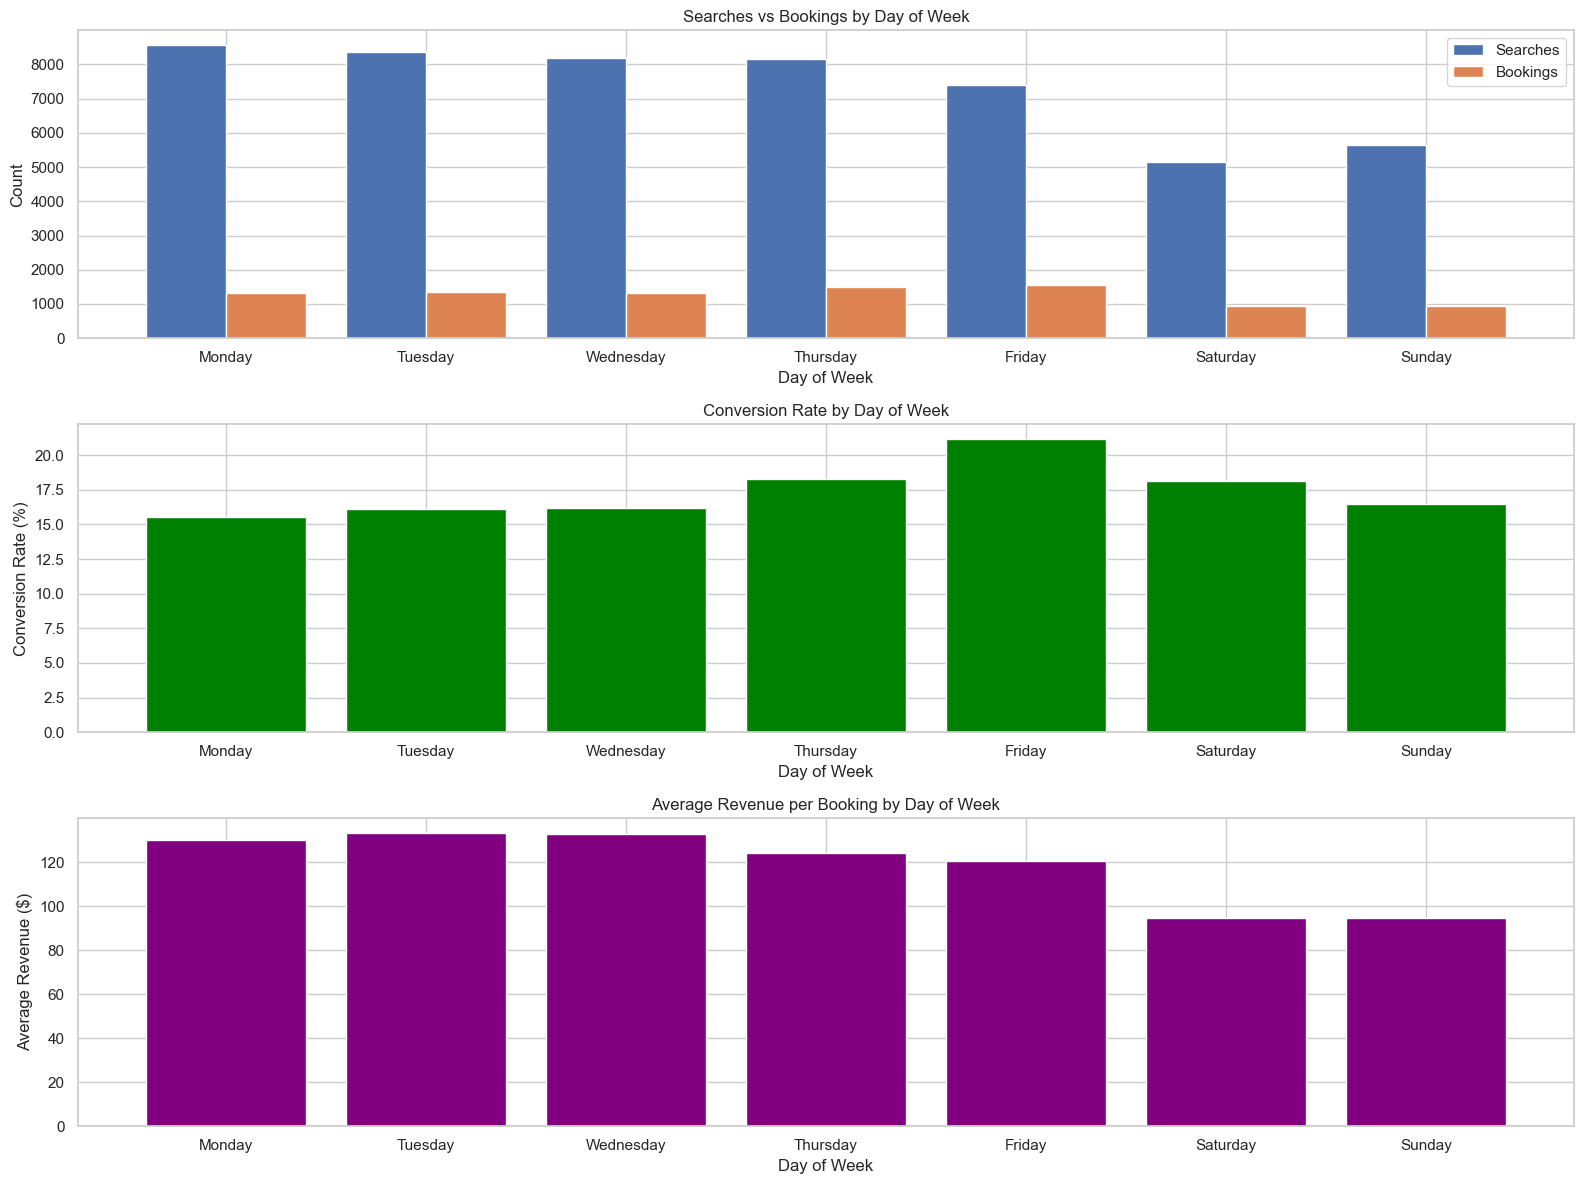


14.4 Venue Analysis
--------------------------------------------------


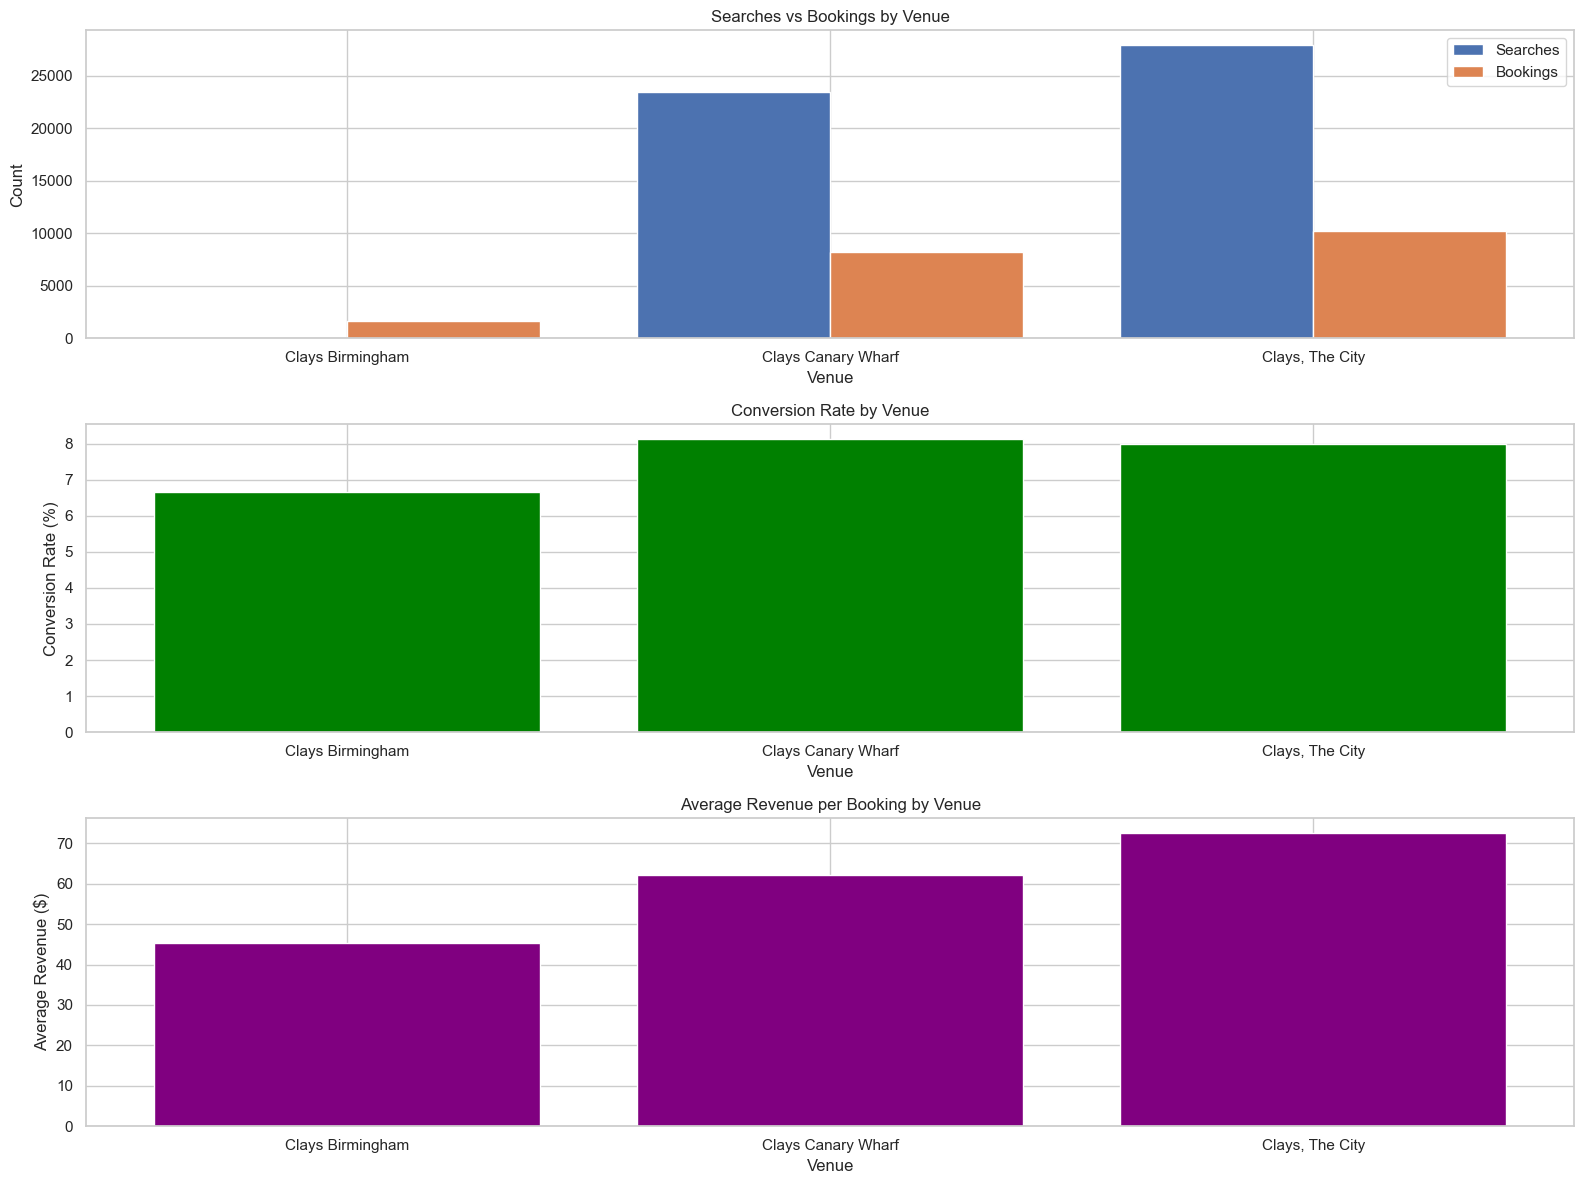

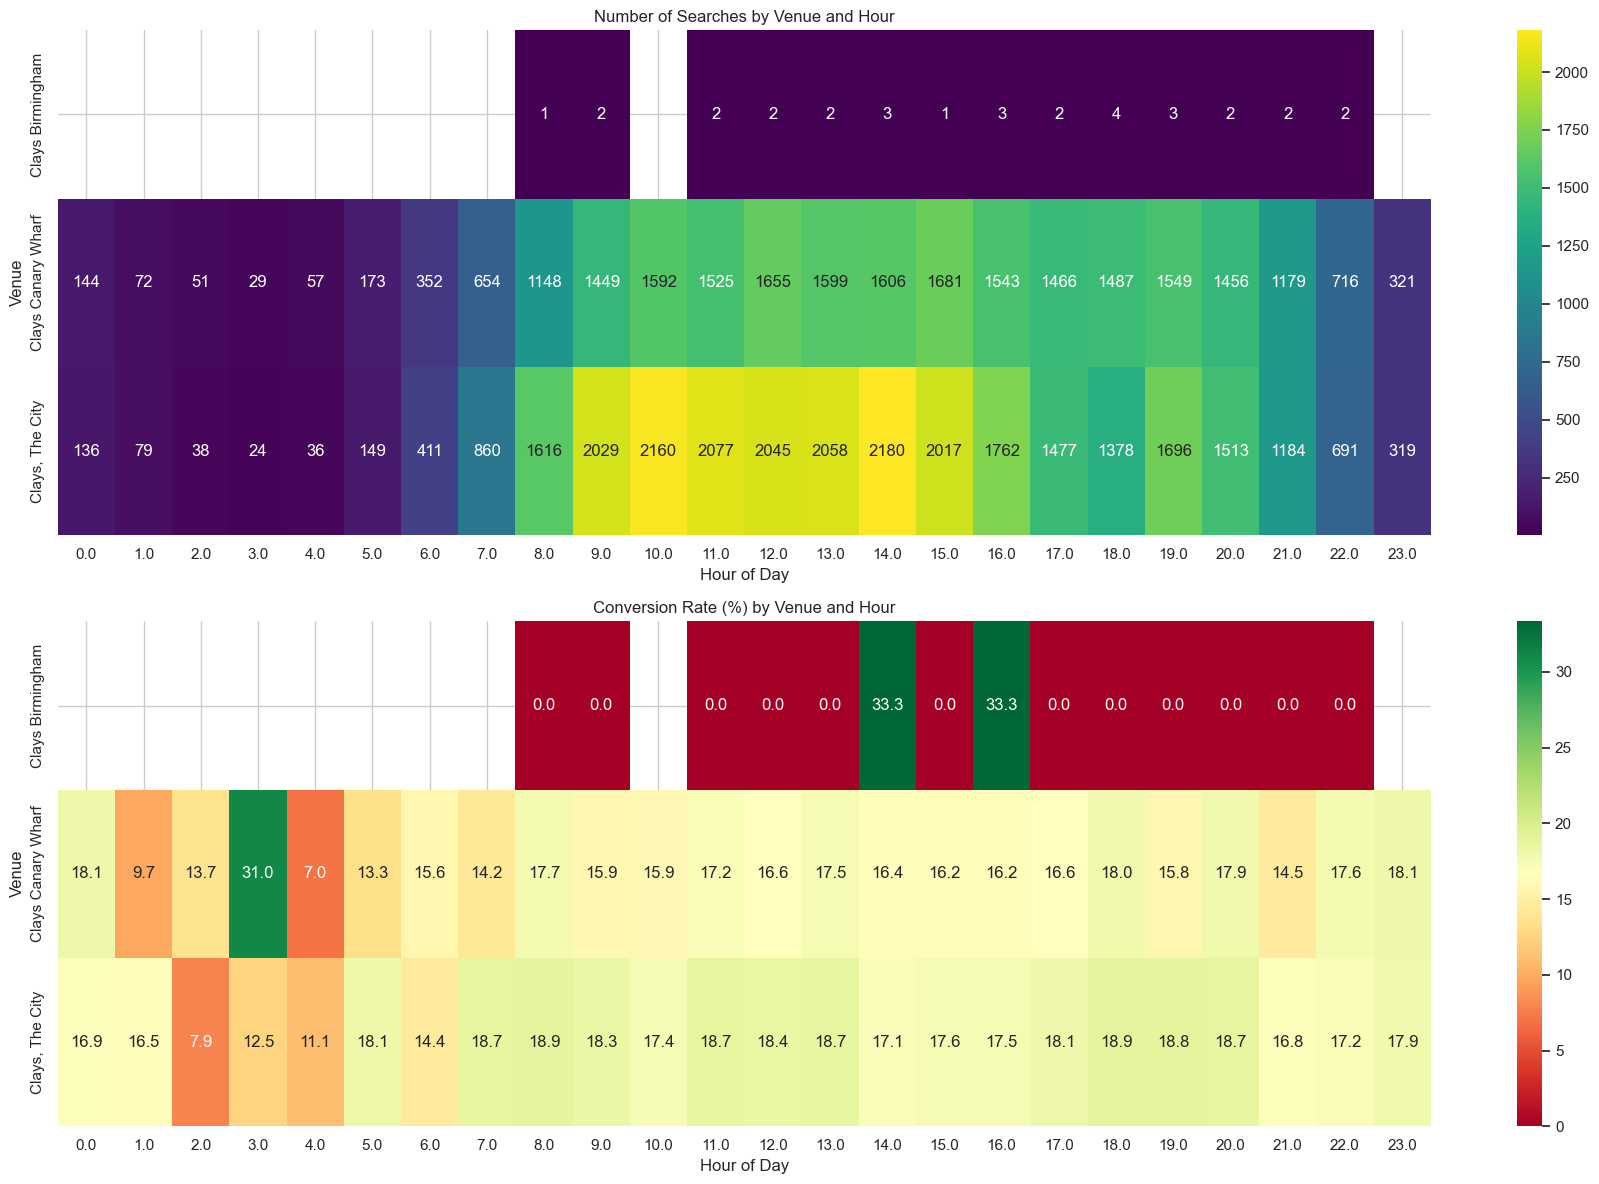

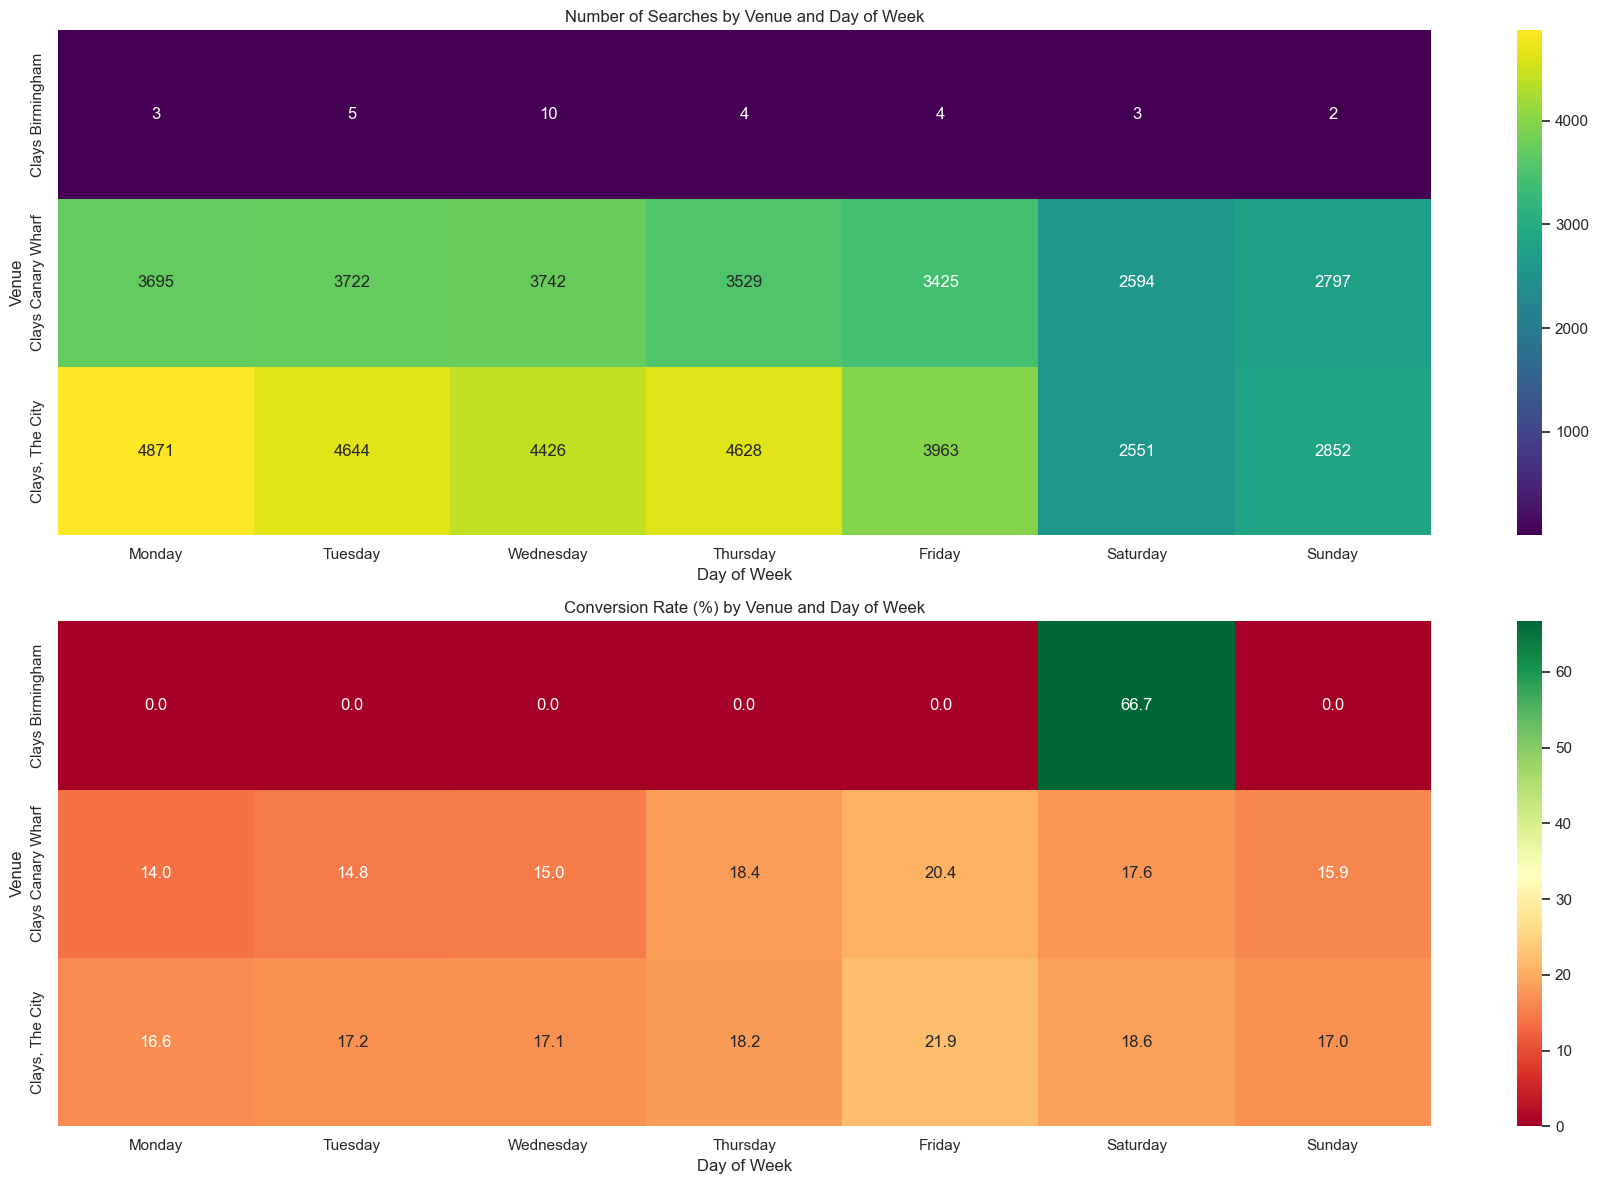


14.5 Lead Time Bucket Analysis
--------------------------------------------------


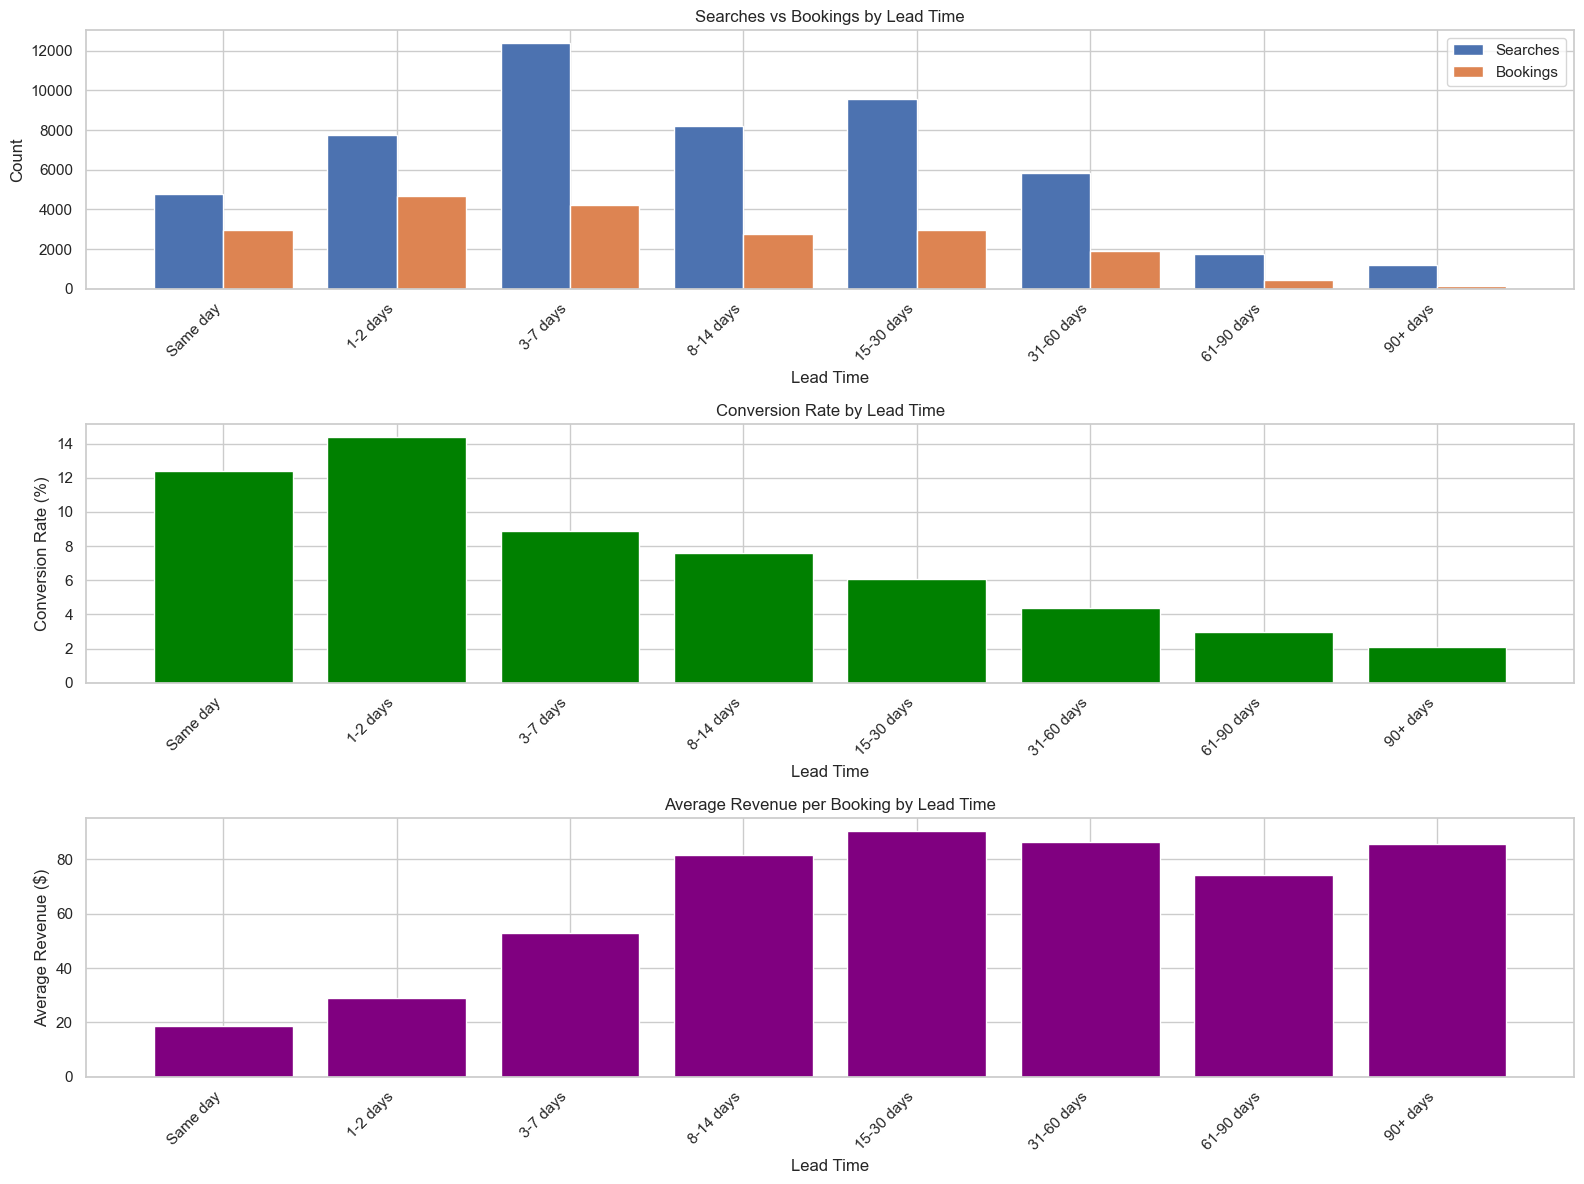


14.6 Peak and Off-Peak Zone Definition
--------------------------------------------------


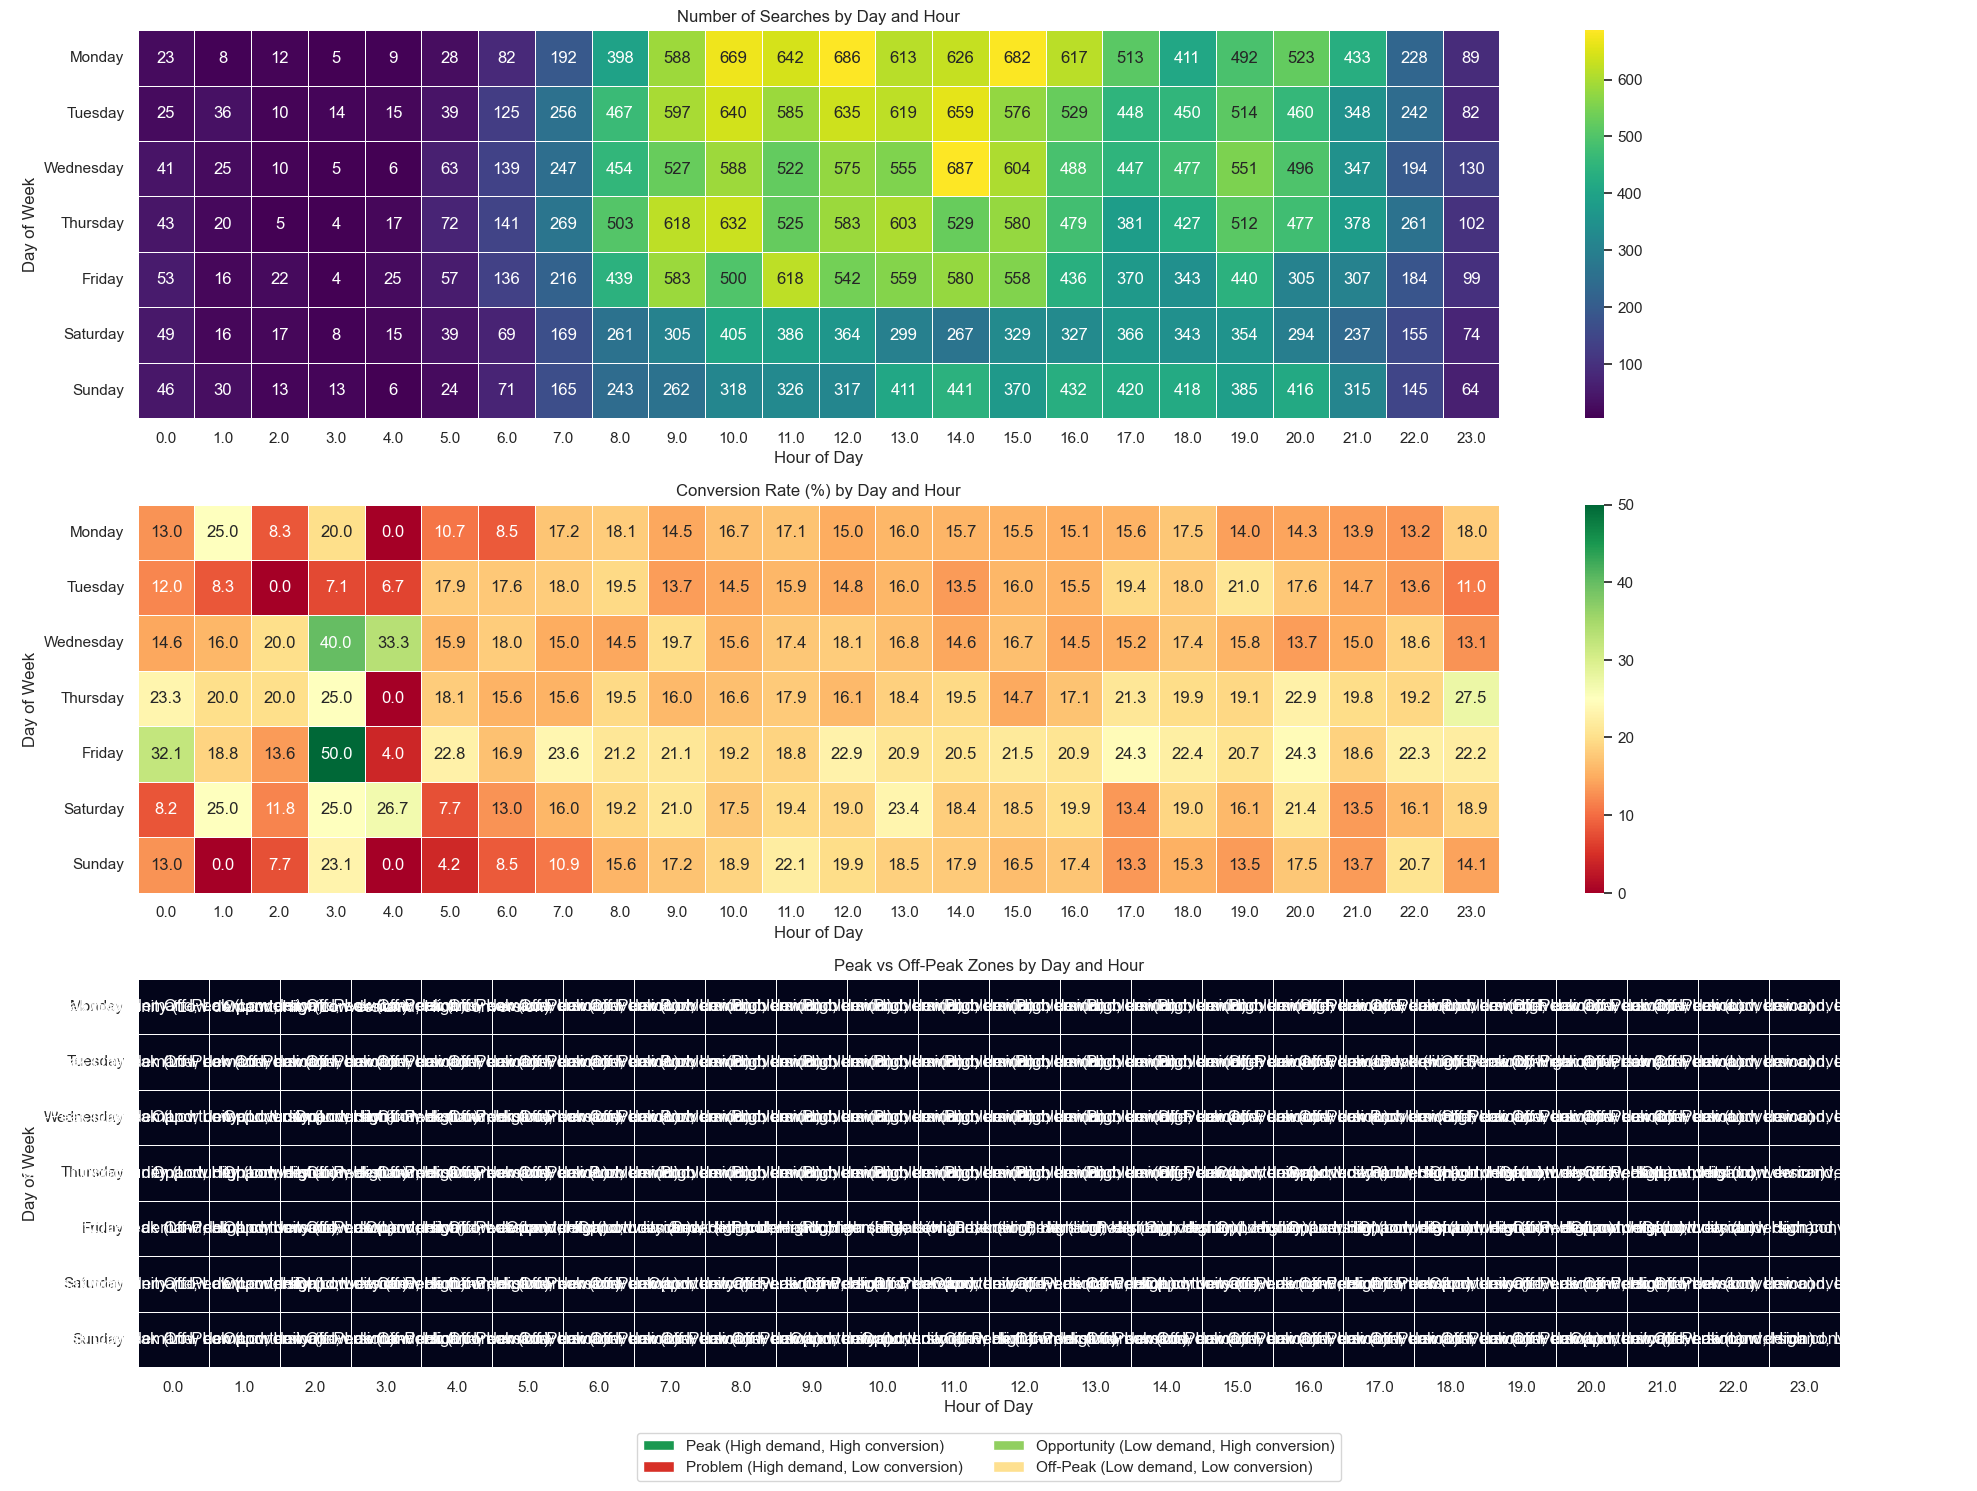

Zone Summary:
                                        Zone  SearchPercentage  \
0      Off-Peak (Low demand, Low conversion)         37.771517   
1  Opportunity (Low demand, High conversion)         13.370896   
2        Peak (High demand, High conversion)          6.481446   
3      Problem (High demand, Low conversion)         42.376141   

   BookingPercentage  ConversionRate  RevenuePercentage  AvgRevenue  
0          35.280924       14.000026          31.984969   96.037903  
1          16.877874       24.128779          10.541100   90.591418  
2           7.973534       21.323420           7.270655  135.884538  
3          39.867668       16.378140          50.203277  143.128661  


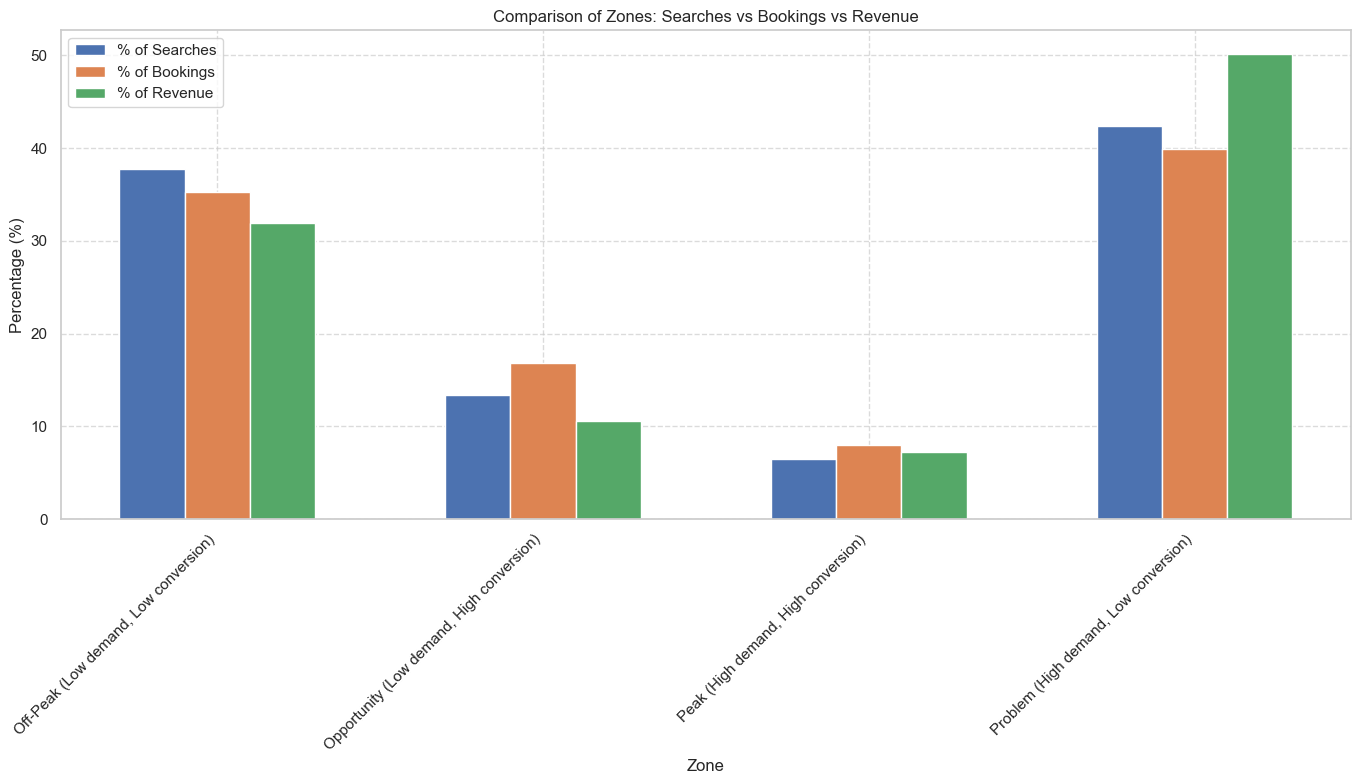

In [26]:
print("\n" + "="*80)
print("14. SEGMENT SUPPLY VS DEMAND (TIME-SERIES TRENDS & SEASONALITY)")
print("="*80)

print("\n14.1 Weekly/Monthly/Quarterly Trends")
print("-"*50)

# Ensure we have a date range within SearchDate for plotting
date_min = df_clean['SearchDate'].dropna().min()
date_max = df_clean['SearchDate'].dropna().max()
print(f"Date range: {date_min} to {date_max}")

# Weekly Trends
weekly_demand = df_clean.groupby([df_clean['SearchYear'], df_clean['SearchWeek']]).agg({
    'Search At': 'count',
    'IsBooked': 'sum'
}).reset_index()

weekly_demand.columns = ['Year', 'Week', 'Searches', 'Bookings']
weekly_demand['ConversionRate'] = (weekly_demand['Bookings'] / weekly_demand['Searches']) * 100
weekly_demand['WeekLabel'] = weekly_demand['Year'].astype(str) + '-W' + weekly_demand['Week'].astype(str).str.zfill(2)

# Create a date for each week for better plotting
weekly_demand['WeekStartDate'] = weekly_demand.apply(
    lambda x: datetime.strptime(f"{int(x['Year'])}-W{int(x['Week'])}-1", "%Y-W%W-%w"), axis=1
)

# Sort by date
weekly_demand = weekly_demand.sort_values('WeekStartDate')

# Plot weekly trends
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(weekly_demand['WeekStartDate'], weekly_demand['Searches'], marker='o', linestyle='-', label='Searches')
plt.plot(weekly_demand['WeekStartDate'], weekly_demand['Bookings'], marker='s', linestyle='-', label='Bookings')
plt.title('Weekly Search and Booking Trends')
plt.xlabel('Week')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
plt.plot(weekly_demand['WeekStartDate'], weekly_demand['ConversionRate'], marker='o', linestyle='-', color='green')
plt.title('Weekly Conversion Rate Trend')
plt.xlabel('Week')
plt.ylabel('Conversion Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly Trends
monthly_demand = df_clean.groupby([df_clean['SearchYear'], df_clean['SearchMonth']]).agg({
    'Search At': 'count',
    'IsBooked': 'sum',
    'Total Cost ($)': 'sum'
}).reset_index()

monthly_demand.columns = ['Year', 'Month', 'Searches', 'Bookings', 'Revenue']
monthly_demand['ConversionRate'] = (monthly_demand['Bookings'] / monthly_demand['Searches']) * 100
monthly_demand['AvgRevenuePerBooking'] = monthly_demand['Revenue'] / monthly_demand['Bookings']
monthly_demand['MonthLabel'] = monthly_demand['Year'].astype(int).astype(str) + '-' + monthly_demand['Month'].astype(int).astype(str).str.zfill(2)
monthly_demand['MonthName'] = monthly_demand['Month'].apply(lambda x: calendar.month_name[int(x)])

# Create a date for each month for better plotting
monthly_demand['MonthStartDate'] = pd.to_datetime(monthly_demand['MonthLabel'] + '-01')

# Sort by date
monthly_demand = monthly_demand.sort_values('MonthStartDate')

# Plot monthly trends
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(monthly_demand['MonthStartDate'], monthly_demand['Searches'], marker='o', linestyle='-', label='Searches')
plt.plot(monthly_demand['MonthStartDate'], monthly_demand['Bookings'], marker='s', linestyle='-', label='Bookings')
plt.title('Monthly Search and Booking Trends')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
plt.plot(monthly_demand['MonthStartDate'], monthly_demand['ConversionRate'], marker='o', linestyle='-', color='green')
plt.title('Monthly Conversion Rate Trend')
plt.xlabel('Month')
plt.ylabel('Conversion Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
plt.plot(monthly_demand['MonthStartDate'], monthly_demand['Revenue'], marker='o', linestyle='-', color='purple')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Quarterly Trends
quarterly_demand = df_clean.groupby([df_clean['SearchYear'], df_clean['SearchQuarter']]).agg({
    'Search At': 'count',
    'IsBooked': 'sum',
    'Total Cost ($)': 'sum'
}).reset_index()

quarterly_demand.columns = ['Year', 'Quarter', 'Searches', 'Bookings', 'Revenue']
quarterly_demand['ConversionRate'] = (quarterly_demand['Bookings'] / quarterly_demand['Searches']) * 100
quarterly_demand['AvgRevenuePerBooking'] = quarterly_demand['Revenue'] / quarterly_demand['Bookings']
quarterly_demand['QuarterLabel'] = quarterly_demand['Year'].astype(str) + '-Q' + quarterly_demand['Quarter'].astype(str)

# Create a date for each quarter for better plotting
quarterly_demand['QuarterStartDate'] = quarterly_demand.apply(
    lambda x: pd.Timestamp(year=int(x['Year']), month=(int(x['Quarter'])-1)*3+1, day=1), axis=1
)

# Sort by date
quarterly_demand = quarterly_demand.sort_values('QuarterStartDate')

# Plot quarterly trends
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(quarterly_demand['QuarterStartDate'], quarterly_demand['Searches'], marker='o', linestyle='-', label='Searches')
plt.plot(quarterly_demand['QuarterStartDate'], quarterly_demand['Bookings'], marker='s', linestyle='-', label='Bookings')
plt.title('Quarterly Search and Booking Trends')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
plt.plot(quarterly_demand['QuarterStartDate'], quarterly_demand['ConversionRate'], marker='o', linestyle='-', color='green')
plt.title('Quarterly Conversion Rate Trend')
plt.xlabel('Quarter')
plt.ylabel('Conversion Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
plt.plot(quarterly_demand['QuarterStartDate'], quarterly_demand['Revenue'], marker='o', linestyle='-', color='purple')
plt.title('Quarterly Revenue Trend')
plt.xlabel('Quarter')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n14.2 Hour of Day Analysis")
print("-"*50)

# Hour of day analysis
hour_demand = df_clean.groupby('SearchHour').agg({
    'Search At': 'count',
    'IsBooked': ['sum', 'mean'],
    'Total Cost ($)': ['sum', 'mean']
}).reset_index()

# Flatten multi-level columns
hour_demand.columns = ['Hour', 'Searches', 'Bookings', 'ConversionRate', 'TotalRevenue', 'AvgRevenue']
hour_demand['ConversionRate'] = hour_demand['ConversionRate'] * 100

# Plot hour of day analysis
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
width = 0.4
x = np.arange(len(hour_demand))
plt.bar(x - width/2, hour_demand['Searches'], width, label='Searches')
plt.bar(x + width/2, hour_demand['Bookings'], width, label='Bookings')
plt.title('Searches vs Bookings by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(x, hour_demand['Hour'])
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.bar(hour_demand['Hour'], hour_demand['ConversionRate'], color='green')
plt.title('Conversion Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate (%)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.bar(hour_demand['Hour'], hour_demand['AvgRevenue'], color='purple')
plt.title('Average Revenue per Booking by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Revenue ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n14.3 Day of Week Analysis")
print("-"*50)

# Day of week analysis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_demand = df_clean.groupby('SearchDayName').agg({
    'Search At': 'count',
    'IsBooked': ['sum', 'mean'],
    'Total Cost ($)': ['sum', 'mean']
}).reset_index()

# Flatten multi-level columns
day_demand.columns = ['Day', 'Searches', 'Bookings', 'ConversionRate', 'TotalRevenue', 'AvgRevenue']
day_demand['ConversionRate'] = day_demand['ConversionRate'] * 100

# Reorder days
day_demand['Day'] = pd.Categorical(day_demand['Day'], categories=day_order, ordered=True)
day_demand = day_demand.sort_values('Day')

# Plot day of week analysis
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
width = 0.4
x = np.arange(len(day_demand))
plt.bar(x - width/2, day_demand['Searches'], width, label='Searches')
plt.bar(x + width/2, day_demand['Bookings'], width, label='Bookings')
plt.title('Searches vs Bookings by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(x, day_demand['Day'])
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.bar(day_demand['Day'], day_demand['ConversionRate'], color='green')
plt.title('Conversion Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Conversion Rate (%)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.bar(day_demand['Day'], day_demand['AvgRevenue'], color='purple')
plt.title('Average Revenue per Booking by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Revenue ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n14.4 Venue Analysis")
print("-"*50)

if 'Venue Name' in df_clean.columns:
    # Venue analysis
    venue_demand = df_clean.groupby('Venue Name').agg({
        'Search At': 'count',
        'IsBooked': ['sum', 'mean'],
        'Total Cost ($)': ['sum', 'mean']
    }).reset_index()
    
    # Flatten multi-level columns
    venue_demand.columns = ['Venue', 'Searches', 'Bookings', 'ConversionRate', 'TotalRevenue', 'AvgRevenue']
    venue_demand['ConversionRate'] = venue_demand['ConversionRate'] * 100
    
    # Plot venue analysis
    plt.figure(figsize=(16, 12))
    plt.subplot(3, 1, 1)
    width = 0.4
    x = np.arange(len(venue_demand))
    plt.bar(x - width/2, venue_demand['Searches'], width, label='Searches')
    plt.bar(x + width/2, venue_demand['Bookings'], width, label='Bookings')
    plt.title('Searches vs Bookings by Venue')
    plt.xlabel('Venue')
    plt.ylabel('Count')
    plt.xticks(x, venue_demand['Venue'])
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 1, 2)
    plt.bar(venue_demand['Venue'], venue_demand['ConversionRate'], color='green')
    plt.title('Conversion Rate by Venue')
    plt.xlabel('Venue')
    plt.ylabel('Conversion Rate (%)')
    plt.grid(True)
    
    plt.subplot(3, 1, 3)
    plt.bar(venue_demand['Venue'], venue_demand['AvgRevenue'], color='purple')
    plt.title('Average Revenue per Booking by Venue')
    plt.xlabel('Venue')
    plt.ylabel('Average Revenue ($)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Create venue by hour heatmap
    venue_hour = df_clean.groupby(['Venue Name', 'SearchHour']).agg({
        'Search At': 'count',
        'IsBooked': 'mean'
    }).reset_index()
    
    venue_hour.columns = ['Venue', 'Hour', 'Searches', 'ConversionRate']
    venue_hour['ConversionRate'] = venue_hour['ConversionRate'] * 100
    
    # Create pivot tables for heatmaps
    venue_hour_searches = pd.pivot_table(venue_hour, values='Searches', index='Venue', columns='Hour')
    venue_hour_conversion = pd.pivot_table(venue_hour, values='ConversionRate', index='Venue', columns='Hour')
    
    # Plot venue by hour heatmaps
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 1, 1)
    sns.heatmap(venue_hour_searches, cmap='viridis', annot=True, fmt='.0f')
    plt.title('Number of Searches by Venue and Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Venue')
    
    plt.subplot(2, 1, 2)
    sns.heatmap(venue_hour_conversion, cmap='RdYlGn', annot=True, fmt='.1f')
    plt.title('Conversion Rate (%) by Venue and Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Venue')
    plt.tight_layout()
    plt.show()
    
    # Create venue by day heatmap
    venue_day = df_clean.groupby(['Venue Name', 'SearchDayName']).agg({
        'Search At': 'count',
        'IsBooked': 'mean'
    }).reset_index()
    
    venue_day.columns = ['Venue', 'Day', 'Searches', 'ConversionRate']
    venue_day['ConversionRate'] = venue_day['ConversionRate'] * 100
    
    # Create pivot tables for heatmaps
    venue_day_searches = pd.pivot_table(venue_day, values='Searches', index='Venue', columns='Day')
    venue_day_conversion = pd.pivot_table(venue_day, values='ConversionRate', index='Venue', columns='Day')
    
    # Reorder days
    venue_day_searches = venue_day_searches.reindex(columns=day_order)
    venue_day_conversion = venue_day_conversion.reindex(columns=day_order)
    
    # Plot venue by day heatmaps
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 1, 1)
    sns.heatmap(venue_day_searches, cmap='viridis', annot=True, fmt='.0f')
    plt.title('Number of Searches by Venue and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Venue')
    
    plt.subplot(2, 1, 2)
    sns.heatmap(venue_day_conversion, cmap='RdYlGn', annot=True, fmt='.1f')
    plt.title('Conversion Rate (%) by Venue and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Venue')
    plt.tight_layout()
    plt.show()

print("\n14.5 Lead Time Bucket Analysis")
print("-"*50)

# Lead time analysis
# Create lead time bins
lead_time_bins = [-1, 0, 2, 7, 14, 30, 60, 90, 365]
lead_time_labels = ['Same day', '1-2 days', '3-7 days', '8-14 days', '15-30 days', '31-60 days', '61-90 days', '90+ days']

df_clean['LeadTimeBucket'] = pd.cut(df_clean['Search Days Ahead'], bins=lead_time_bins, labels=lead_time_labels)

# Analyze by lead time bucket
lead_time_demand = df_clean.groupby('LeadTimeBucket').agg({
    'Search At': 'count',
    'IsBooked': ['sum', 'mean'],
    'Total Cost ($)': ['sum', 'mean']
}).reset_index()

# Flatten multi-level columns
lead_time_demand.columns = ['LeadTimeBucket', 'Searches', 'Bookings', 'ConversionRate', 'TotalRevenue', 'AvgRevenue']
lead_time_demand['ConversionRate'] = lead_time_demand['ConversionRate'] * 100

# Plot lead time analysis
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
width = 0.4
x = np.arange(len(lead_time_demand))
plt.bar(x - width/2, lead_time_demand['Searches'], width, label='Searches')
plt.bar(x + width/2, lead_time_demand['Bookings'], width, label='Bookings')
plt.title('Searches vs Bookings by Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Count')
plt.xticks(x, lead_time_demand['LeadTimeBucket'], rotation=45, ha='right')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.bar(x, lead_time_demand['ConversionRate'], color='green')
plt.title('Conversion Rate by Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Conversion Rate (%)')
plt.xticks(x, lead_time_demand['LeadTimeBucket'], rotation=45, ha='right')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.bar(x, lead_time_demand['AvgRevenue'], color='purple')
plt.title('Average Revenue per Booking by Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Average Revenue ($)')
plt.xticks(x, lead_time_demand['LeadTimeBucket'], rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n14.6 Peak and Off-Peak Zone Definition")
print("-"*50)

# Create a day-hour demand matrix
day_hour_demand = df_clean.groupby(['SearchDayName', 'SearchHour']).agg({
    'Search At': 'count',
    'IsBooked': ['sum', 'mean'],
    'Total Cost ($)': ['sum', 'mean']
}).reset_index()

# Flatten multi-level columns
day_hour_demand.columns = ['Day', 'Hour', 'Searches', 'Bookings', 'ConversionRate', 'TotalRevenue', 'AvgRevenue']
day_hour_demand['ConversionRate'] = day_hour_demand['ConversionRate'] * 100

# Create percentile columns for zone definition
day_hour_demand['SearchPercentile'] = day_hour_demand['Searches'].rank(pct=True) * 100
day_hour_demand['ConversionPercentile'] = day_hour_demand['ConversionRate'].rank(pct=True) * 100

# Define zones based on search and conversion percentiles
def define_zone(row):
    if row['SearchPercentile'] >= 75 and row['ConversionPercentile'] >= 75:
        return 'Peak (High demand, High conversion)'
    elif row['SearchPercentile'] >= 75 and row['ConversionPercentile'] < 75:
        return 'Problem (High demand, Low conversion)'
    elif row['SearchPercentile'] < 75 and row['ConversionPercentile'] >= 75:
        return 'Opportunity (Low demand, High conversion)'
    else:
        return 'Off-Peak (Low demand, Low conversion)'

day_hour_demand['Zone'] = day_hour_demand.apply(define_zone, axis=1)

# Create pivot tables for visualization
day_hour_searches = pd.pivot_table(day_hour_demand, values='Searches', index='Day', columns='Hour')
day_hour_conversion = pd.pivot_table(day_hour_demand, values='ConversionRate', index='Day', columns='Hour')
day_hour_zone = pd.pivot_table(day_hour_demand, values='Zone', index='Day', columns='Hour', aggfunc=lambda x: x.iloc[0])

# Reorder days
day_hour_searches = day_hour_searches.reindex(day_order)
day_hour_conversion = day_hour_conversion.reindex(day_order)
day_hour_zone = day_hour_zone.reindex(day_order)

# Create a custom colormap for zones
zone_colors = {
    'Peak (High demand, High conversion)': '#1a9850',  # Dark green
    'Problem (High demand, Low conversion)': '#d73027',  # Red
    'Opportunity (Low demand, High conversion)': '#91cf60',  # Light green
    'Off-Peak (Low demand, Low conversion)': '#fee090'   # Light yellow
}

# Create a custom color matrix for zone visualization
zone_color_matrix = day_hour_zone.copy()
for day in zone_color_matrix.index:
    for hour in zone_color_matrix.columns:
        if pd.notna(zone_color_matrix.loc[day, hour]):
            zone_color_matrix.loc[day, hour] = zone_colors.get(zone_color_matrix.loc[day, hour], '#f7f7f7')

# Plot the demand and zone heatmaps
plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
sns.heatmap(day_hour_searches, cmap='viridis', annot=True, fmt='.0f', linewidths=0.5)
plt.title('Number of Searches by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')

plt.subplot(3, 1, 2)
sns.heatmap(day_hour_conversion, cmap='RdYlGn', annot=True, fmt='.1f', linewidths=0.5)
plt.title('Conversion Rate (%) by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')

# Plot the zone heatmap
plt.subplot(3, 1, 3)
sns.heatmap(day_hour_zone.notna(), annot=day_hour_zone, fmt='', cmap=None, cbar=False, linewidths=0.5)
plt.title('Peak vs Off-Peak Zones by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')

# Add legend for zones
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1a9850', label='Peak (High demand, High conversion)'),
    Patch(facecolor='#d73027', label='Problem (High demand, Low conversion)'),
    Patch(facecolor='#91cf60', label='Opportunity (Low demand, High conversion)'),
    Patch(facecolor='#fee090', label='Off-Peak (Low demand, Low conversion)')
]
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()
plt.show()

# Summarize the zones
zone_summary = day_hour_demand.groupby('Zone').agg({
    'Searches': 'sum',
    'Bookings': 'sum',
    'ConversionRate': 'mean',
    'TotalRevenue': 'sum',
    'AvgRevenue': 'mean'
}).reset_index()

# Calculate percentages
zone_summary['SearchPercentage'] = zone_summary['Searches'] / zone_summary['Searches'].sum() * 100
zone_summary['BookingPercentage'] = zone_summary['Bookings'] / zone_summary['Bookings'].sum() * 100
zone_summary['RevenuePercentage'] = zone_summary['TotalRevenue'] / zone_summary['TotalRevenue'].sum() * 100

print("Zone Summary:")
print(zone_summary[['Zone', 'SearchPercentage', 'BookingPercentage', 'ConversionRate', 'RevenuePercentage', 'AvgRevenue']])

# Create a zone comparison plot
plt.figure(figsize=(14, 8))
x = np.arange(len(zone_summary))
width = 0.2

plt.bar(x - width, zone_summary['SearchPercentage'], width, label='% of Searches')
plt.bar(x, zone_summary['BookingPercentage'], width, label='% of Bookings')
plt.bar(x + width, zone_summary['RevenuePercentage'], width, label='% of Revenue')

plt.title('Comparison of Zones: Searches vs Bookings vs Revenue')
plt.xlabel('Zone')
plt.ylabel('Percentage (%)')
plt.xticks(x, zone_summary['Zone'], rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 15. Conversion funnel diagnostics


15. CONVERSION FUNNEL DIAGNOSTICS
Conversion Funnel Analysis:
Step 1: Search - 253353 visitors
Step 2: Personal Info - 22000 visitors
   Drop-off: 231353 visitors (91.3%)
Step 3: Billing Info - 27769 visitors
   Drop-off: -5769 visitors (-26.2%)
Step 4: Booking Complete - 20037 visitors
   Drop-off: 7732 visitors (27.8%)

Overall conversion rate: 7.91%


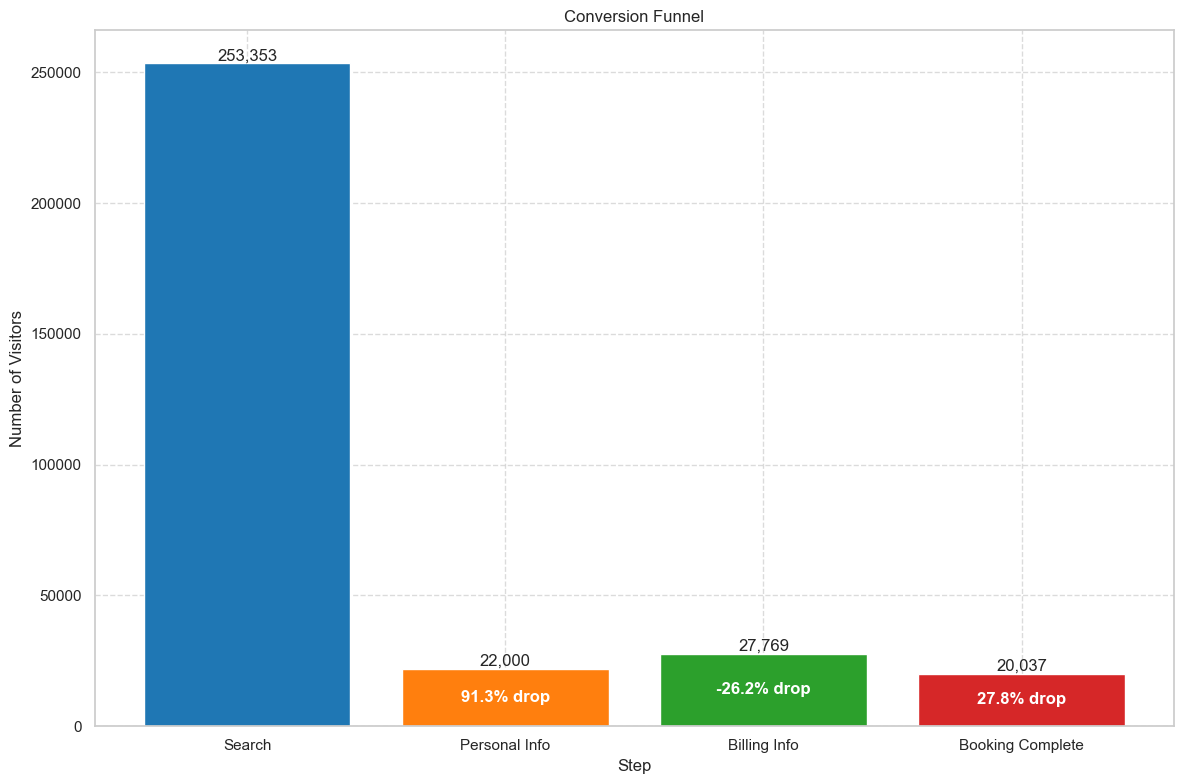


15.2 Funnel Analysis by Key Segments
--------------------------------------------------


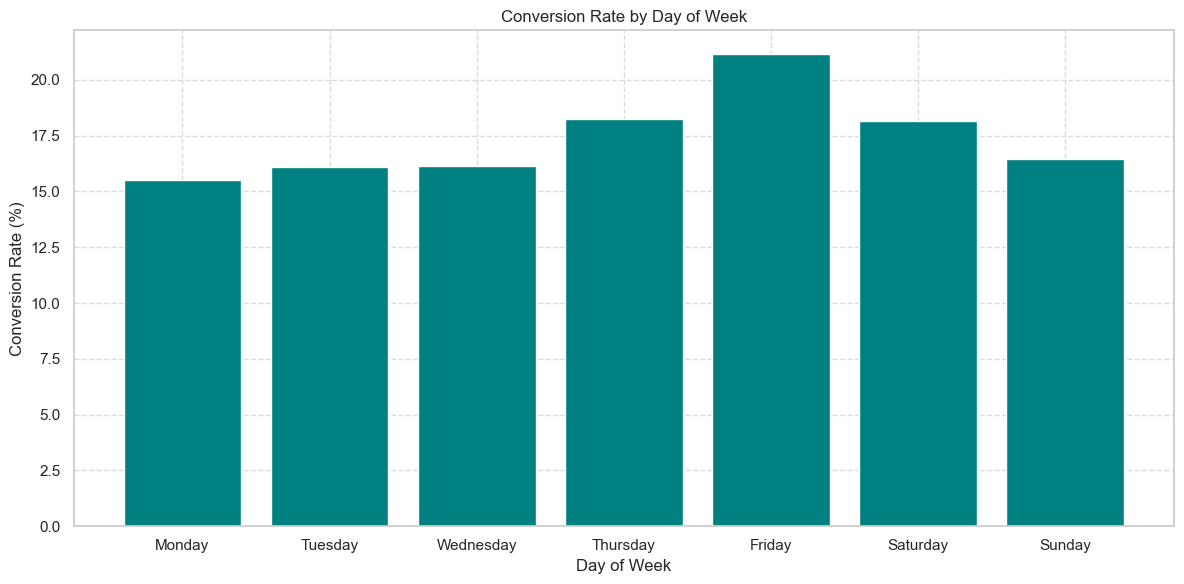

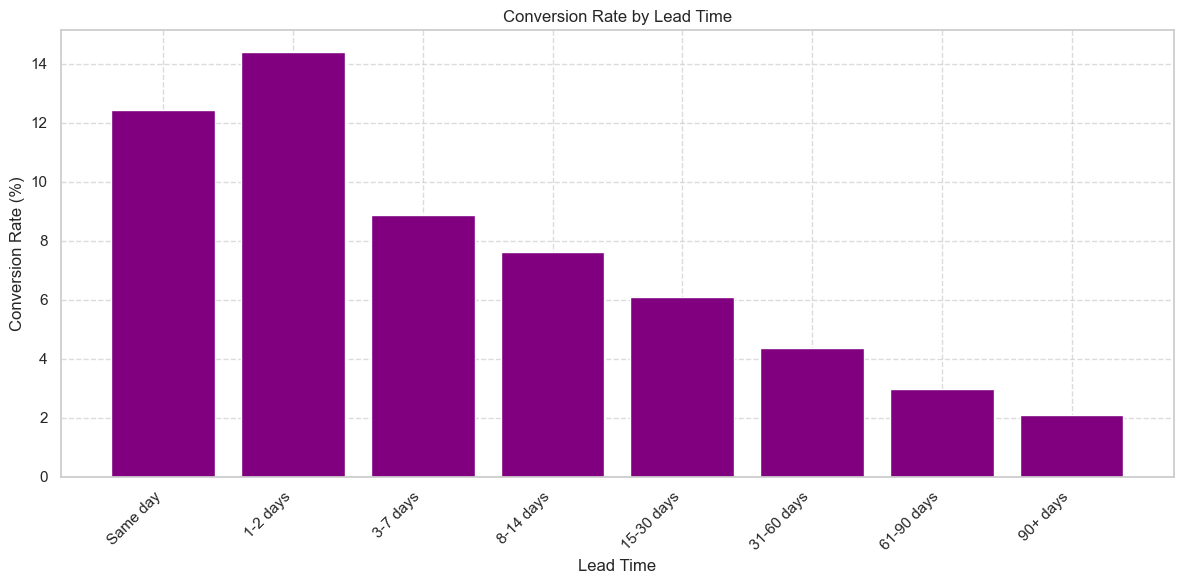

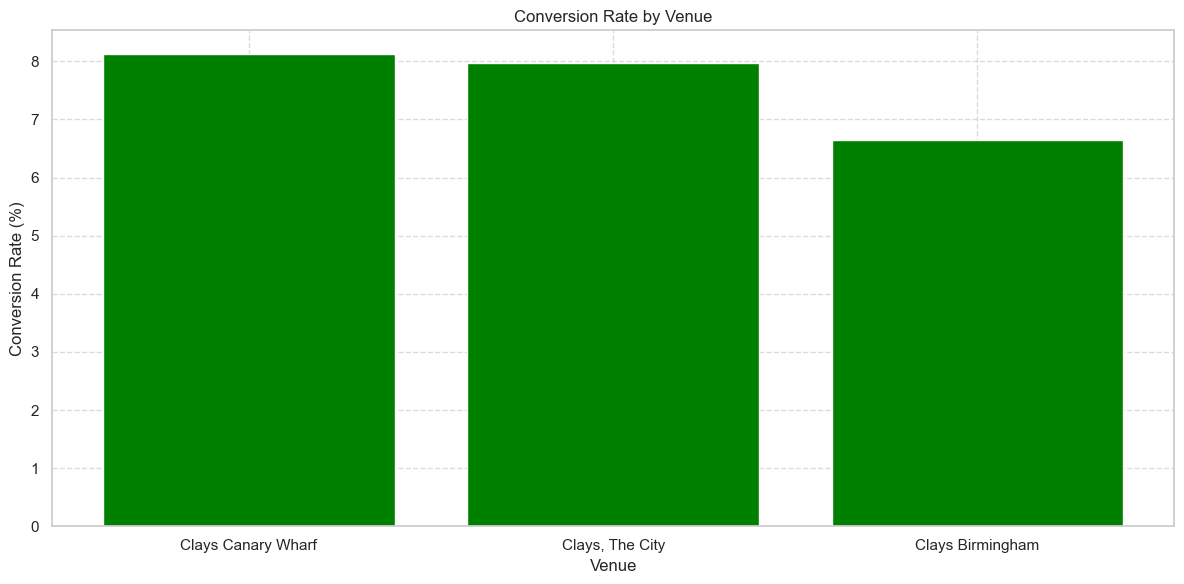


15.3 Funnel Abandonment Analysis
--------------------------------------------------


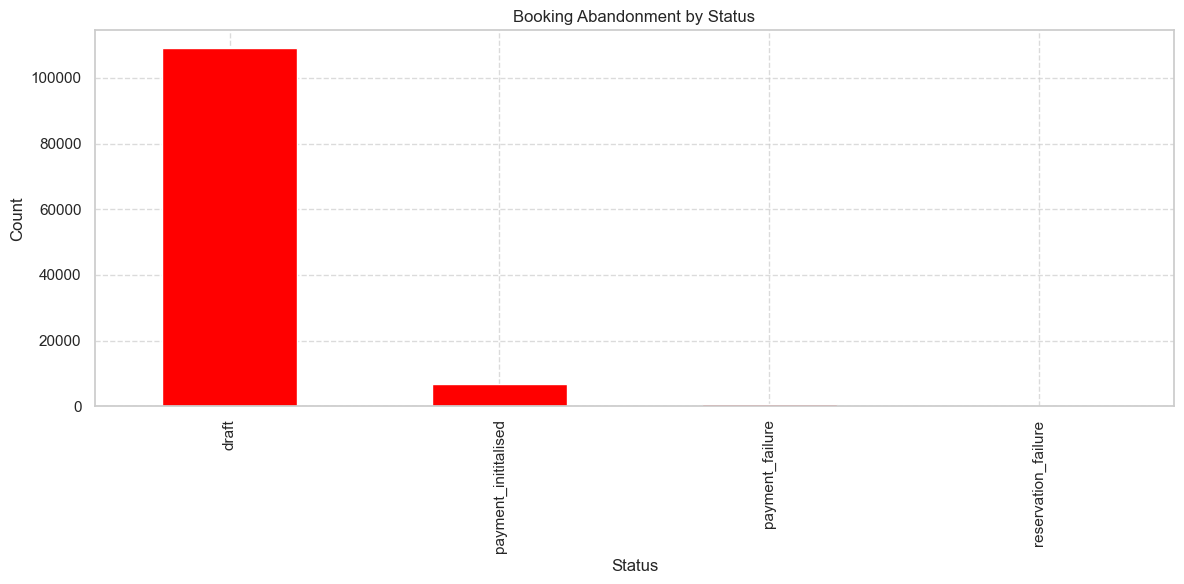

Booking Abandonment by Status:
Booking Status
draft                   109024
payment_inititalised      6684
payment_failure            769
reservation_failure         54
Name: count, dtype: int64


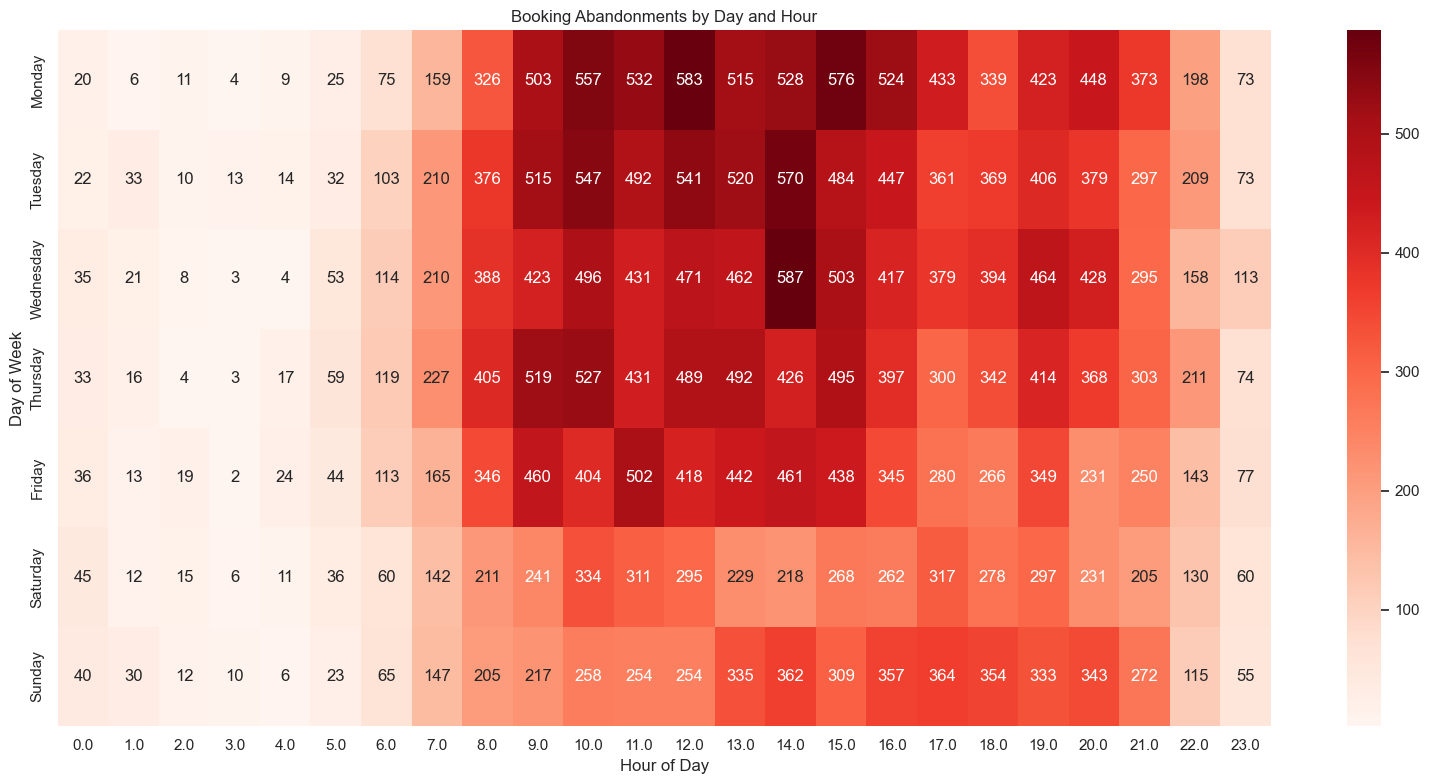

In [27]:
print("\n" + "="*80)
print("15. CONVERSION FUNNEL DIAGNOSTICS")
print("="*80)

# Define the conversion funnel steps
# Step 1: Search
# Step 2: Personal Info Completed
# Step 3: Billing Info Completed
# Step 4: Booking Status = 'reservation_success'

funnel_steps = []
funnel_counts = []

# Step 1: Search (all records)
funnel_steps.append('Search')
funnel_counts.append(len(df_clean))

# Step 2: Personal Info Completed (if available)
if 'Personal Info Completed' in df_clean.columns:
    personal_info_completed = df_clean['Personal Info Completed'].sum()
    funnel_steps.append('Personal Info')
    funnel_counts.append(personal_info_completed)

# Step 3: Billing Info Completed (if available)
if 'Billing Info Completed' in df_clean.columns:
    billing_info_completed = df_clean['Billing Info Completed'].sum()
    funnel_steps.append('Billing Info')
    funnel_counts.append(billing_info_completed)

# Step 4: Reservation Success
if 'Booking Status' in df_clean.columns:
    reservation_success = (df_clean['Booking Status'] == 'reservation_success').sum()
    funnel_steps.append('Booking Complete')
    funnel_counts.append(reservation_success)
else:
    # Use Total Cost as a proxy if Booking Status is not available
    reservation_success = (df_clean['Total Cost ($)'] > 0).sum()
    funnel_steps.append('Booking Complete')
    funnel_counts.append(reservation_success)

# Calculate drop-off at each step
funnel_drop_offs = []
funnel_drop_off_pcts = []

for i in range(len(funnel_counts) - 1):
    drop_off = funnel_counts[i] - funnel_counts[i + 1]
    drop_off_pct = (drop_off / funnel_counts[i]) * 100
    funnel_drop_offs.append(drop_off)
    funnel_drop_off_pcts.append(drop_off_pct)

# Print the funnel results
print("Conversion Funnel Analysis:")
print(f"Step 1: {funnel_steps[0]} - {funnel_counts[0]} visitors")

for i in range(1, len(funnel_steps)):
    print(f"Step {i+1}: {funnel_steps[i]} - {funnel_counts[i]} visitors")
    print(f"   Drop-off: {funnel_drop_offs[i-1]} visitors ({funnel_drop_off_pcts[i-1]:.1f}%)")

# Overall conversion
overall_conversion = (funnel_counts[-1] / funnel_counts[0]) * 100
print(f"\nOverall conversion rate: {overall_conversion:.2f}%")

# Plot the funnel
plt.figure(figsize=(12, 8))
plt.bar(funnel_steps, funnel_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(funnel_steps)])
plt.title('Conversion Funnel')
plt.xlabel('Step')
plt.ylabel('Number of Visitors')
plt.grid(True, linestyle='--', alpha=0.7)

# Add value labels
for i, count in enumerate(funnel_counts):
    plt.text(i, count + 0.1, f"{count:,}", ha='center', va='bottom')
    if i > 0:
        plt.text(i, count/2, f"{funnel_drop_off_pcts[i-1]:.1f}% drop", ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# Create a funnel chart using plotly
fig = go.Figure(go.Funnel(
    y=funnel_steps,
    x=funnel_counts,
    textinfo="value+percent initial"
))

fig.update_layout(
    title="Booking Conversion Funnel",
    width=800,
    height=500
)

fig.show()

# Analyze funnel by key segments
print("\n15.2 Funnel Analysis by Key Segments")
print("-"*50)

# Function to calculate funnel metrics for a segment
def calculate_funnel_metrics(segment_df, segment_name):
    metrics = {'Segment': segment_name}
    
    # Total searches
    metrics['Searches'] = len(segment_df)
    
    # Personal Info step (if available)
    if 'Personal Info Completed' in segment_df.columns:
        metrics['Personal Info'] = segment_df['Personal Info Completed'].sum()
        metrics['Personal Info %'] = (metrics['Personal Info'] / metrics['Searches']) * 100
    
    # Billing Info step (if available)
    if 'Billing Info Completed' in segment_df.columns:
        metrics['Billing Info'] = segment_df['Billing Info Completed'].sum()
        metrics['Billing Info %'] = (metrics['Billing Info'] / metrics['Searches']) * 100
    
    # Booking completion
    if 'Booking Status' in segment_df.columns:
        metrics['Bookings'] = (segment_df['Booking Status'] == 'reservation_success').sum()
    else:
        metrics['Bookings'] = (segment_df['Total Cost ($)'] > 0).sum()
    
    metrics['Conversion %'] = (metrics['Bookings'] / metrics['Searches']) * 100
    
    return metrics

# Analyze funnel by day of week
day_funnels = []
for day in day_order:
    day_df = df_clean[df_clean['SearchDayName'] == day]
    day_funnels.append(calculate_funnel_metrics(day_df, day))

day_funnel_df = pd.DataFrame(day_funnels)

# Plot conversion rates by day of week
plt.figure(figsize=(12, 6))
plt.bar(day_funnel_df['Segment'], day_funnel_df['Conversion %'], color='teal')
plt.title('Conversion Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Conversion Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analyze funnel by lead time bucket
lead_time_funnels = []
for bucket in lead_time_labels:
    lead_df = df_clean[df_clean['LeadTimeBucket'] == bucket]
    lead_time_funnels.append(calculate_funnel_metrics(lead_df, bucket))

lead_time_funnel_df = pd.DataFrame(lead_time_funnels)

# Plot conversion rates by lead time
plt.figure(figsize=(12, 6))
plt.bar(lead_time_funnel_df['Segment'], lead_time_funnel_df['Conversion %'], color='purple')
plt.title('Conversion Rate by Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analyze funnel by venue (if available)
if 'Venue Name' in df_clean.columns:
    venue_funnels = []
    for venue in df_clean['Venue Name'].unique():
        venue_df = df_clean[df_clean['Venue Name'] == venue]
        venue_funnels.append(calculate_funnel_metrics(venue_df, venue))
    
    venue_funnel_df = pd.DataFrame(venue_funnels)
    
    # Plot conversion rates by venue
    plt.figure(figsize=(12, 6))
    plt.bar(venue_funnel_df['Segment'], venue_funnel_df['Conversion %'], color='green')
    plt.title('Conversion Rate by Venue')
    plt.xlabel('Venue')
    plt.ylabel('Conversion Rate (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\n15.3 Funnel Abandonment Analysis")
print("-"*50)

# Analyze common drop-off points
if 'Booking Status' in df_clean.columns:
    abandonment_counts = df_clean['Booking Status'].value_counts()
    
    # Filter out success status
    abandonment_counts = abandonment_counts[abandonment_counts.index != 'reservation_success']
    
    # Plot abandonment reasons
    plt.figure(figsize=(12, 6))
    abandonment_counts.plot(kind='bar', color='red')
    plt.title('Booking Abandonment by Status')
    plt.xlabel('Status')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print("Booking Abandonment by Status:")
    print(abandonment_counts)

    # Analyze abandonment by day and hour
    abandonment_day_hour = df_clean[df_clean['Booking Status'] != 'reservation_success'].groupby(['SearchDayName', 'SearchHour']).size().reset_index()
    abandonment_day_hour.columns = ['Day', 'Hour', 'Abandonments']
    
    # Create pivot table for heatmap
    abandonment_heatmap = pd.pivot_table(abandonment_day_hour, values='Abandonments', index='Day', columns='Hour')
    
    # Reorder days
    if all(day in abandonment_heatmap.index for day in day_order):
        abandonment_heatmap = abandonment_heatmap.reindex(day_order)
    
    # Plot abandonment heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(abandonment_heatmap, cmap='Reds', annot=True, fmt='.0f')
    plt.title('Booking Abandonments by Day and Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.tight_layout()
    plt.show()


# 16. Grouped insights


16. GROUPED INSIGHTS

16.1 Venue Performance Analysis
--------------------------------------------------
Comprehensive Venue Performance Analysis:
                Venue  Searches  Bookings  ConversionRate  TotalRevenue  \
0    Clays Birmingham        31      1635        6.647693     1113232.4   
1  Clays Canary Wharf     23504      8165        8.126804     6239601.0   
2     Clays, The City     27935     10237        7.979702     9302530.0   

   AvgRevenue  MedianRevenue  StdRevenue  AvgPartySize  MedianPartySize  \
0   45.262549            0.0   87.669017      6.744257              5.0   
1   62.104121           20.0  124.612352      5.917120              4.0   
2   72.512862           16.0  139.653880      7.337545              6.0   

   AvgLeadTime  MedianLeadTime  RevenuePerSearch  \
0    31.922952            28.0      35910.722581   
1    18.992694             8.0        265.469750   
2    22.049132            12.0        333.006265   

   RevenueCoefficientOfVariation  
0     

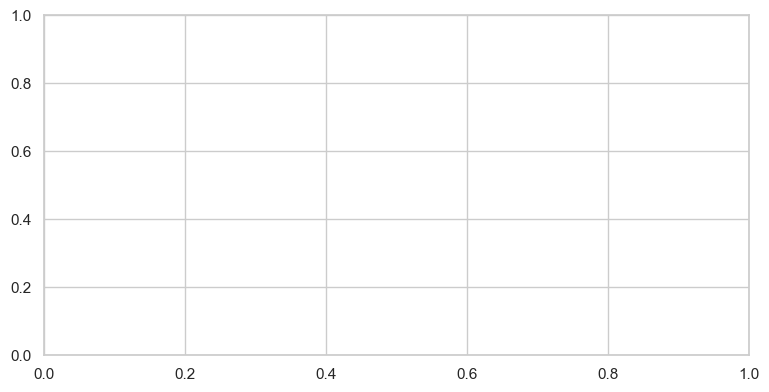

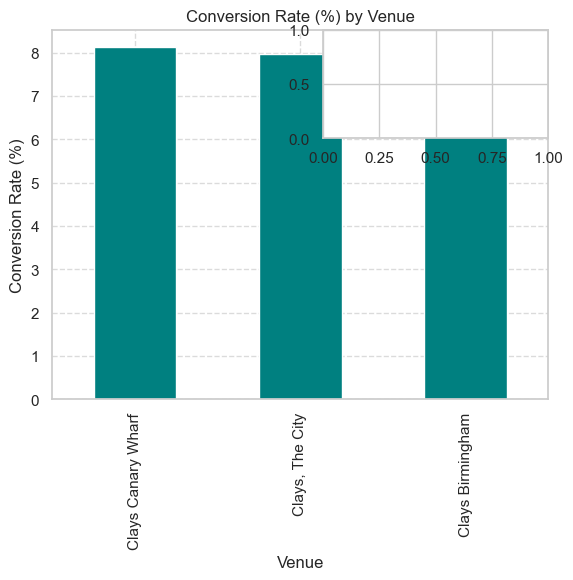

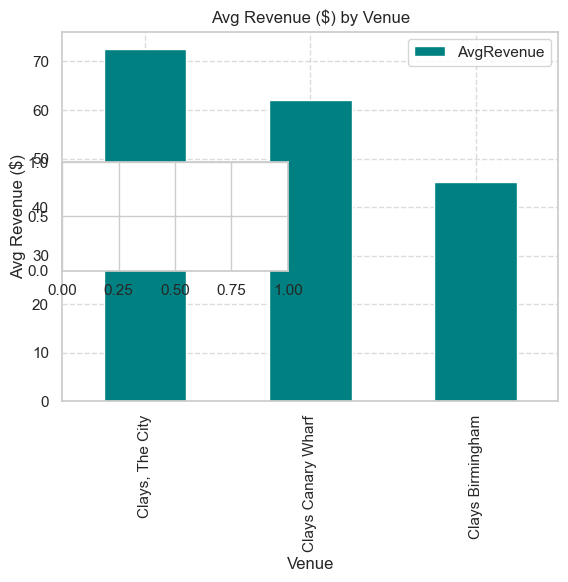

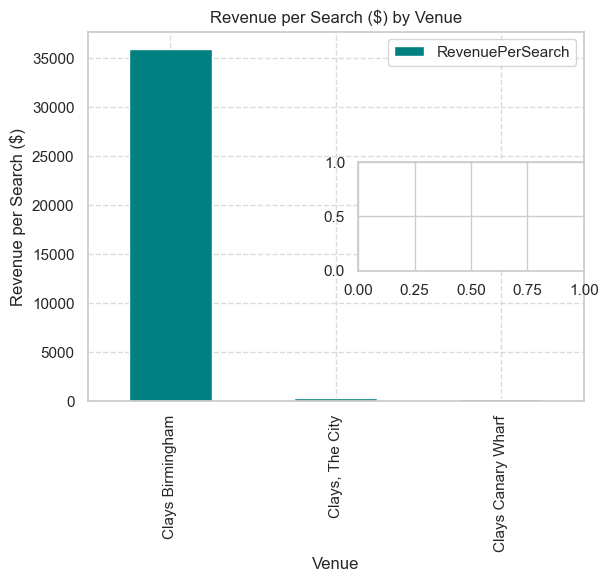

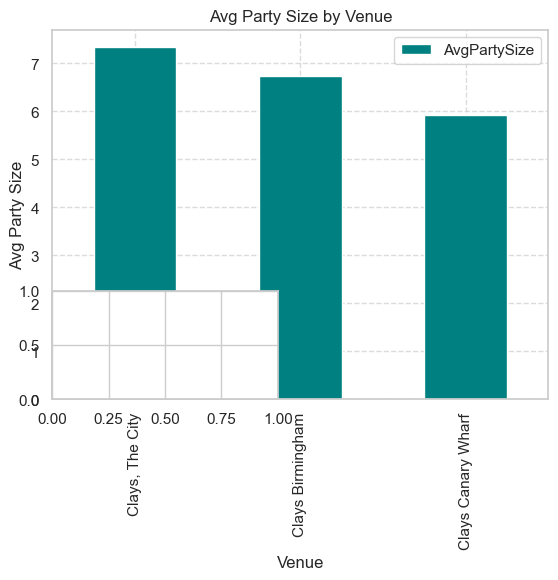

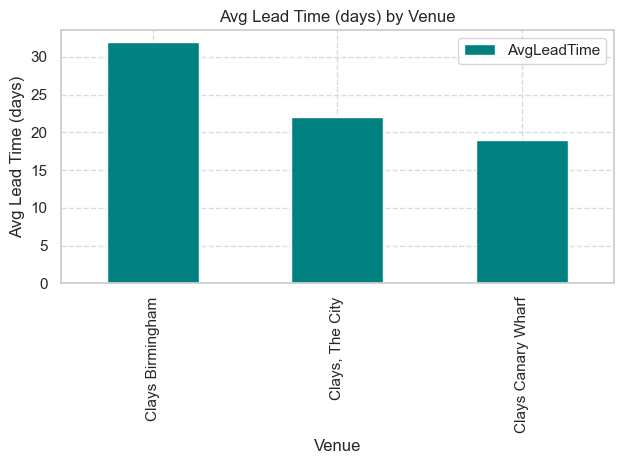


16.2 Monthly Performance by Venue
--------------------------------------------------


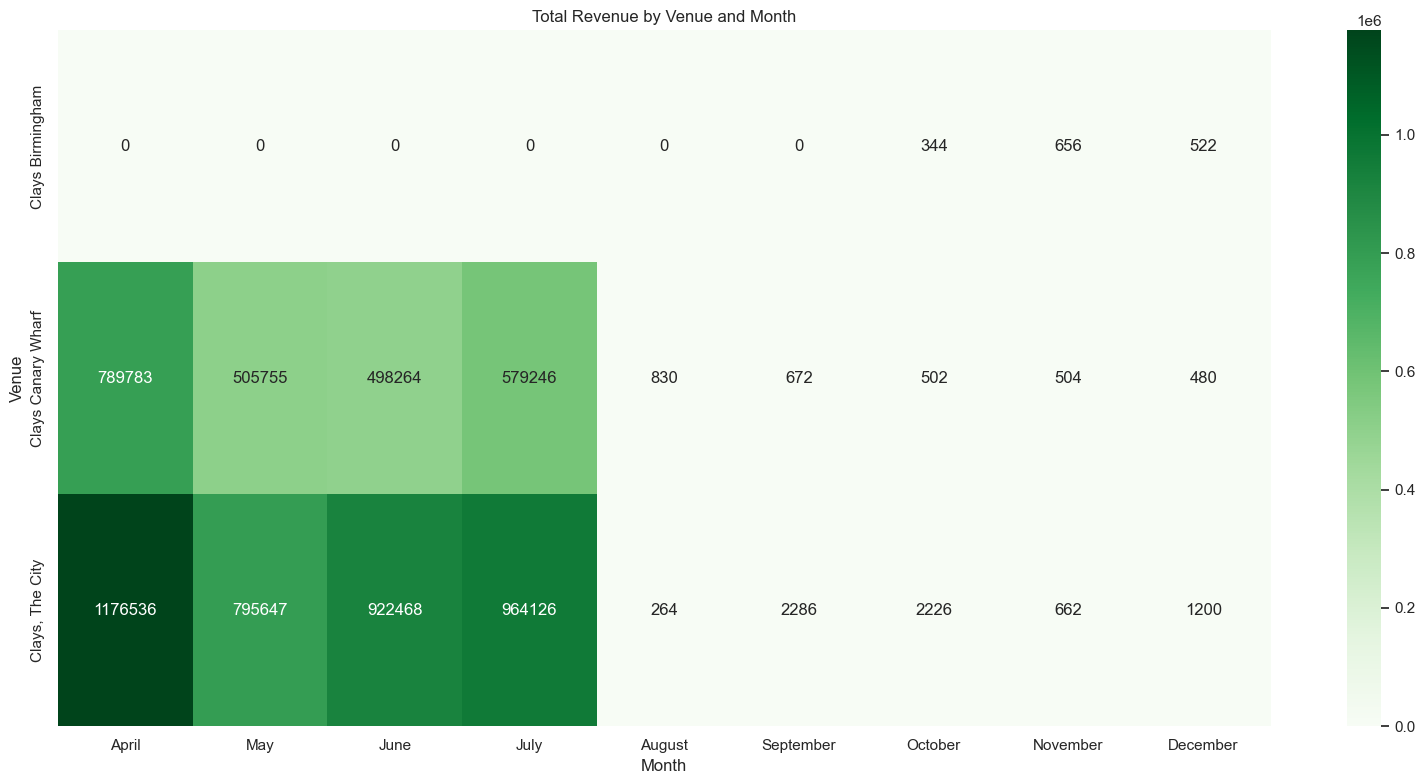

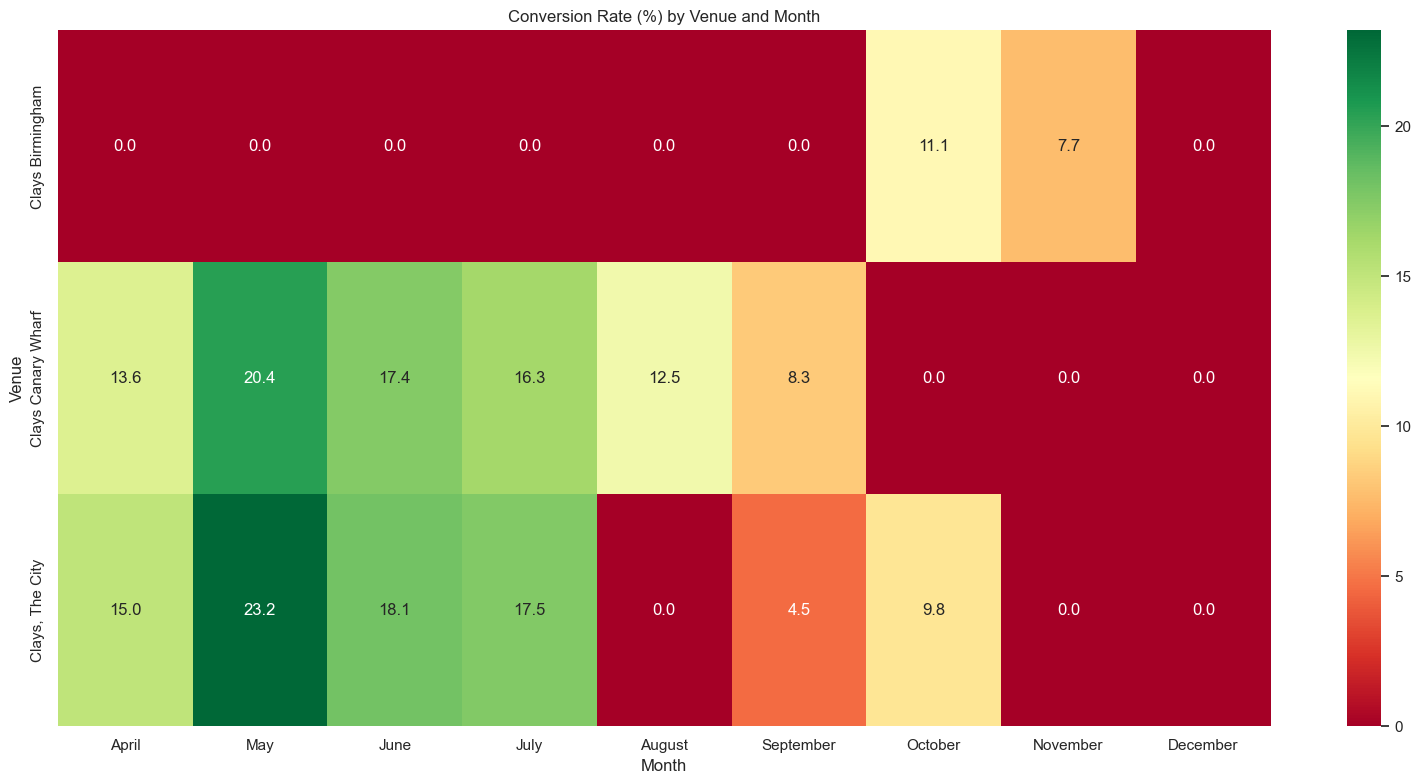


16.3 Party Size Analysis by Venue
--------------------------------------------------


<Figure size 1600x800 with 0 Axes>

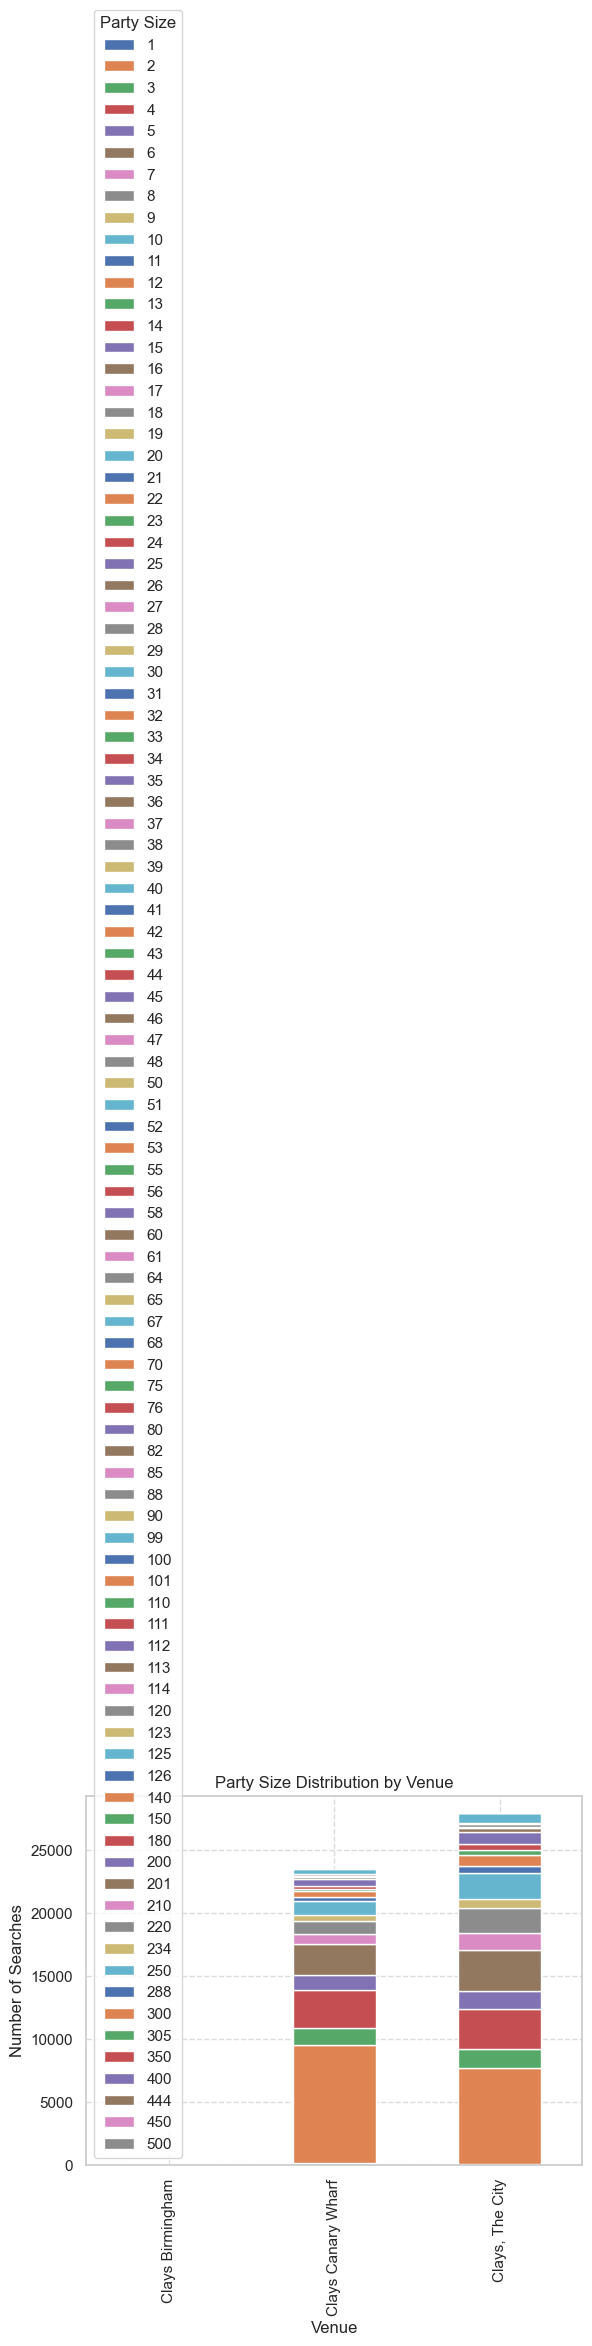

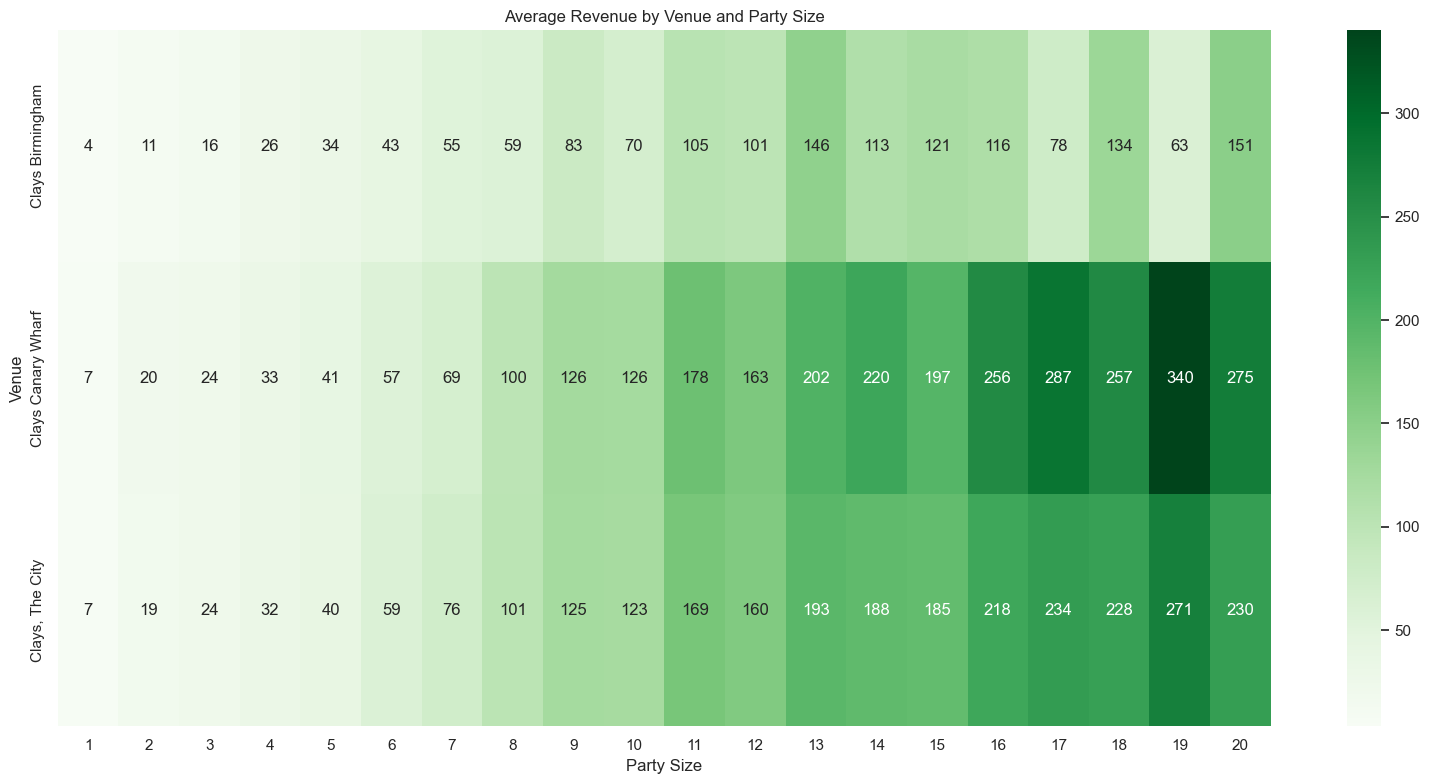


16.4 Lead Time Analysis by Venue
--------------------------------------------------


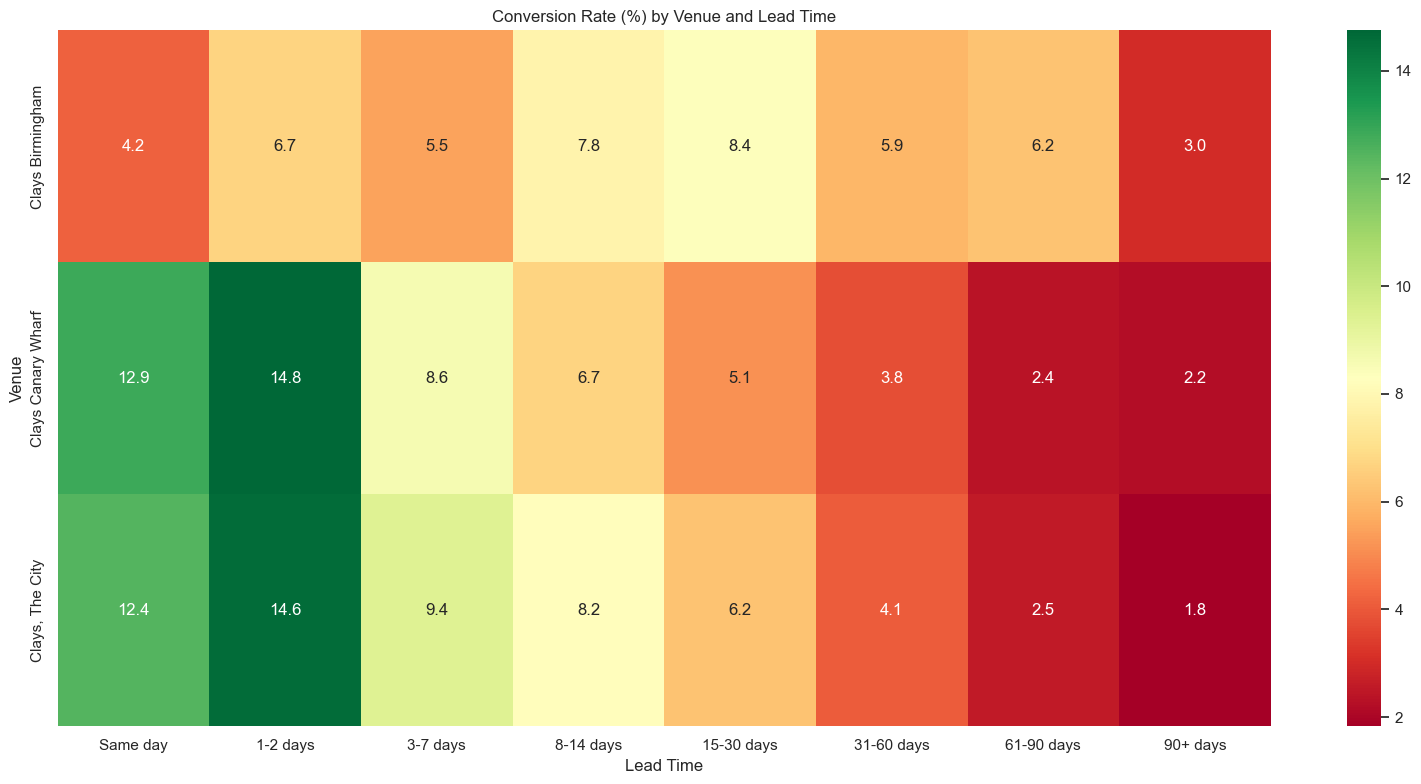

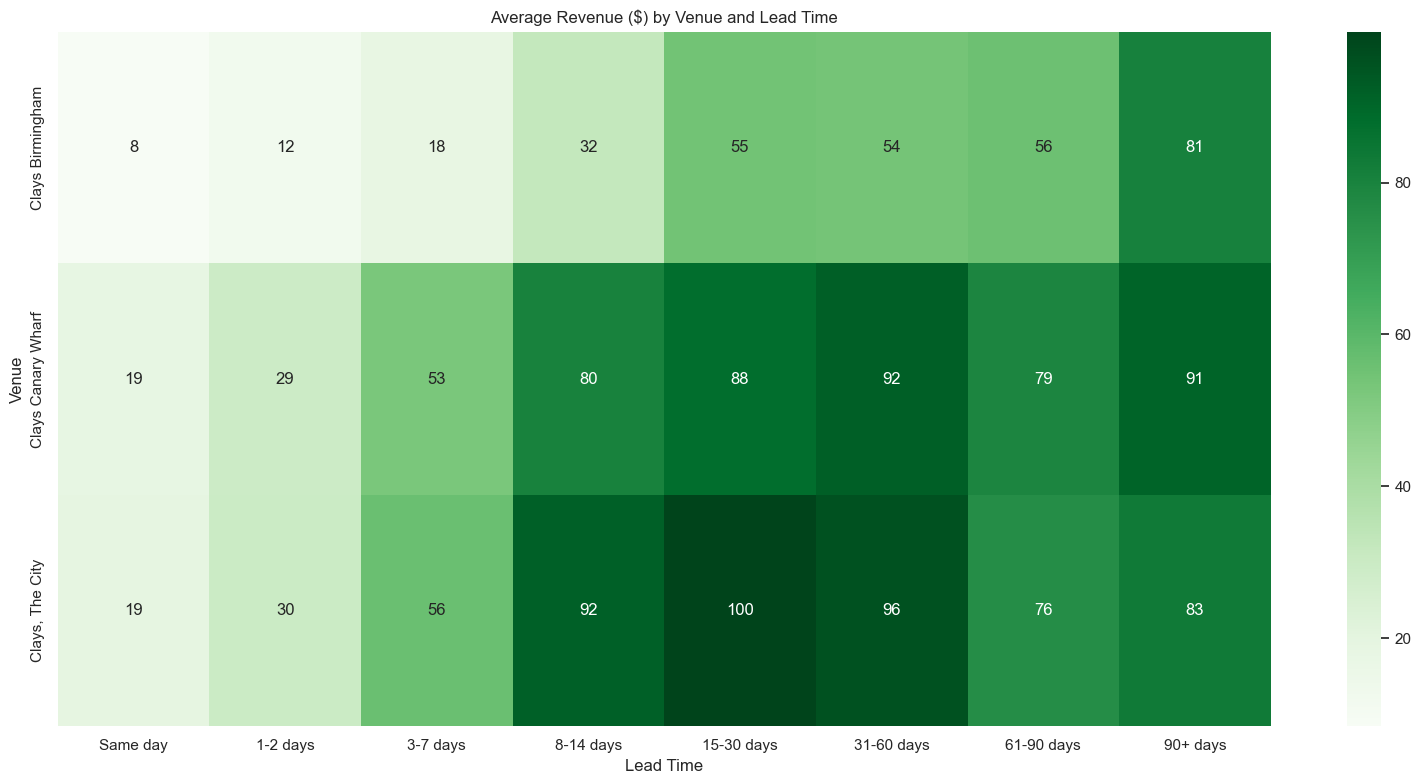

In [28]:
print("\n" + "="*80)
print("16. GROUPED INSIGHTS")
print("="*80)

print("\n16.1 Venue Performance Analysis")
print("-"*50)

if 'Venue Name' in df_clean.columns:
    # Create a comprehensive venue analysis
    venue_analysis = df_clean.groupby('Venue Name').agg({
        'Search At': 'count',
        'IsBooked': ['sum', 'mean'],
        'Total Cost ($)': ['sum', 'mean', 'median', 'std'],
        'Party Size': ['mean', 'median'],
        'Search Days Ahead': ['mean', 'median']
    }).reset_index()
    
    # Flatten multi-level columns
    venue_analysis.columns = [
        'Venue', 'Searches', 'Bookings', 'ConversionRate', 
        'TotalRevenue', 'AvgRevenue', 'MedianRevenue', 'StdRevenue',
        'AvgPartySize', 'MedianPartySize',
        'AvgLeadTime', 'MedianLeadTime'
    ]
    
    # Calculate additional metrics
    venue_analysis['ConversionRate'] = venue_analysis['ConversionRate'] * 100
    venue_analysis['RevenuePerSearch'] = venue_analysis['TotalRevenue'] / venue_analysis['Searches']
    venue_analysis['RevenueCoefficientOfVariation'] = venue_analysis['StdRevenue'] / venue_analysis['AvgRevenue'] * 100
    
    # Print comprehensive venue analysis
    print("Comprehensive Venue Performance Analysis:")
    print(venue_analysis)
    
    # Plot comparative bar charts for key metrics
    metrics = ['ConversionRate', 'AvgRevenue', 'RevenuePerSearch', 'AvgPartySize', 'AvgLeadTime']
    metric_labels = ['Conversion Rate (%)', 'Avg Revenue ($)', 'Revenue per Search ($)', 'Avg Party Size', 'Avg Lead Time (days)']
    
    plt.figure(figsize=(20, 15))
    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        plt.subplot(3, 2, i+1)
        venue_analysis.sort_values(metric, ascending=False).plot(x='Venue', y=metric, kind='bar', color='teal')
        plt.title(f'{label} by Venue')
        plt.xlabel('Venue')
        plt.ylabel(label)
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

print("\n16.2 Monthly Performance by Venue")
print("-"*50)

if 'Venue Name' in df_clean.columns:
    # Create a pivot table of revenue by venue and month
    venue_month_revenue = pd.pivot_table(
        df_clean,
        values='Total Cost ($)',
        index='Venue Name',
        columns='SearchMonthName',
        aggfunc='sum',
        fill_value=0
    )
    
    # Reorder months chronologically
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                  'July', 'August', 'September', 'October', 'November', 'December']
    available_months = [m for m in month_order if m in venue_month_revenue.columns]
    venue_month_revenue = venue_month_revenue.reindex(columns=available_months)
    
    # Plot venue-month heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(venue_month_revenue, cmap='Greens', annot=True, fmt='.0f')
    plt.title('Total Revenue by Venue and Month')
    plt.xlabel('Month')
    plt.ylabel('Venue')
    plt.tight_layout()
    plt.show()
    
    # Also create a conversion rate heatmap
    venue_month_conversion = pd.pivot_table(
        df_clean,
        values='IsBooked',
        index='Venue Name',
        columns='SearchMonthName',
        aggfunc='mean',
        fill_value=0
    ) * 100
    
    venue_month_conversion = venue_month_conversion.reindex(columns=available_months)
    
    plt.figure(figsize=(16, 8))
    sns.heatmap(venue_month_conversion, cmap='RdYlGn', annot=True, fmt='.1f')
    plt.title('Conversion Rate (%) by Venue and Month')
    plt.xlabel('Month')
    plt.ylabel('Venue')
    plt.tight_layout()
    plt.show()

print("\n16.3 Party Size Analysis by Venue")
print("-"*50)

if 'Venue Name' in df_clean.columns and 'Party Size' in df_clean.columns:
    # Analyze party size distribution by venue
    venue_party_size = pd.pivot_table(
        df_clean,
        values='Search At',
        index='Venue Name',
        columns='Party Size',
        aggfunc='count',
        fill_value=0
    )
    
    # Plot the distribution
    plt.figure(figsize=(16, 8))
    venue_party_size.plot(kind='bar', stacked=True)
    plt.title('Party Size Distribution by Venue')
    plt.xlabel('Venue')
    plt.ylabel('Number of Searches')
    plt.legend(title='Party Size')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Create a heatmap of average revenue by venue and party size
    venue_party_revenue = pd.pivot_table(
        df_clean,
        values='Total Cost ($)',
        index='Venue Name',
        columns='Party Size',
        aggfunc='mean',
        fill_value=0
    )
    
    # Filter out extreme party sizes for better visualization
    common_party_sizes = [size for size in venue_party_revenue.columns if size <= 20]
    venue_party_revenue = venue_party_revenue[common_party_sizes]
    
    plt.figure(figsize=(16, 8))
    sns.heatmap(venue_party_revenue, cmap='Greens', annot=True, fmt='.0f')
    plt.title('Average Revenue by Venue and Party Size')
    plt.xlabel('Party Size')
    plt.ylabel('Venue')
    plt.tight_layout()
    plt.show()

print("\n16.4 Lead Time Analysis by Venue")
print("-"*50)

if 'Venue Name' in df_clean.columns:
    # Create a pivot table of conversion rate by venue and lead time
    venue_leadtime_conversion = pd.pivot_table(
        df_clean,
        values='IsBooked',
        index='Venue Name',
        columns='LeadTimeBucket',
        aggfunc='mean',
        fill_value=0
    ) * 100
    
    plt.figure(figsize=(16, 8))
    sns.heatmap(venue_leadtime_conversion, cmap='RdYlGn', annot=True, fmt='.1f')
    plt.title('Conversion Rate (%) by Venue and Lead Time')
    plt.xlabel('Lead Time')
    plt.ylabel('Venue')
    plt.tight_layout()
    plt.show()
    
    # Create a pivot table of average revenue by venue and lead time
    venue_leadtime_revenue = pd.pivot_table(
        df_clean,
        values='Total Cost ($)',
        index='Venue Name',
        columns='LeadTimeBucket',
        aggfunc='mean',
        fill_value=0
    )
    
    plt.figure(figsize=(16, 8))
    sns.heatmap(venue_leadtime_revenue, cmap='Greens', annot=True, fmt='.0f')
    plt.title('Average Revenue ($) by Venue and Lead Time')
    plt.xlabel('Lead Time')
    plt.ylabel('Venue')
    plt.tight_layout()
    plt.show()

# 17. Outlier profiling by segment


17. OUTLIER PROFILING BY SEGMENT

17.1 Identifying Revenue Outliers
--------------------------------------------------
Revenue Outliers Analysis:
Lower bound: $-108.00
Upper bound: $180.00
Number of outliers: 25398 (10.02% of data)


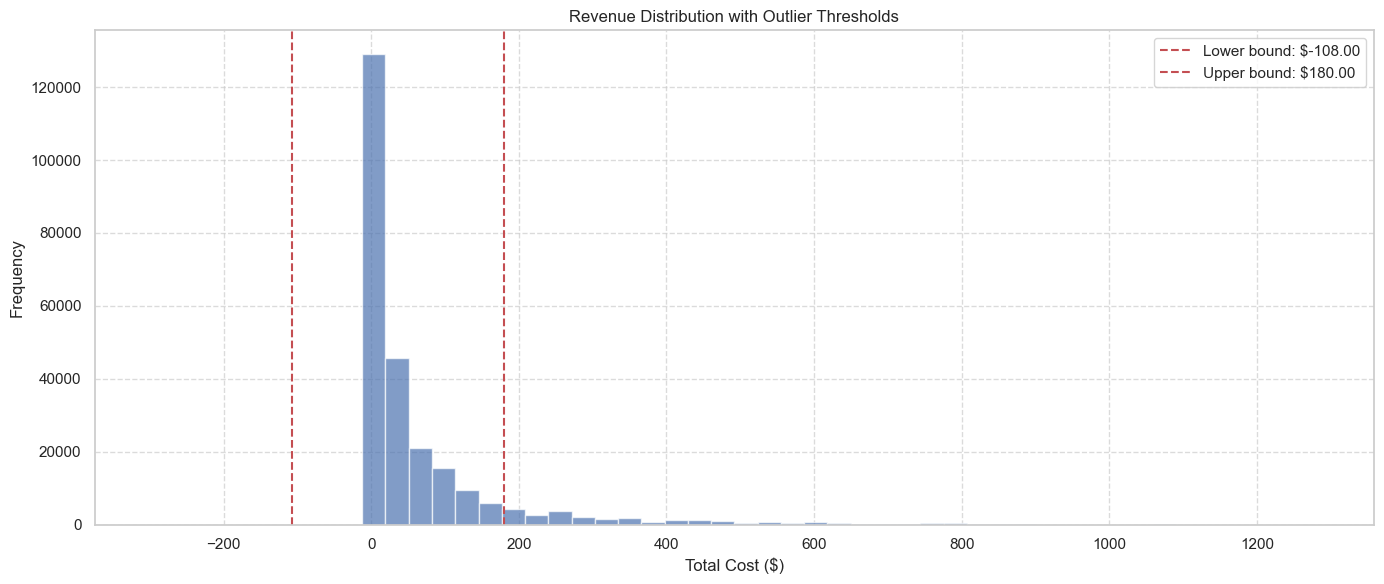


17.2 Outlier Profiling by Venue
--------------------------------------------------
Outlier Distribution by Venue:
                     total  outliers  outlier_pct
Clays Canary Wharf  100470      9549     9.504330
Clays, The City     128288     13334    10.393801
Clays Birmingham     24595      2067     8.404147


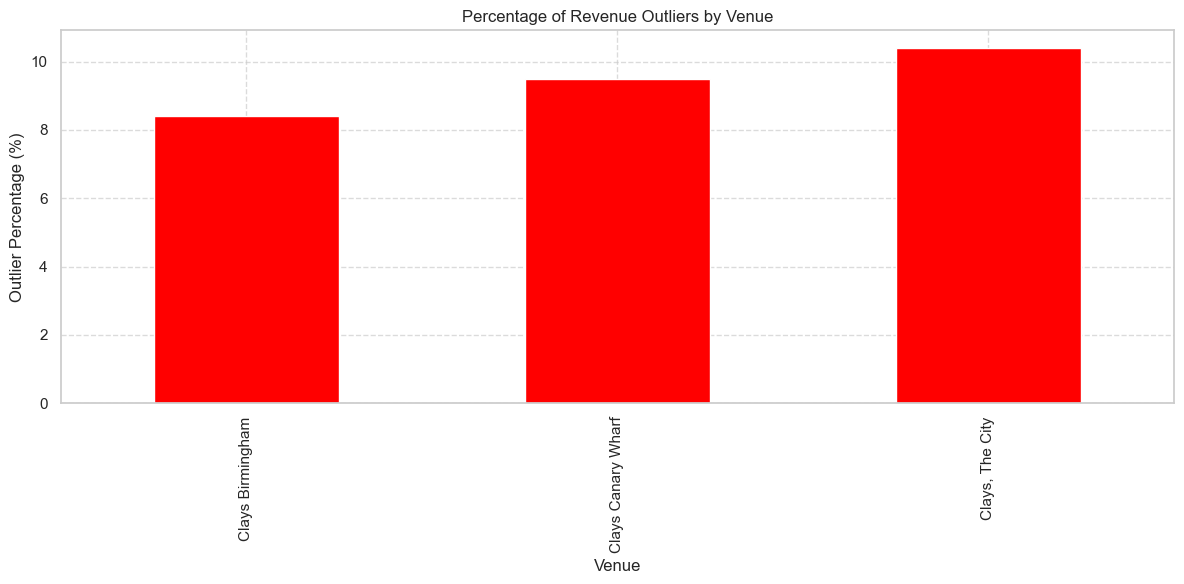

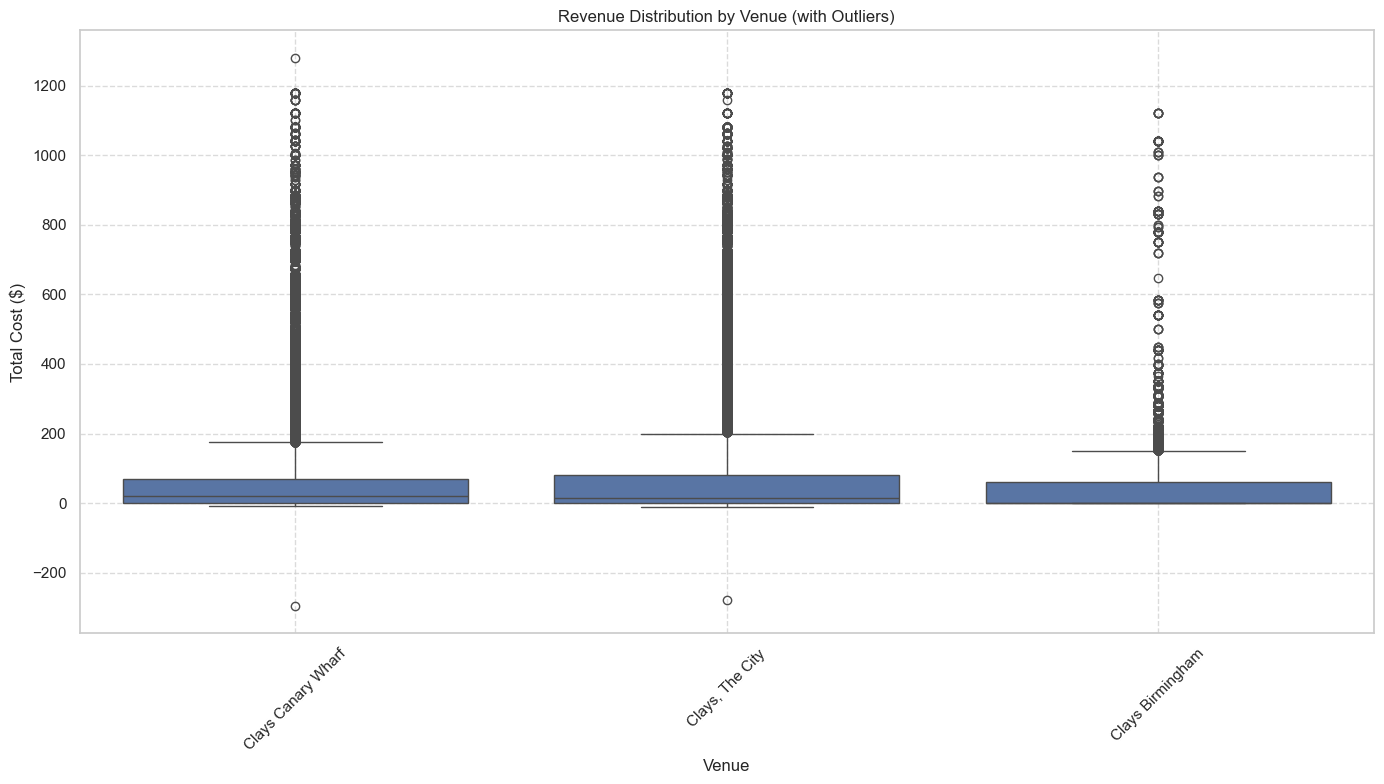


17.3 Outlier Profiling by Party Size
--------------------------------------------------


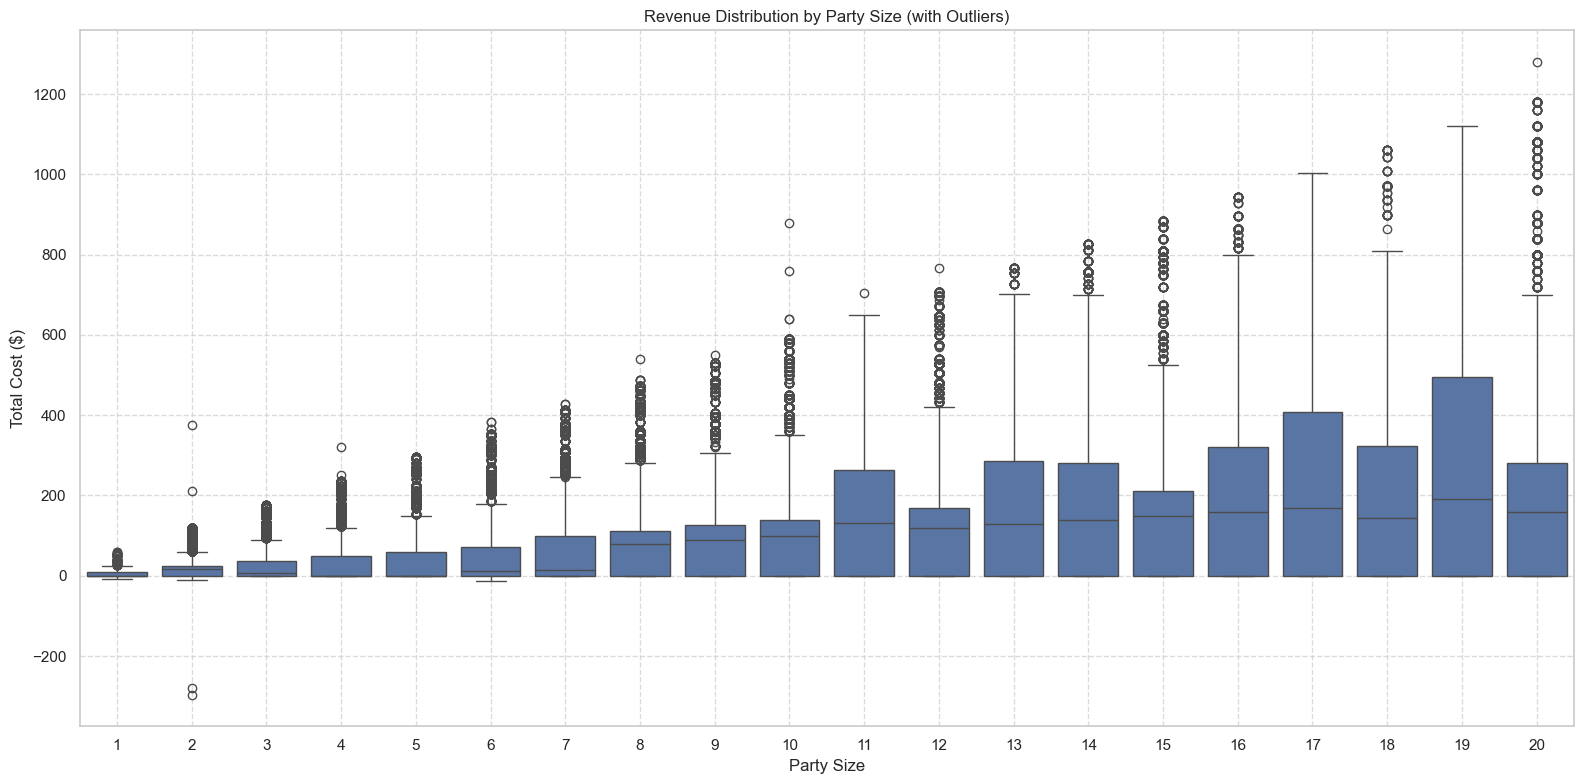

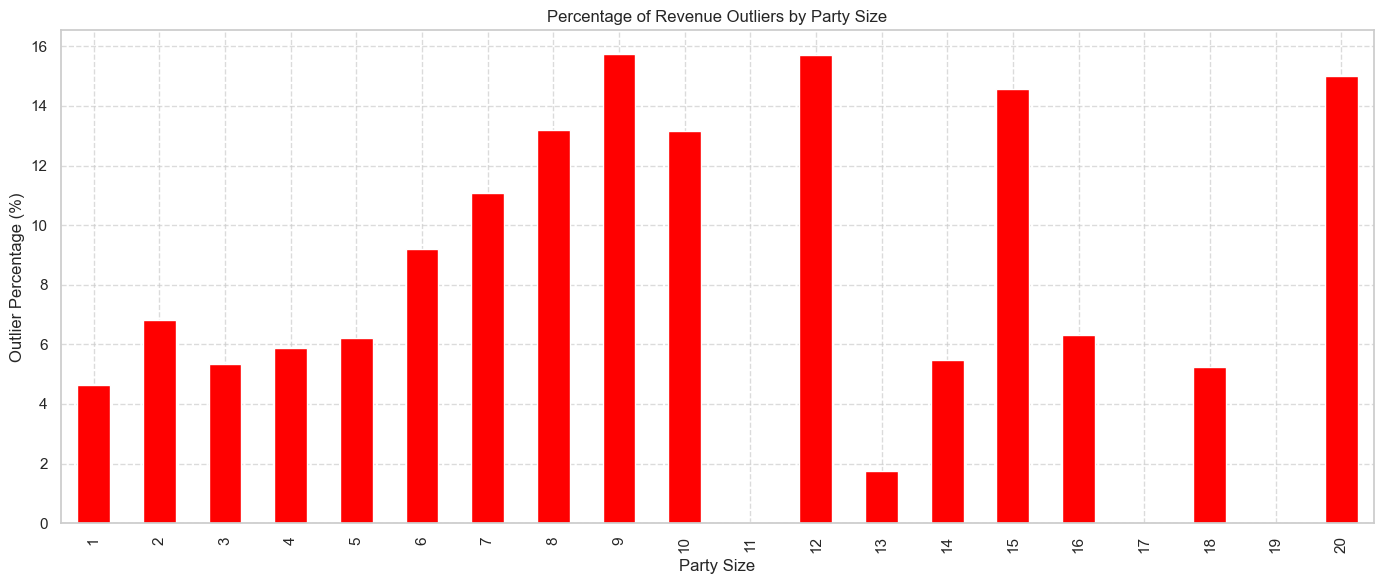


17.4 Outlier Profiling by Lead Time
--------------------------------------------------


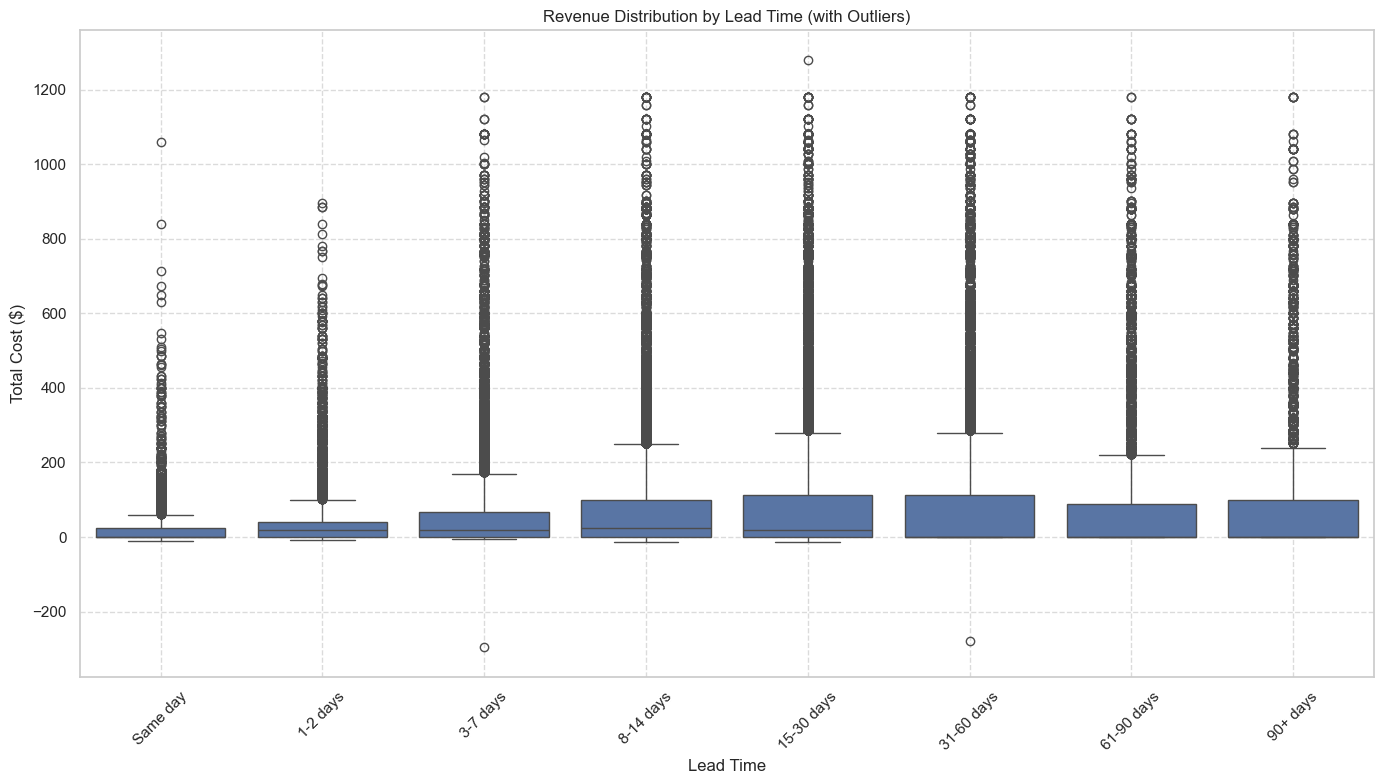

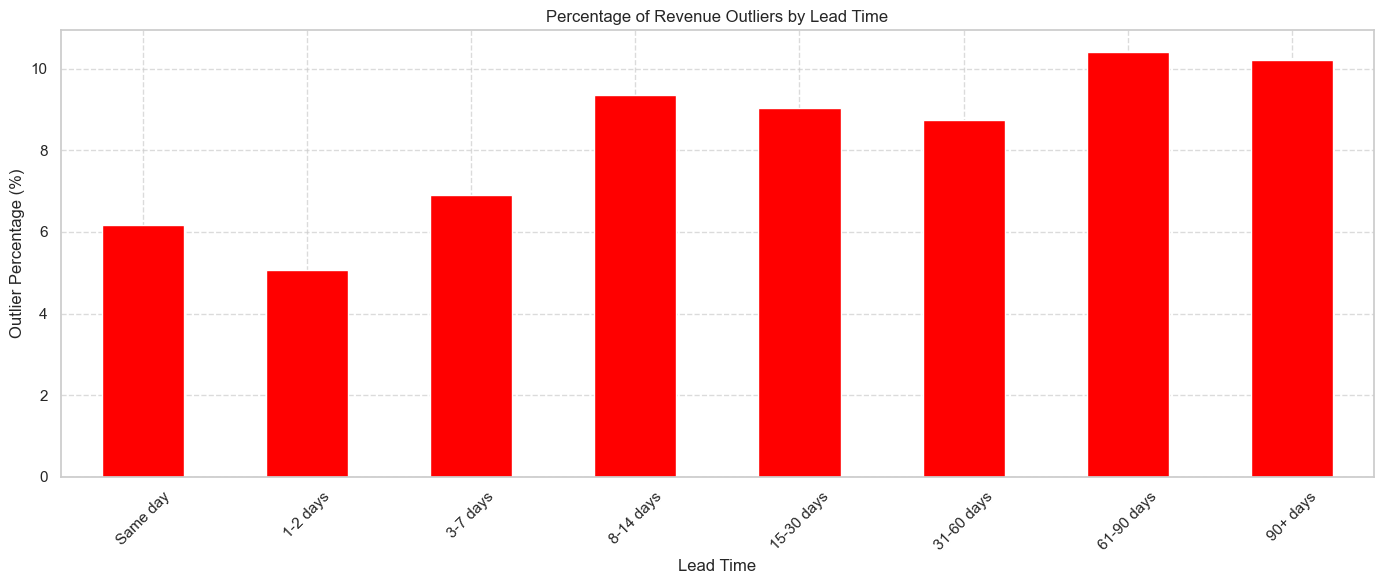


17.5 Investigating Causes of Outliers
--------------------------------------------------
Outlier vs Non-Outlier Comparison:
   IsOutlier  Total Cost ($)  Packages Cost ($)  Add Ons Cost ($)  Party Size
0      False       30.217462           5.971823          0.143441    6.169349
1       True      384.563422         237.522836          4.793251   11.628987


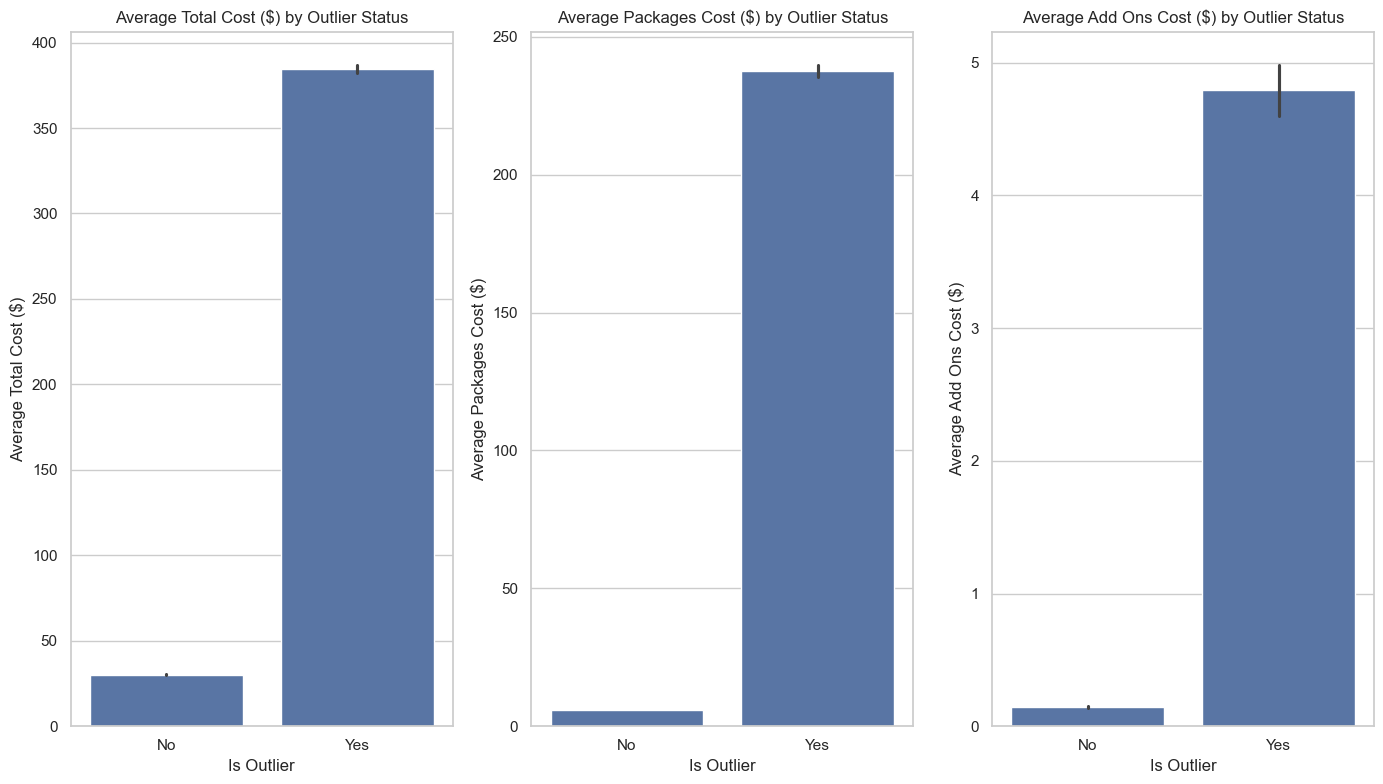

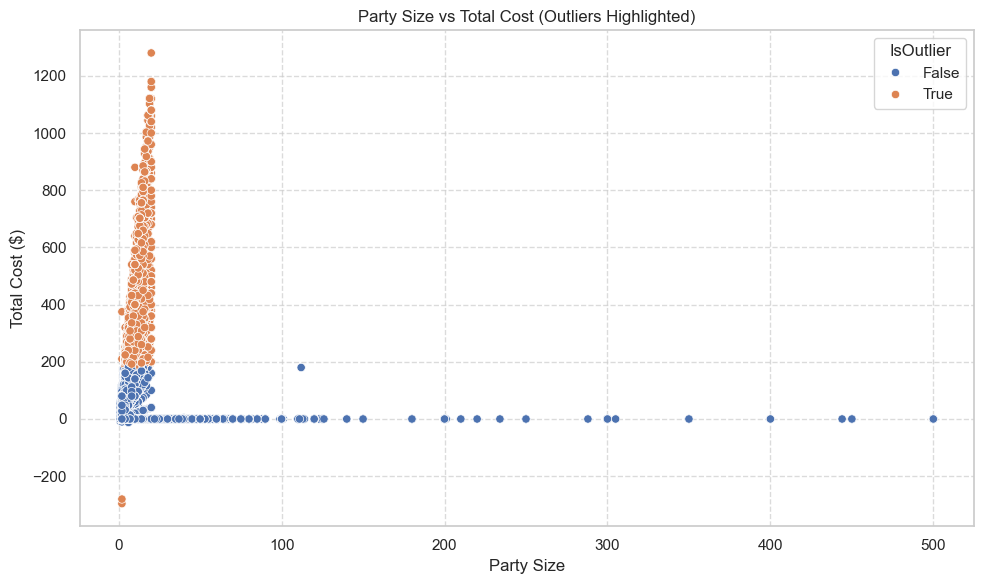

In [29]:
print("\n" + "="*80)
print("17. OUTLIER PROFILING BY SEGMENT")
print("="*80)

print("\n17.1 Identifying Revenue Outliers")
print("-"*50)

# Define a function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Find revenue outliers
revenue_outliers, lower_bound, upper_bound = detect_outliers_iqr(df_clean, 'Total Cost ($)')

print(f"Revenue Outliers Analysis:")
print(f"Lower bound: ${lower_bound:.2f}")
print(f"Upper bound: ${upper_bound:.2f}")
print(f"Number of outliers: {len(revenue_outliers)} ({len(revenue_outliers)/len(df_clean)*100:.2f}% of data)")

# Plot the revenue distribution with outlier thresholds
plt.figure(figsize=(14, 6))
plt.hist(df_clean['Total Cost ($)'], bins=50, alpha=0.7)
plt.axvline(x=lower_bound, color='r', linestyle='--', label=f'Lower bound: ${lower_bound:.2f}')
plt.axvline(x=upper_bound, color='r', linestyle='--', label=f'Upper bound: ${upper_bound:.2f}')
plt.title('Revenue Distribution with Outlier Thresholds')
plt.xlabel('Total Cost ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n17.2 Outlier Profiling by Venue")
print("-"*50)

if 'Venue Name' in df_clean.columns:
    # Calculate outlier percentage by venue
    venue_outliers = {}
    for venue in df_clean['Venue Name'].unique():
        venue_df = df_clean[df_clean['Venue Name'] == venue]
        venue_outliers_df, _, _ = detect_outliers_iqr(venue_df, 'Total Cost ($)')
        venue_outliers[venue] = {
            'total': len(venue_df),
            'outliers': len(venue_outliers_df),
            'outlier_pct': len(venue_outliers_df) / len(venue_df) * 100
        }
    
    venue_outliers_df = pd.DataFrame.from_dict(venue_outliers, orient='index')
    
    print("Outlier Distribution by Venue:")
    print(venue_outliers_df)
    
    # Plot outlier percentage by venue
    plt.figure(figsize=(12, 6))
    venue_outliers_df['outlier_pct'].sort_values().plot(kind='bar', color='red')
    plt.title('Percentage of Revenue Outliers by Venue')
    plt.xlabel('Venue')
    plt.ylabel('Outlier Percentage (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Create box plots by venue
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Venue Name', y='Total Cost ($)', data=df_clean)
    plt.title('Revenue Distribution by Venue (with Outliers)')
    plt.xlabel('Venue')
    plt.ylabel('Total Cost ($)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\n17.3 Outlier Profiling by Party Size")
print("-"*50)

if 'Party Size' in df_clean.columns:
    # Filter to common party sizes for better visualization
    common_sizes_df = df_clean[df_clean['Party Size'] <= 20]
    
    # Create box plots by party size
    plt.figure(figsize=(16, 8))
    sns.boxplot(x='Party Size', y='Total Cost ($)', data=common_sizes_df)
    plt.title('Revenue Distribution by Party Size (with Outliers)')
    plt.xlabel('Party Size')
    plt.ylabel('Total Cost ($)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Calculate outlier percentage by party size
    party_size_outliers = {}
    for size in common_sizes_df['Party Size'].unique():
        size_df = common_sizes_df[common_sizes_df['Party Size'] == size]
        size_outliers_df, _, _ = detect_outliers_iqr(size_df, 'Total Cost ($)')
        party_size_outliers[size] = {
            'total': len(size_df),
            'outliers': len(size_outliers_df),
            'outlier_pct': len(size_outliers_df) / len(size_df) * 100 if len(size_df) > 0 else 0
        }
    
    party_size_outliers_df = pd.DataFrame.from_dict(party_size_outliers, orient='index')
    party_size_outliers_df = party_size_outliers_df.sort_index()
    
    # Plot outlier percentage by party size
    plt.figure(figsize=(14, 6))
    party_size_outliers_df['outlier_pct'].plot(kind='bar', color='red')
    plt.title('Percentage of Revenue Outliers by Party Size')
    plt.xlabel('Party Size')
    plt.ylabel('Outlier Percentage (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\n17.4 Outlier Profiling by Lead Time")
print("-"*50)

# Create box plots by lead time
plt.figure(figsize=(14, 8))
sns.boxplot(x='LeadTimeBucket', y='Total Cost ($)', data=df_clean)
plt.title('Revenue Distribution by Lead Time (with Outliers)')
plt.xlabel('Lead Time')
plt.ylabel('Total Cost ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate outlier percentage by lead time
lead_time_outliers = {}
for bucket in df_clean['LeadTimeBucket'].unique():
    bucket_df = df_clean[df_clean['LeadTimeBucket'] == bucket]
    bucket_outliers_df, _, _ = detect_outliers_iqr(bucket_df, 'Total Cost ($)')
    lead_time_outliers[bucket] = {
        'total': len(bucket_df),
        'outliers': len(bucket_outliers_df),
        'outlier_pct': len(bucket_outliers_df) / len(bucket_df) * 100 if len(bucket_df) > 0 else 0
    }

lead_time_outliers_df = pd.DataFrame.from_dict(lead_time_outliers, orient='index')

# Reorder lead time buckets
if all(bucket in lead_time_outliers_df.index for bucket in lead_time_labels):
    lead_time_outliers_df = lead_time_outliers_df.reindex(lead_time_labels)

# Plot outlier percentage by lead time
plt.figure(figsize=(14, 6))
lead_time_outliers_df['outlier_pct'].plot(kind='bar', color='red')
plt.title('Percentage of Revenue Outliers by Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Outlier Percentage (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n17.5 Investigating Causes of Outliers")
print("-"*50)

# Check if packages or add-ons contribute to outliers
if 'Packages Cost ($)' in df_clean.columns and 'Add Ons Cost ($)' in df_clean.columns:
    # Compare package and add-on distribution for outliers vs non-outliers
    outlier_indices = revenue_outliers.index
    df_clean['IsOutlier'] = df_clean.index.isin(outlier_indices)
    
    # Calculate average costs for outliers vs non-outliers
    outlier_comparison = df_clean.groupby('IsOutlier').agg({
        'Total Cost ($)': 'mean',
        'Packages Cost ($)': 'mean',
        'Add Ons Cost ($)': 'mean',
        'Party Size': 'mean'
    }).reset_index()
    
    print("Outlier vs Non-Outlier Comparison:")
    print(outlier_comparison)
    
    # Plot the comparison
    plt.figure(figsize=(14, 8))
    metrics = ['Total Cost ($)', 'Packages Cost ($)', 'Add Ons Cost ($)']
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        sns.barplot(x='IsOutlier', y=metric, data=df_clean)
        plt.title(f'Average {metric} by Outlier Status')
        plt.xlabel('Is Outlier')
        plt.ylabel(f'Average {metric}')
        plt.xticks([0, 1], ['No', 'Yes'])
    
    plt.tight_layout()
    plt.show()
    
    # Check if there's a relationship between party size and outliers
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Party Size', y='Total Cost ($)', hue='IsOutlier', data=df_clean)
    plt.title('Party Size vs Total Cost (Outliers Highlighted)')
    plt.xlabel('Party Size')
    plt.ylabel('Total Cost ($)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# 18. Feature interactions & correlations


18. FEATURE INTERACTIONS & CORRELATIONS

18.1 Correlation Analysis
--------------------------------------------------


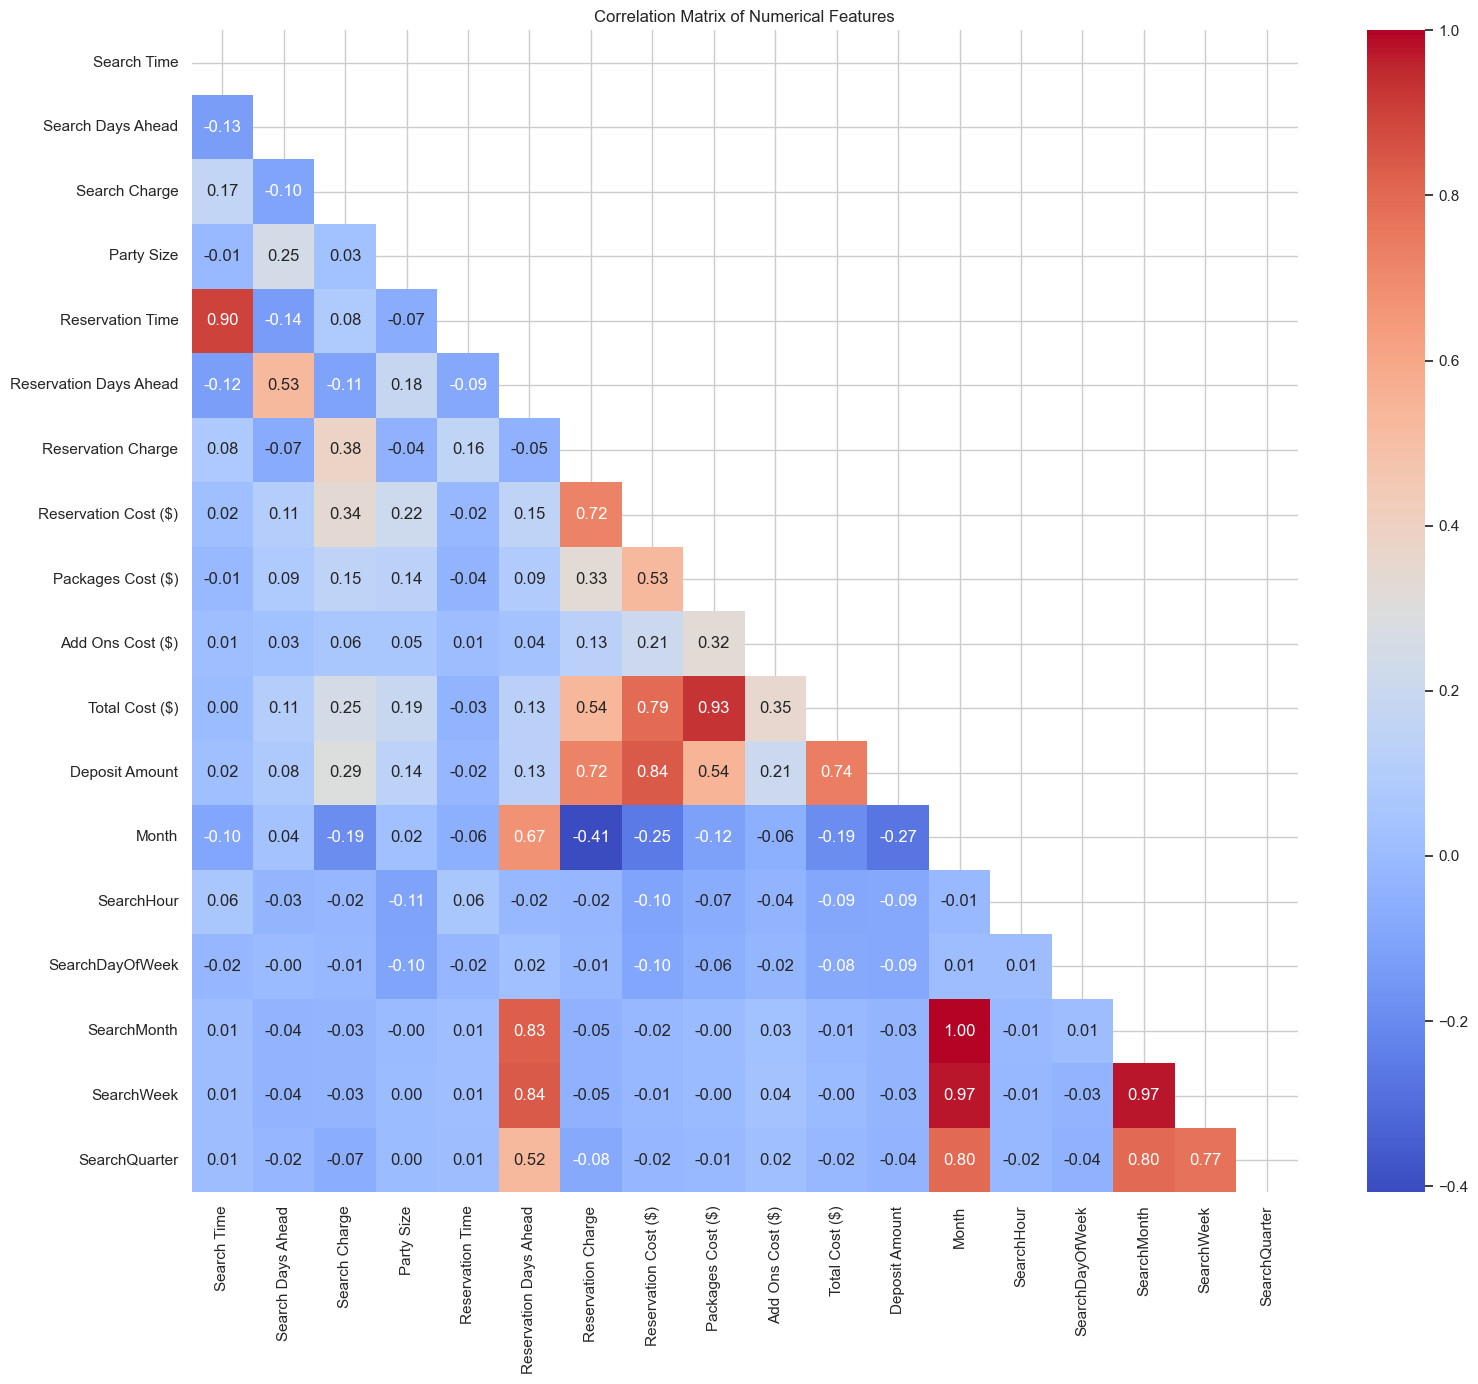

Top 10 Feature Correlations:
Month vs SearchMonth: 1.000
Month vs SearchWeek: 0.974
SearchMonth vs SearchWeek: 0.974
Packages Cost ($) vs Total Cost ($): 0.933
Search Time vs Reservation Time: 0.898
Reservation Cost ($) vs Deposit Amount: 0.840
Reservation Days Ahead vs SearchWeek: 0.839
Reservation Days Ahead vs SearchMonth: 0.829
Month vs SearchQuarter: 0.797
SearchMonth vs SearchQuarter: 0.797

18.2 Key Feature Pair Analysis
--------------------------------------------------


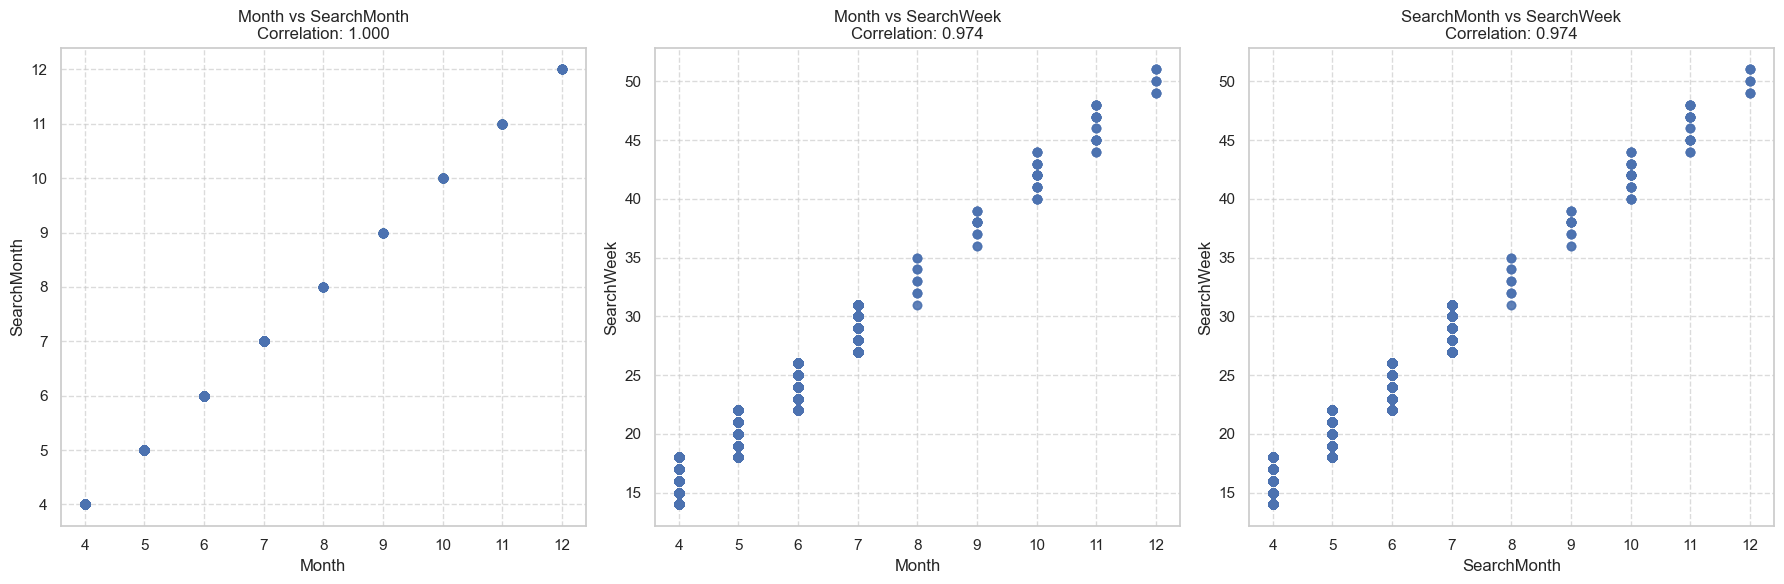


18.3 Party Size vs Total Cost Relationship
--------------------------------------------------


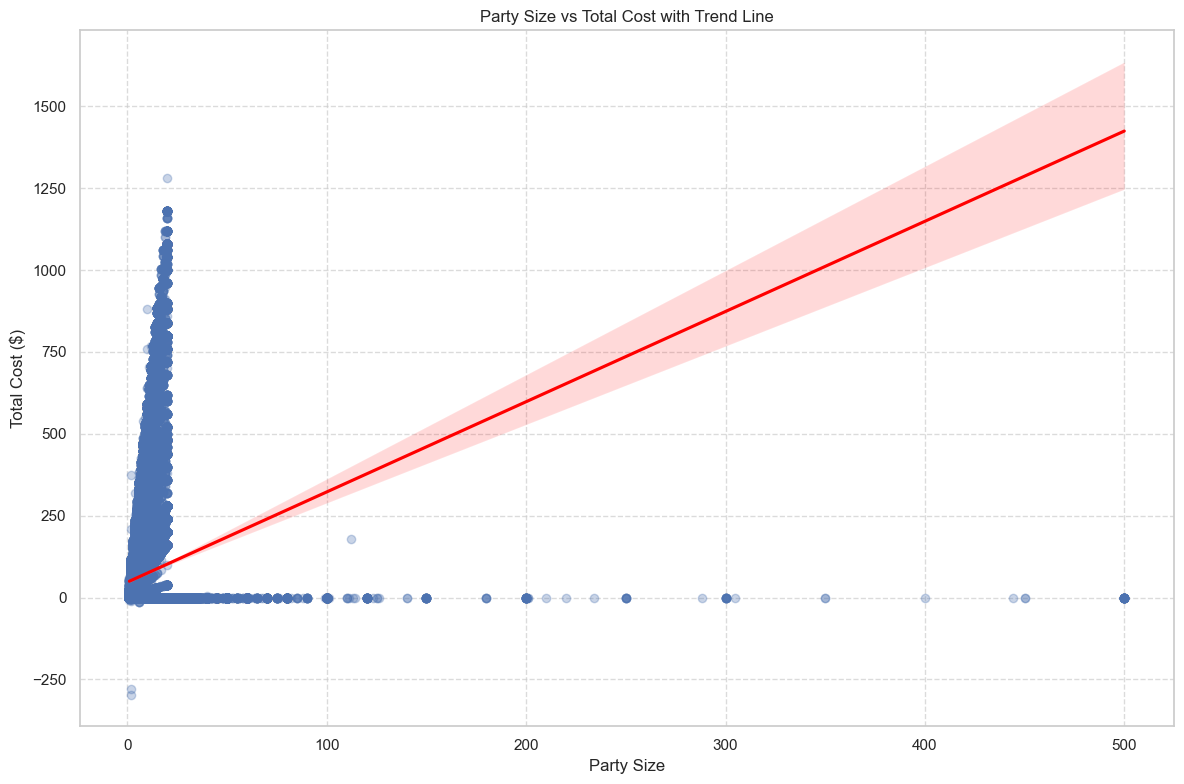

<Figure size 1400x800 with 0 Axes>

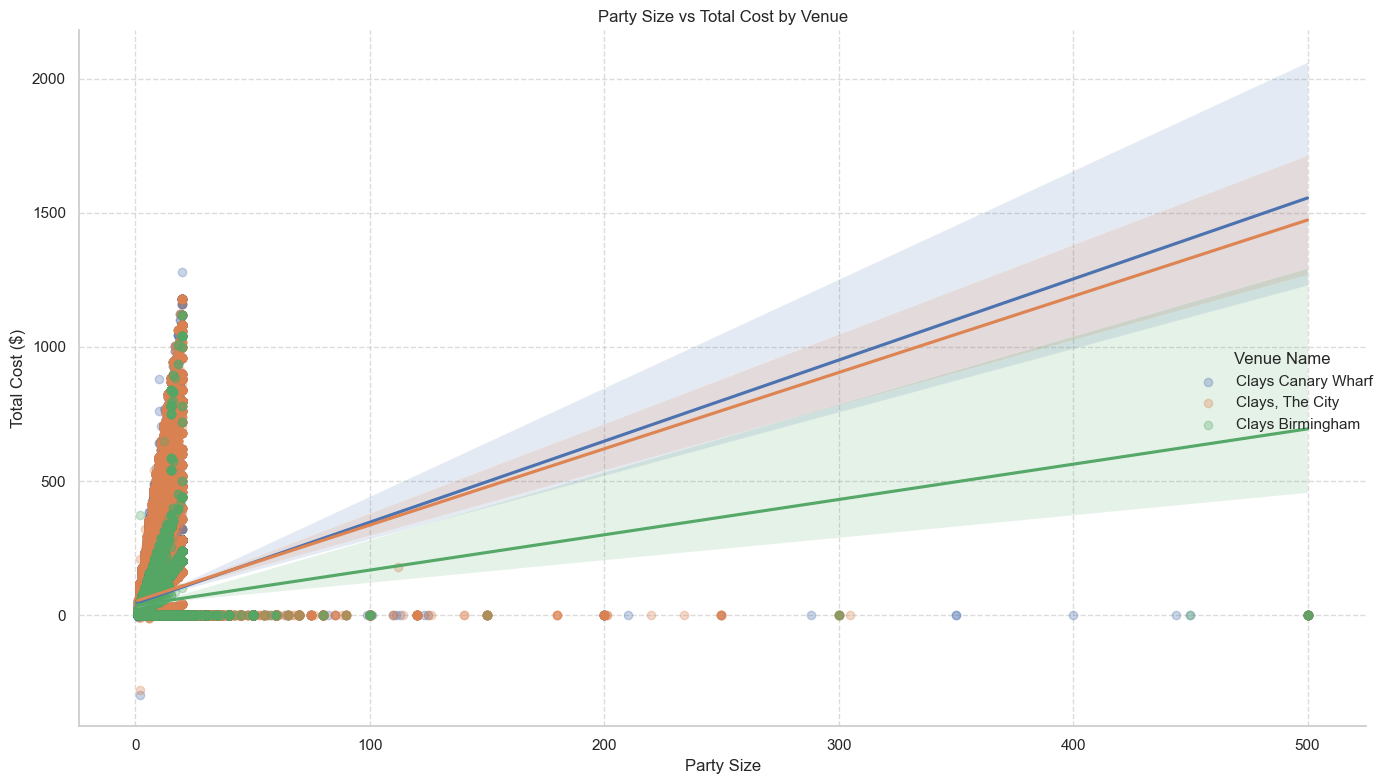


18.4 Day-Hour Interaction Effect on Conversion
--------------------------------------------------

18.5 Lead Time vs Party Size Interaction
--------------------------------------------------


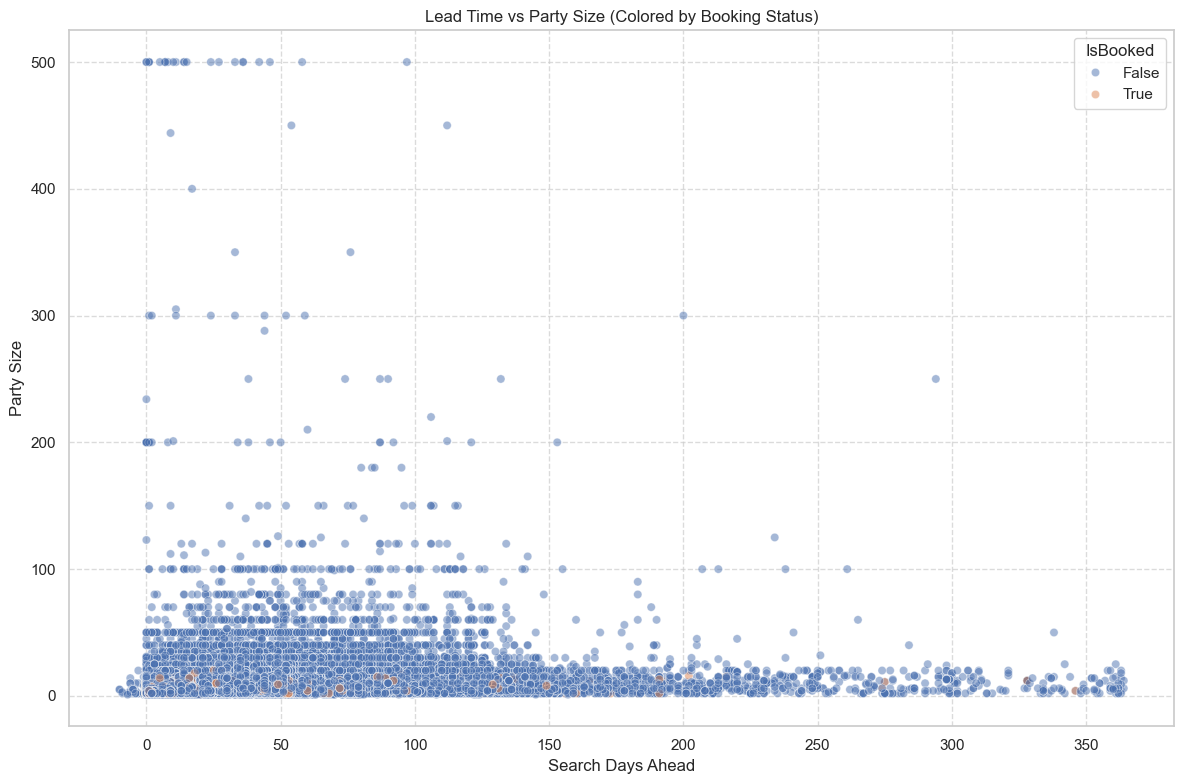

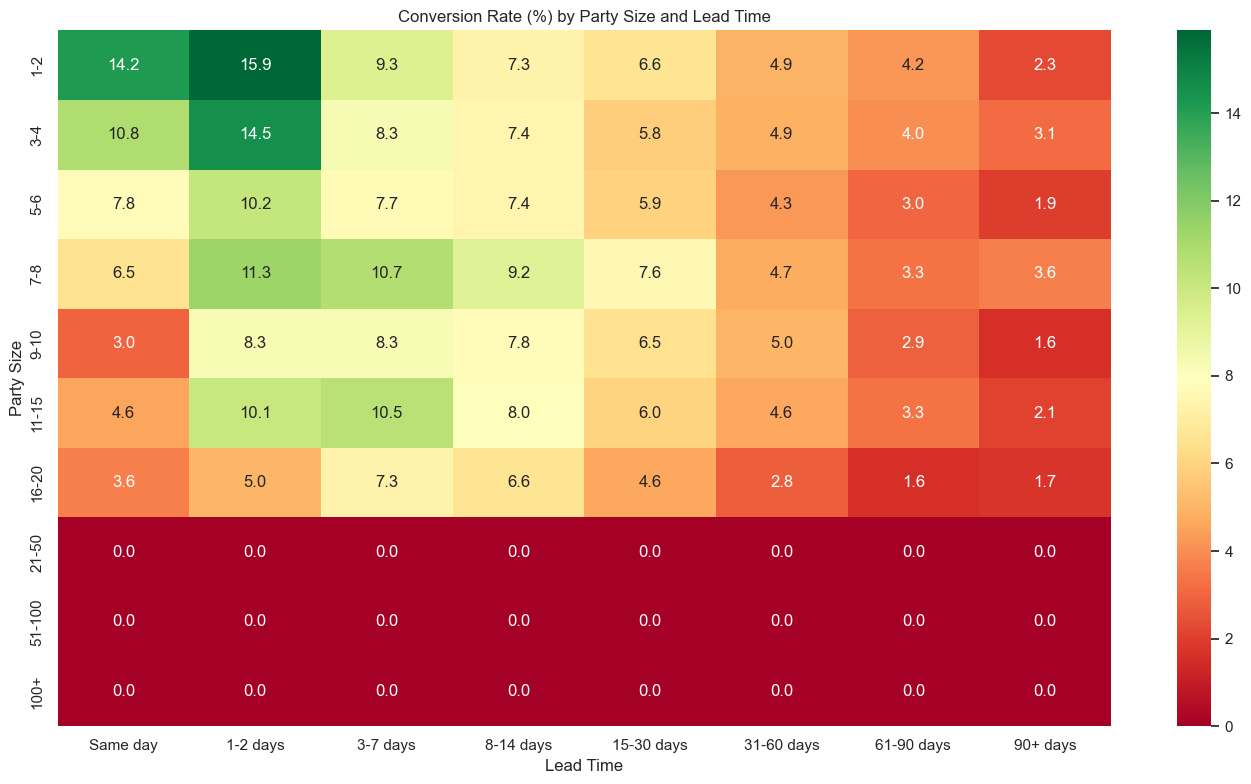

In [30]:
print("\n" + "="*80)
print("18. FEATURE INTERACTIONS & CORRELATIONS")
print("="*80)

print("\n18.1 Correlation Analysis")
print("-"*50)

# Select numerical columns
numerical_cols = df_clean.select_dtypes(include=['number']).columns.tolist()

# Filter out ID columns and other non-meaningful columns
exclude_patterns = ['ID', 'Reference', 'Code', 'Year']
numerical_cols = [col for col in numerical_cols if not any(pattern in col for pattern in exclude_patterns)]

# Calculate correlation matrix
corr_matrix = df_clean[numerical_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Find top correlations
corr_pairs = []
for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        corr_pairs.append((
            numerical_cols[i], 
            numerical_cols[j], 
            corr_matrix.iloc[i, j]
        ))

# Sort by absolute correlation value
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("Top 10 Feature Correlations:")
for pair in corr_pairs[:10]:
    print(f"{pair[0]} vs {pair[1]}: {pair[2]:.3f}")

print("\n18.2 Key Feature Pair Analysis")
print("-"*50)

# If we found strong correlations, let's plot the top 3
if len(corr_pairs) >= 3:
    plt.figure(figsize=(18, 6))
    
    for i, pair in enumerate(corr_pairs[:3]):
        plt.subplot(1, 3, i+1)
        plt.scatter(df_clean[pair[0]], df_clean[pair[1]], alpha=0.5)
        plt.title(f'{pair[0]} vs {pair[1]}\nCorrelation: {pair[2]:.3f}')
        plt.xlabel(pair[0])
        plt.ylabel(pair[1])
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

print("\n18.3 Party Size vs Total Cost Relationship")
print("-"*50)

if 'Party Size' in df_clean.columns and 'Total Cost ($)' in df_clean.columns:
    # Create a scatter plot with trend line
    plt.figure(figsize=(12, 8))
    sns.regplot(x='Party Size', y='Total Cost ($)', data=df_clean, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title('Party Size vs Total Cost with Trend Line')
    plt.xlabel('Party Size')
    plt.ylabel('Total Cost ($)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Analyze by venue if available
    if 'Venue Name' in df_clean.columns:
        plt.figure(figsize=(14, 8))
        sns.lmplot(x='Party Size', y='Total Cost ($)', hue='Venue Name', data=df_clean, scatter_kws={'alpha':0.3}, height=8, aspect=1.5)
        plt.title('Party Size vs Total Cost by Venue')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

print("\n18.4 Day-Hour Interaction Effect on Conversion")
print("-"*50)

# Already created earlier in the day-hour heatmaps

print("\n18.5 Lead Time vs Party Size Interaction")
print("-"*50)

if 'Party Size' in df_clean.columns and 'Search Days Ahead' in df_clean.columns:
    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Search Days Ahead', y='Party Size', hue='IsBooked', data=df_clean, alpha=0.5)
    plt.title('Lead Time vs Party Size (Colored by Booking Status)')
    plt.xlabel('Search Days Ahead')
    plt.ylabel('Party Size')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Create a heatmap of conversion rate by party size and lead time
    # Bin party sizes for better analysis
    party_size_bins = [0, 2, 4, 6, 8, 10, 15, 20, 50, 100, np.inf]
    party_size_labels = ['1-2', '3-4', '5-6', '7-8', '9-10', '11-15', '16-20', '21-50', '51-100', '100+']
    
    df_clean['PartySizeBin'] = pd.cut(df_clean['Party Size'], bins=party_size_bins, labels=party_size_labels)
    
    # Create conversion rate pivot table
    party_lead_conversion = pd.pivot_table(
        df_clean,
        values='IsBooked',
        index='PartySizeBin',
        columns='LeadTimeBucket',
        aggfunc='mean',
        fill_value=0
    ) * 100
    
    # Plot heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(party_lead_conversion, cmap='RdYlGn', annot=True, fmt='.1f')
    plt.title('Conversion Rate (%) by Party Size and Lead Time')
    plt.xlabel('Lead Time')
    plt.ylabel('Party Size')
    plt.tight_layout()
    plt.show()

In [31]:
print("\n" + "="*80)
print("19. PRE-MODEL DATA SANITY CHECKS")
print("="*80)

# Convert date columns to datetime
print("\nConverting date columns to datetime...")
date_columns = [col for col in df_clean.columns if 'Date' in col or 'At' in col]
for col in date_columns:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        print(f"✓ Converted {col} to datetime")
    except Exception as e:
        print(f"✗ Could not convert {col}: {str(e)}")

# Check data types
print("\nData types check:")
print(df_clean.dtypes.value_counts())

# Check for duplicates
print("\nChecking for duplicates...")
duplicates = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    # Find and show example duplicates
    duplicate_rows = df_clean[df_clean.duplicated(keep=False)]
    print(f"\nExample duplicate rows:\n{duplicate_rows.head()}")
else:
    print("No duplicates found.")

# Check for near-duplicates (same booking ID but slightly different data)
if 'Booking ID' in df_clean.columns:
    print("\nChecking for near-duplicates (same Booking ID)...")
    booking_counts = df_clean['Booking ID'].value_counts()
    potential_near_duplicates = booking_counts[booking_counts > 1]
    
    if len(potential_near_duplicates) > 0:
        print(f"Found {len(potential_near_duplicates)} Booking IDs with multiple entries")
        print("Example of first potential near-duplicate:")
        example_id = potential_near_duplicates.index[0]
        print(df_clean[df_clean['Booking ID'] == example_id].head())
    else:
        print("No near-duplicates found based on Booking ID.")

# Check for target leakage
print("\nChecking for potential target leakage...")
if 'Booking Status' in df_clean.columns:
    # Ensure time features don't include information from after the booking decision
    timestamp_cols = [col for col in df_clean.columns if ('Time' in col or 'Date' in col or 'At' in col) 
                      and 'Search' not in col]
    
    print(f"Potential leakage columns to be careful with: {timestamp_cols}")
    print("Make sure these are only used if they represent data available at prediction time.")

# Check for valid values in key fields
print("\nValidating key fields:")

# Check Price Fields
price_fields = [col for col in df_clean.columns if 'Cost' in col or 'Price' in col or 'Amount' in col]
for col in price_fields:
    if col in df_clean.columns:
        min_val = df_clean[col].min()
        max_val = df_clean[col].max()
        neg_count = (df_clean[col] < 0).sum()
        print(f"{col}: Range [{min_val:.2f} to {max_val:.2f}], Negative values: {neg_count}")
        
        if neg_count > 0:
            print(f"  Warning: {neg_count} negative values in {col}")

# Create time-based features after validation
df_clean['SearchHour'] = df_clean['Search At'].dt.hour
df_clean['SearchDayOfWeek'] = df_clean['Search At'].dt.dayofweek
df_clean['SearchDayName'] = df_clean['Search At'].dt.day_name()
df_clean['SearchMonth'] = df_clean['Search At'].dt.month
df_clean['SearchMonthName'] = df_clean['Search At'].dt.month_name()
df_clean['SearchDate'] = df_clean['Search At'].dt.date
df_clean['SearchWeek'] = df_clean['Search At'].dt.isocalendar().week
df_clean['SearchQuarter'] = df_clean['Search At'].dt.quarter
df_clean['SearchYear'] = df_clean['Search At'].dt.year

# Identify successful bookings
if 'Booking Status' in df_clean.columns:
    df_clean['IsBooked'] = df_clean['Booking Status'] == 'reservation_success'
else:
    # If we don't have booking status, use a proxy - non-zero payment
    df_clean['IsBooked'] = df_clean['Total Cost ($)'] > 0

print("\nTime features created successfully.")

# Summarize missing values by column
print("\nMissing values summary:")
missing = df_clean.isnull().sum()
missing_pct = (missing / len(df_clean)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing Percent': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Percent', ascending=False).head(10))



19. PRE-MODEL DATA SANITY CHECKS

Converting date columns to datetime...
✓ Converted Search At to datetime
✓ Converted Search Date to datetime
✓ Converted Reservation Date to datetime
✓ Converted Reservation Datetime to datetime
✓ Converted Personal Info Completed At to datetime
✓ Converted SearchDate to datetime

Data types check:
object            25
float64           11
bool              10
int64              9
datetime64[ns]     6
UInt32             1
category           1
category           1
Name: count, dtype: int64

Checking for duplicates...
Number of duplicate rows: 0
No duplicates found.

Checking for near-duplicates (same Booking ID)...
Found 12 Booking IDs with multiple entries
Example of first potential near-duplicate:
                Context ID  Booking ID      Session ID Search At Search Date  \
61356   202410021333VXH7JV  2.0241E+17     31.24.4.101       NaT  2024-09-10   
129895  202410081228P48VR6  2.0241E+17     85.119.97.1       NaT         NaT   
133941  202410091